### E10S Experiment Aurora (all histograms)

This analysis compares all non-keyed histograms between the control and experiment branch.

In [1]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.plotly as py
import IPython

from collections import defaultdict
from __future__ import division
from itertools import groupby
from operator import itemgetter

from moztelemetry.spark import get_pings, get_one_ping_per_client, get_pings_properties
from moztelemetry.histogram import Histogram
from mozaggregator.aggregator import _aggregate_ping, _aggregate_aggregates, _trim_payload, simple_measures_labels, count_histogram_labels


%pylab inline
IPython.core.pylabtools.figsize(16, 7)

Unable to parse whitelist (/home/hadoop/anaconda/lib/python2.7/site-packages/moztelemetry/bucket-whitelist.json). Assuming all histograms are acceptable.
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.defaultParallelism

160

#### Get e10s and non-e10s partitions

In [3]:
def is_in_e10s_experiment(ping):
    try:
        experiment = ping["environment"]["addons"]["activeExperiment"]
        return experiment["id"] == "e10s-enabled-aurora-20151020@experiments.mozilla.org" and \
               (experiment["branch"] == "control" or experiment["branch"] == "experiment")   
    except:
        return False
    
def sample_by_client_id(ping):
    sample_id = ping["meta"]["sampleId"]
    return sample_id < 50

In [24]:
pings = get_pings(sc, app="Firefox", channel="aurora", version="43.0a2", submission_date=("20151023", "20151027"))\
        .filter(is_in_e10s_experiment)\
        .filter(sample_by_client_id)

How many pings do we have in each branch?

In [8]:
pings.map(lambda x: (x["environment"]["addons"]["activeExperiment"]["branch"], 1))\
     .reduceByKey(lambda x, y: x + y)\
     .collect()

[(u'control', 244546), (u'experiment', 249337)]

Get a single ping for each client, but make sure it's not the first one as the experiment branch will not be enforced until the next restart

In [25]:
first_ping_of_client = \
      pings.map(lambda p: (p["clientId"], p))\
     .reduceByKey(lambda x, y: x if x["meta"]["creationTimestamp"] < y["meta"]["creationTimestamp"] else y)\
     .map(lambda p: (p[0], p[1]["meta"]["documentId"]))\
     .collectAsMap()

In [26]:
def not_first(ping):
    return not ping["meta"]["documentId"] in first_ping_of_client[ping["clientId"]]

subset = get_one_ping_per_client(pings.filter(not_first))

How many clients do we have in each branch?

In [27]:
subset.map(lambda x: (x["environment"]["addons"]["activeExperiment"]["branch"], 1))\
      .reduceByKey(lambda x, y: x + y)\
      .collect()

[(u'experiment', 14252), (u'control', 14130)]

## Histograms

In [28]:
def chi2_distance(histA, histB, eps = 1e-10, normalize = True):    
    if normalize:
        histA = histA/histA.sum()
        histB = histB/histB.sum()
    
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    return d


def compare_histogram(histogram, e10s, none10s): 
    eTotal = e10s["histogram"]
    nTotal = none10s["histogram"]
    
    if e10s["count"] < 5000 or none10s["count"] < 5000:
        return
    
    chi2dist = chi2_distance(eTotal, nTotal)
    if chi2dist < 0.001:
        return
    
    eTotal = 100*eTotal/eTotal.sum()
    nTotal = 100*nTotal/nTotal.sum()
        
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.3)
        
    ax = fig.add_subplot(1, 1, 1)
    ax2 = ax.twinx()
    width = 0.4
    ylim = max(eTotal.max(), nTotal.max())
        
    eTotal.plot(kind="bar", alpha=0.5, color="green", label="e10s", ax=ax, width=width, position=0, ylim=(0, ylim + 1))
    nTotal.plot(kind="bar", alpha=0.5, color="blue", label="non e10s", ax=ax2, width=width, position=1, grid=False, ylim=ax.get_ylim())
        
    ax.legend(ax.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0],
              ["e10s ({} samples".format(e10s["count"]), "non e10s ({} samples)".format(none10s["count"])])

    print "The chi2 distance for {} is {}".format(histogram, chi2dist)
    plt.title(histogram)
    plt.xlabel(histogram)
    plt.ylabel("Frequency %")
    plt.show()
    
    
def map_ping_to_dimensions(ping):
    e10s = ping["environment"]["settings"]["e10sEnabled"]
    subset = {}
    subset["payload"] = _trim_payload(ping["payload"])
    subset["payload"]["childPayloads"] = [_trim_payload(c) for c in ping["payload"].get("childPayloads", [])]
    return (e10s, subset)


def reduce_histograms(h1, h2):
    res = {}
    
    res["count"] = h1["count"] + h2["count"]
    res["sum"] = h1["sum"] + h2["sum"]
    res["histogram"] = {}

    for k in h1["histogram"].keys() + h2["histogram"].keys():
        res["histogram"][k] = h1["histogram"].get(k, 0L) + h2["histogram"].get(k, 0L)
        
    return res


def keymod_aggregates(branch_aggregates):
    keymod_branch_aggregates = [(k[0], v) for k, v in branch_aggregates[1].iteritems()]
    grouped = groupby(sorted(keymod_branch_aggregates), key=itemgetter(0))
    return dict([(k, reduce(reduce_histograms, map(itemgetter(1), group))) for k, group in grouped])


def get_complete_histogram(metric, values):
    if metric.startswith("SIMPLE_MEASURES"):
        histogram = pd.Series({int(k): v for k, v in values.iteritems()}, index=simple_measures_labels).fillna(0)
    elif metric.startswith("[[COUNT]]_"):  # Count histogram
        histogram = pd.Series({int(k): v for k, v in values.iteritems()}, index=count_histogram_labels).fillna(0)
    else:
        histogram = Histogram(metric, {"values": values}).buckets
        
    return histogram


def complete_histograms(histograms):
    for k, v in histograms.iteritems():
        try:
            v["histogram"] = get_complete_histogram(k, v["histogram"])
            yield (k, v)
        except:
            pass

In [29]:
trimmed = subset.map(map_ping_to_dimensions).filter(lambda x: x)
partial_aggregates = trimmed.aggregateByKey(defaultdict(dict), _aggregate_ping, _aggregate_aggregates).collect()
aggregates = map(keymod_aggregates, partial_aggregates)
aggregates = map(lambda x: dict(complete_histograms(x)), aggregates)

ne10s_keys = set(aggregates[0].keys())
we10s_keys = set(aggregates[1].keys())
keys = list(ne10s_keys.intersection(we10s_keys))

In [30]:
print "Histogram that appear in non-e10s pings only:"
for x in sorted(ne10s_keys.difference(we10s_keys)):
    print x

print "\nHistogram that appear in e10s pings only:"
for x in sorted(we10s_keys.difference(ne10s_keys)):
    print x

Histogram that appear in non-e10s pings only:
DEVTOOLS_TILT_OPENED_BOOLEAN
DEVTOOLS_TILT_TIME_ACTIVE_SECONDS
DEVTOOLS_WEBIDE_WIFI_CONNECTION_RESULT
FX_TAB_SWITCH_TOTAL_MS
HTTP_PAGE_CACHE_READ_TIME
HTTP_PAGE_COMPLETE_LOAD_CACHED
HTTP_PAGE_OPEN_TO_FIRST_FROM_CACHE
HTTP_SUB_CACHE_READ_TIME
HTTP_SUB_COMPLETE_LOAD_CACHED
HTTP_SUB_OPEN_TO_FIRST_FROM_CACHE
LOOP_ROOM_CONTEXT_ADD
PUSH_API_QUOTA_RESET_TO
STARTUP_CACHE_SERVICE_LOCK_WAIT_MAINTHREAD_NSCACHEENTRYDESCRIPTOR_GETEXPIRATIONTIME
STARTUP_CACHE_SERVICE_LOCK_WAIT_MAINTHREAD_NSCACHEENTRYDESCRIPTOR_SETPREDICTEDDATASIZE
STARTUP_HTTP_CACHE_ENTRY_ALIVE_TIME
STARTUP_HTTP_CACHE_ENTRY_REUSE_COUNT
STARTUP_HTTP_PAGE_CACHE_READ_TIME_V2
STARTUP_HTTP_PAGE_COMPLETE_LOAD
STARTUP_HTTP_PAGE_COMPLETE_LOAD_CACHED_V2
STARTUP_HTTP_PAGE_OPEN_TO_FIRST_FROM_CACHE_V2
STARTUP_HTTP_PAGE_TCP_CONNECTION
STARTUP_HTTP_SUB_REVALIDATION
STARTUP_HTTP_SUB_TCP_CONNECTION
STARTUP_SPDY_GOAWAY_LOCAL
STARTUP_SPDY_GOAWAY_PEER
STARTUP_SPDY_KBREAD_PER_CONN
STARTUP_SPDY_PARALLEL_STRE

The chi2 distance for E10S_AUTOSTART_STATUS is 0.9999999999


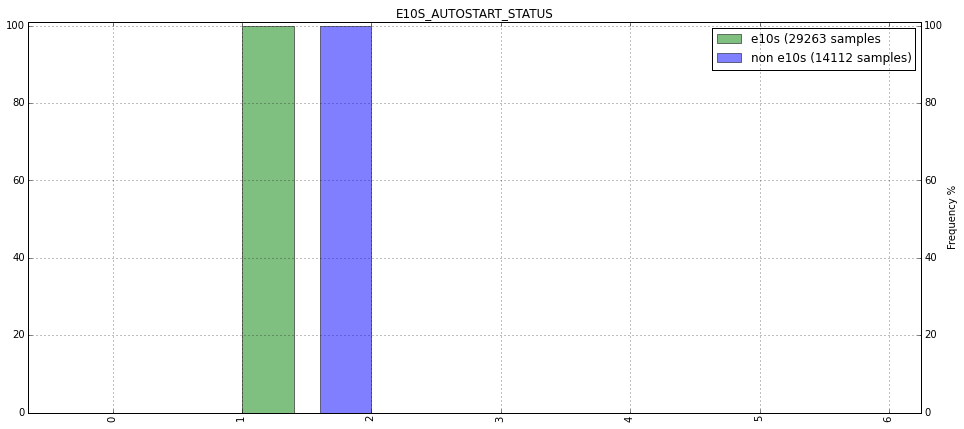

The chi2 distance for E10S_AUTOSTART is 0.9999999999


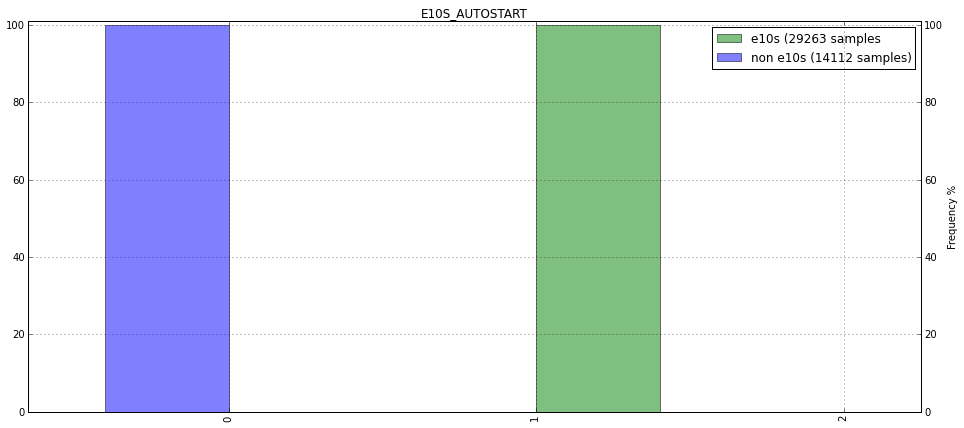

The chi2 distance for BLOCKED_ON_PLUGIN_MODULE_INIT_MS is 0.99999999925


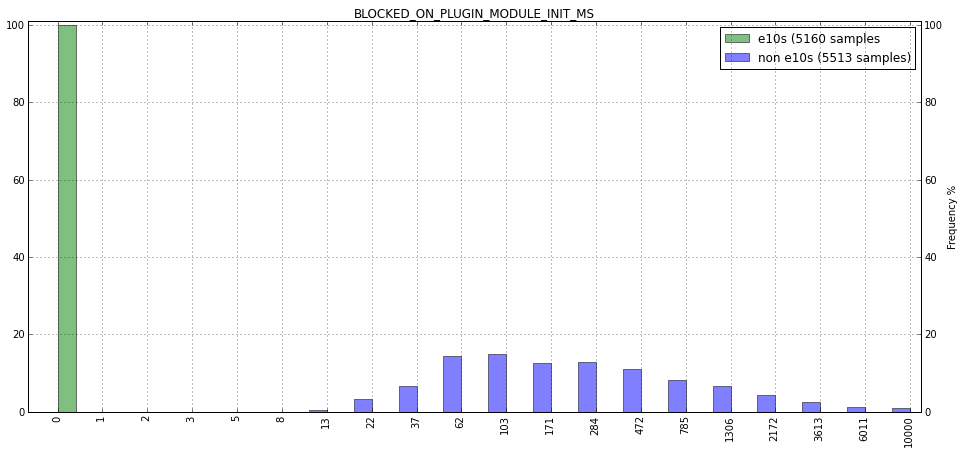

The chi2 distance for E10S_WINDOW is 0.997259056127


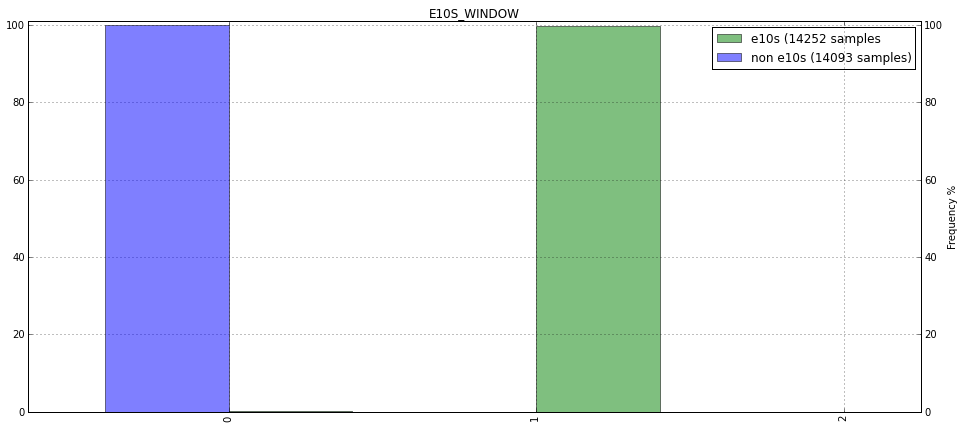

The chi2 distance for FIND_PLUGINS is 0.585831624904


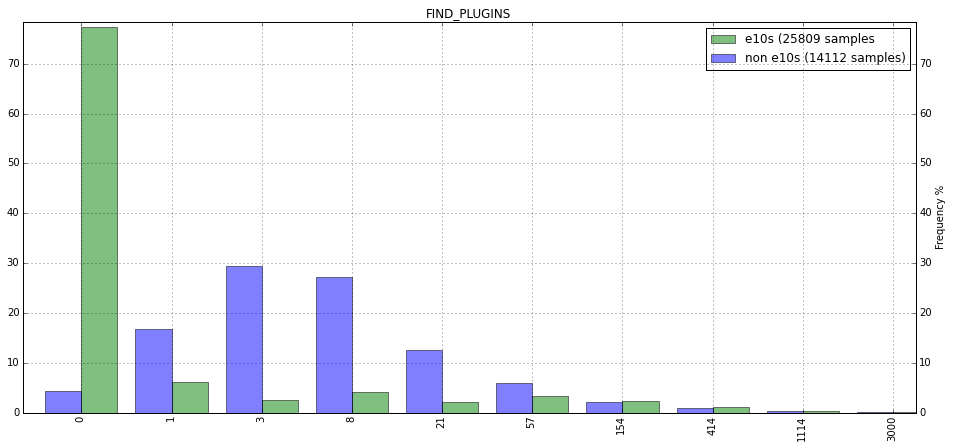

The chi2 distance for HTTP_REQUEST_PER_PAGE_FROM_CACHE is 0.472761300917


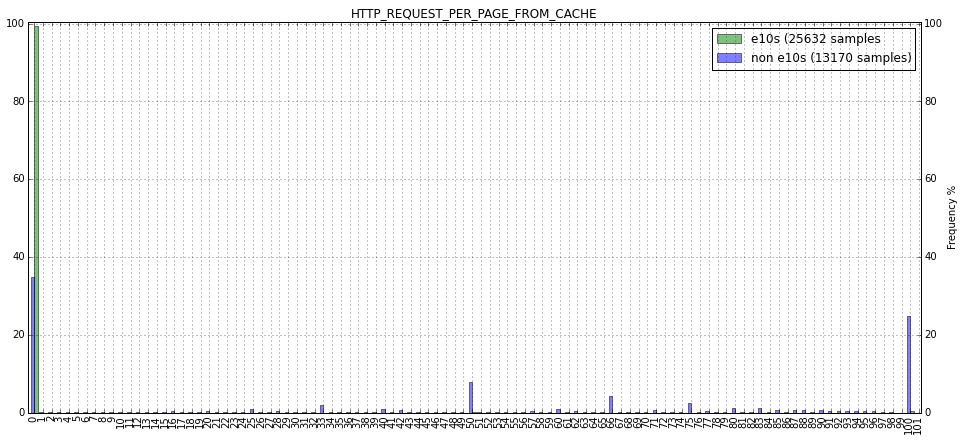

The chi2 distance for FX_THUMBNAILS_CAPTURE_TIME_MS is 0.445439150259


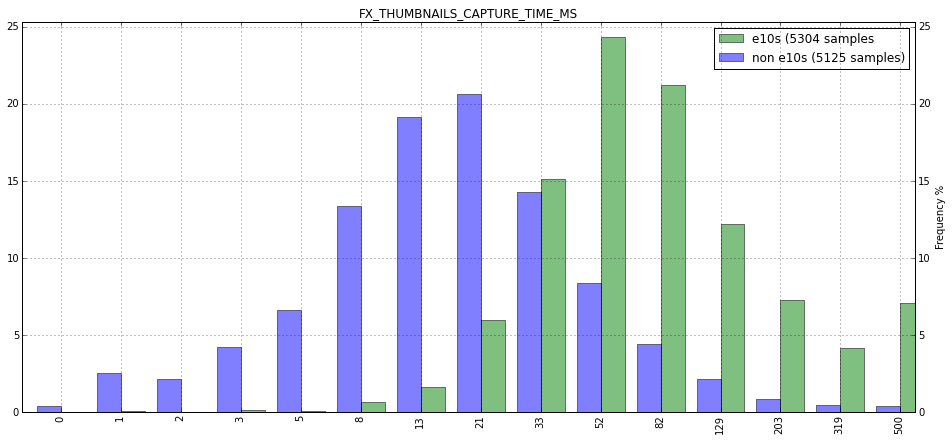

The chi2 distance for MEMORY_JS_COMPARTMENTS_SYSTEM is 0.439043994903


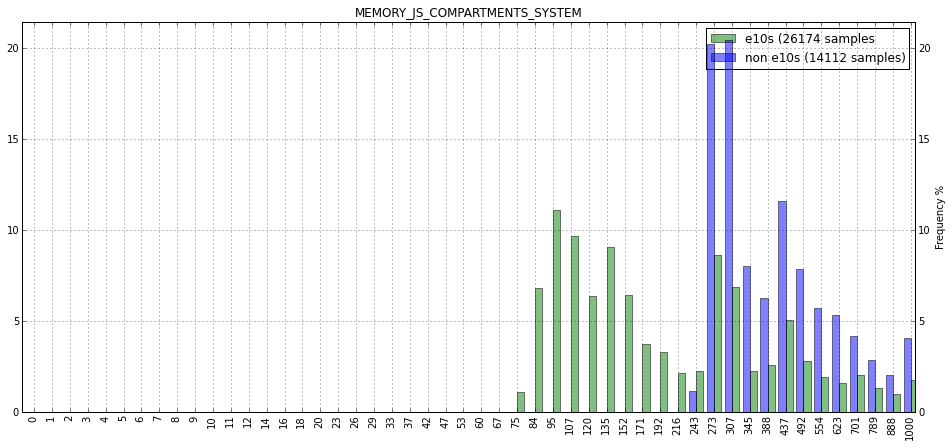

The chi2 distance for GC_MINOR_REASON_LONG is 0.34366215971


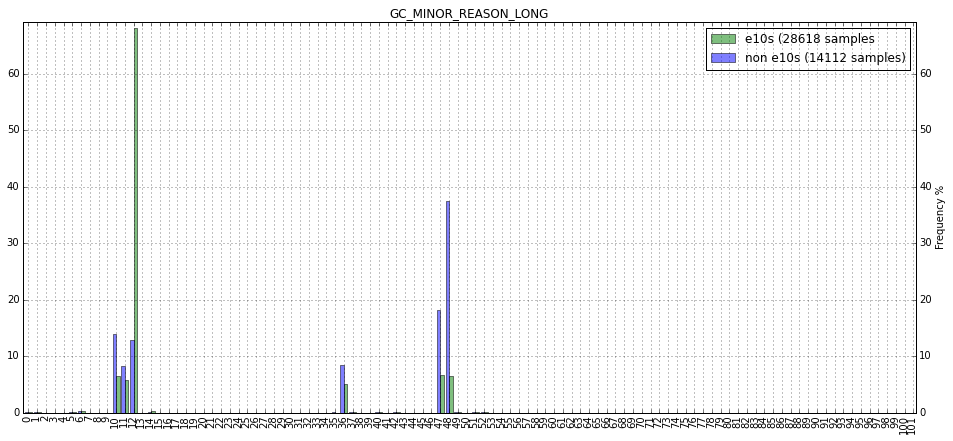

The chi2 distance for HTTP_SUB_DNS_ISSUE_TIME is 0.256530798837


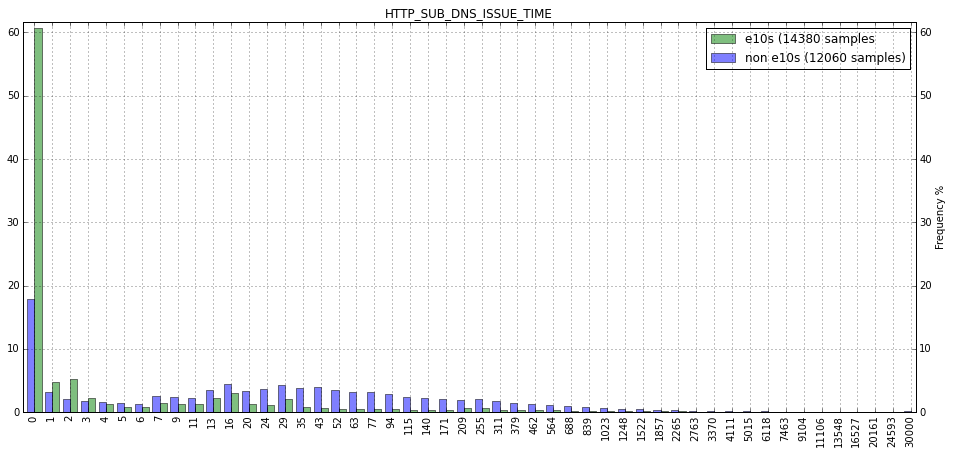

The chi2 distance for HTTP_SUB_DNS_LOOKUP_TIME is 0.232497059537


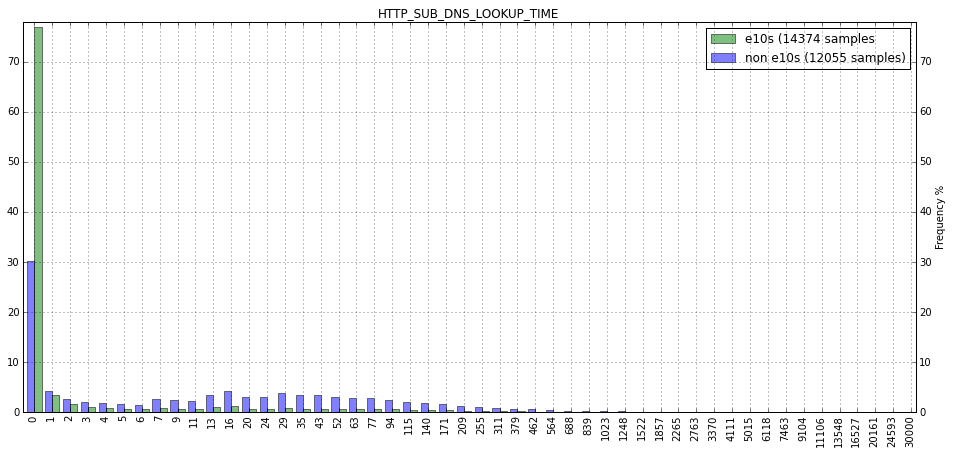

The chi2 distance for SIMPLE_MEASURES_FIRSTLOADURI is 0.224991985216


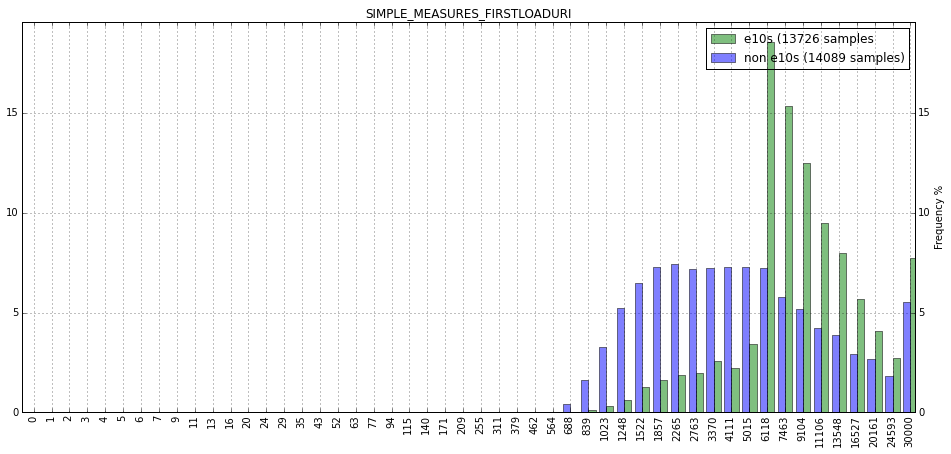

The chi2 distance for HTTP_PAGE_DNS_ISSUE_TIME is 0.215817798849


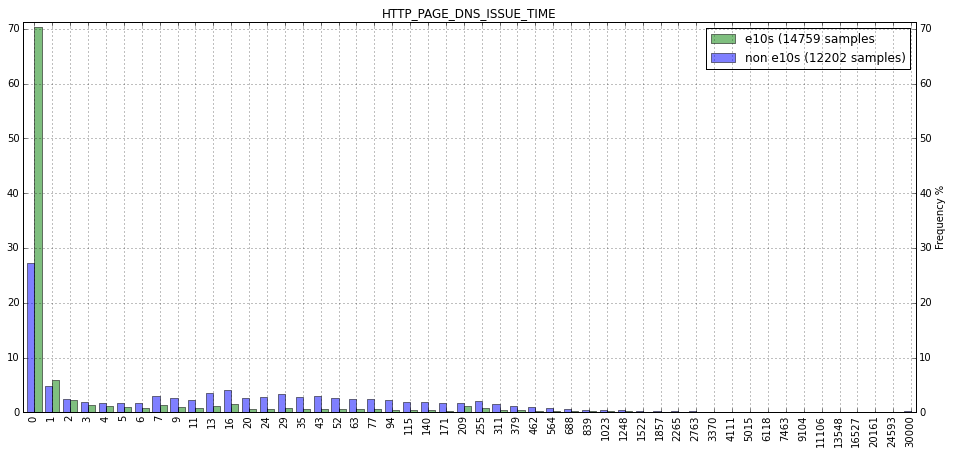

The chi2 distance for HTTP_PAGE_OPEN_TO_FIRST_FROM_CACHE_V2 is 0.197487628067


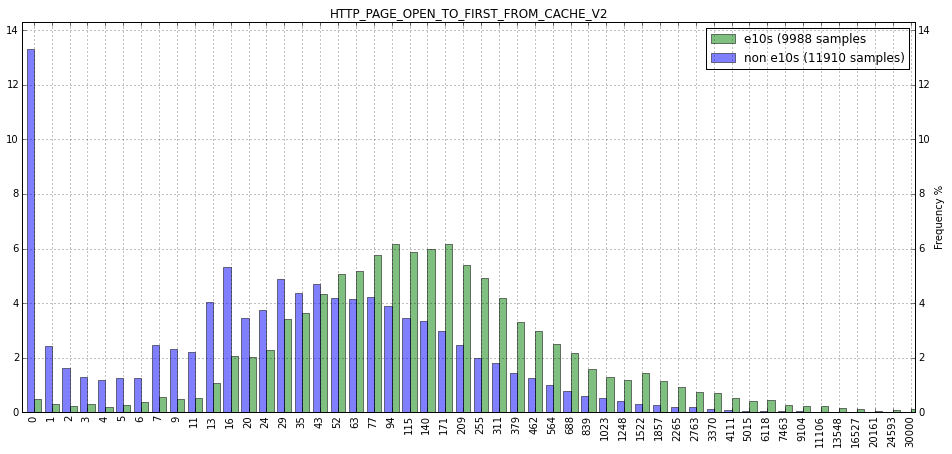

The chi2 distance for GC_MINOR_REASON is 0.175869133311


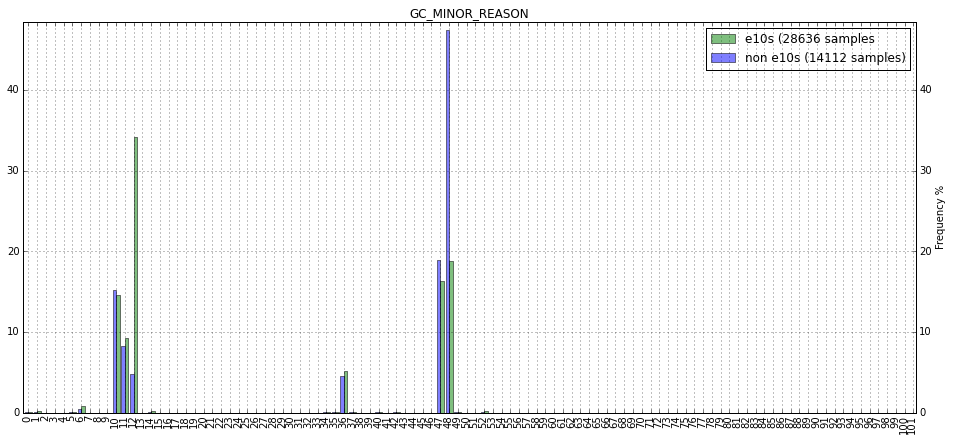

The chi2 distance for CYCLE_COLLECTOR_VISITED_GCED is 0.169073087693


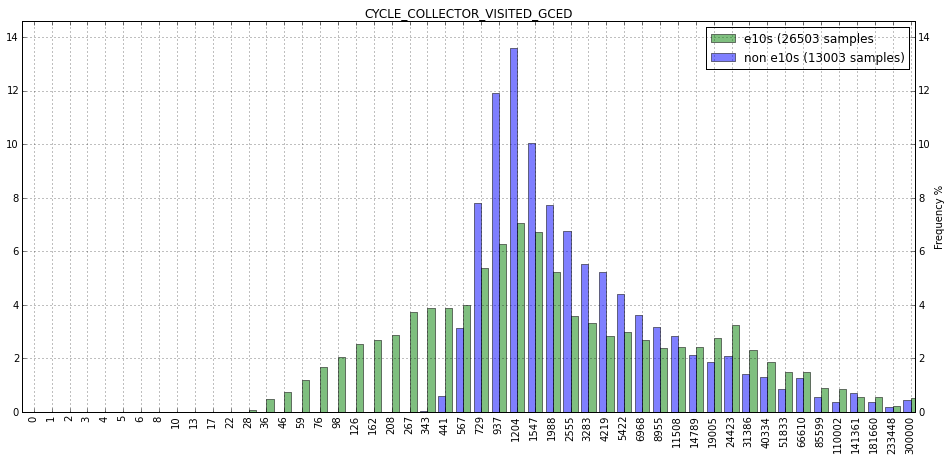

The chi2 distance for MEMORY_JS_COMPARTMENTS_USER is 0.154835707909


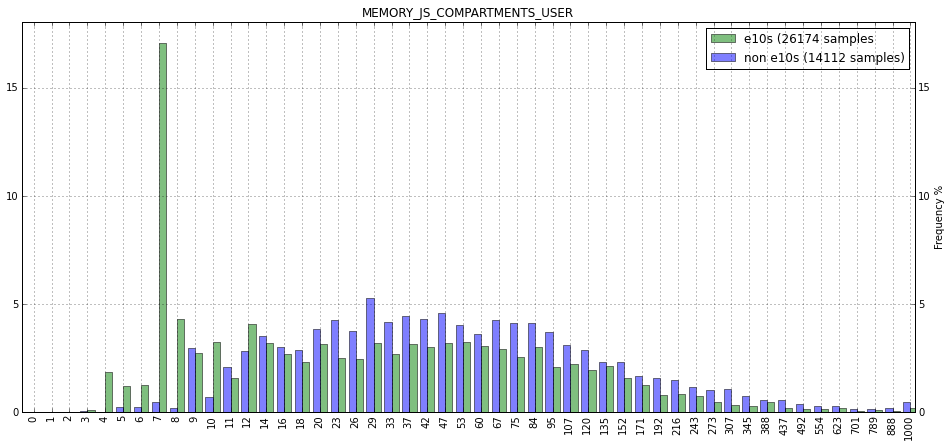

The chi2 distance for FX_TAB_SWITCH_UPDATE_MS is 0.151724179367


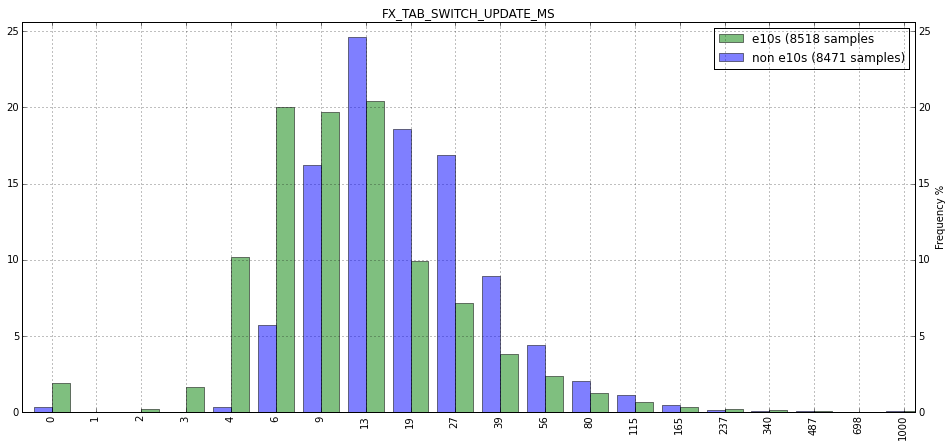

The chi2 distance for SIMPLE_MEASURES_MAXIMALNUMBEROFCONCURRENTTHREADS is 0.142109328702


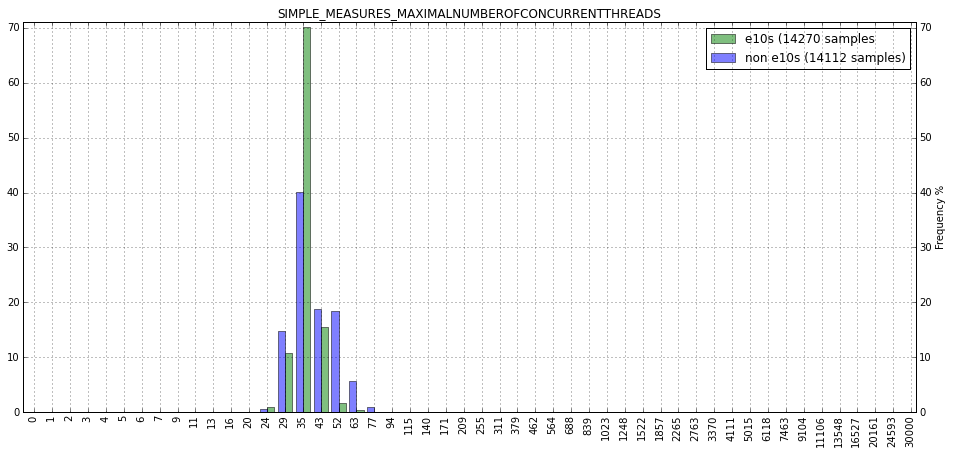

The chi2 distance for FX_TAB_CLICK_MS is 0.139807972866


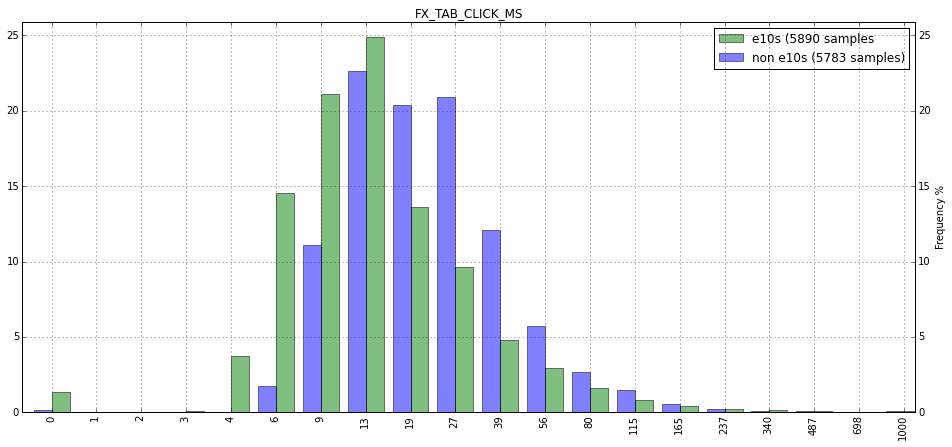

The chi2 distance for GC_MARK_MS is 0.138112378523


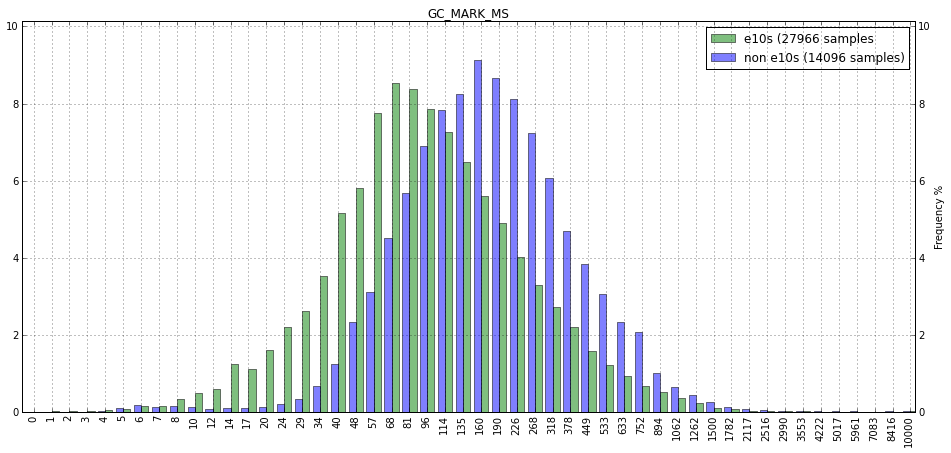

The chi2 distance for GC_MARK_ROOTS_MS is 0.135021990495


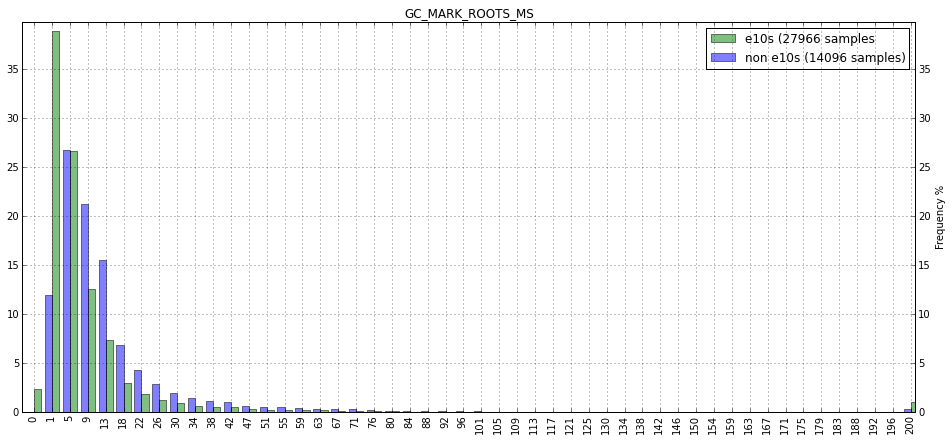

The chi2 distance for GC_MS is 0.123417681263


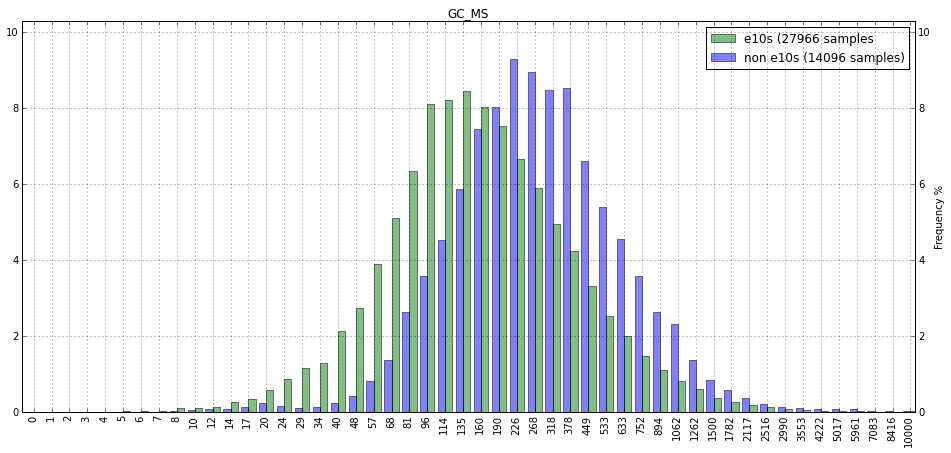

The chi2 distance for MEMORY_VSIZE is 0.118563410912


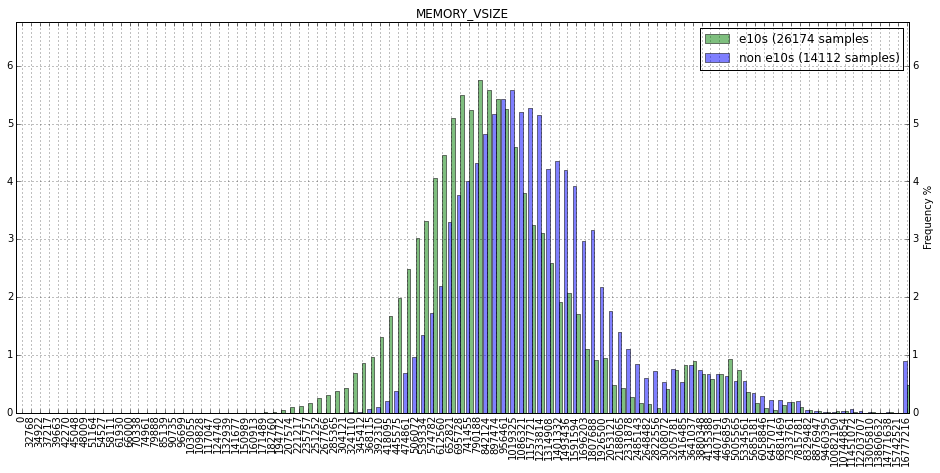

The chi2 distance for MEMORY_RESIDENT is 0.116975061079


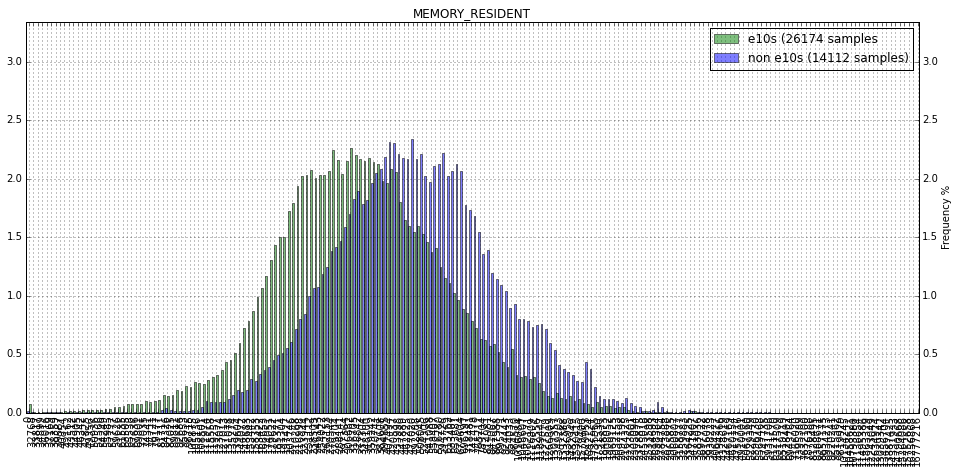

The chi2 distance for MEMORY_JS_GC_HEAP is 0.110147441894


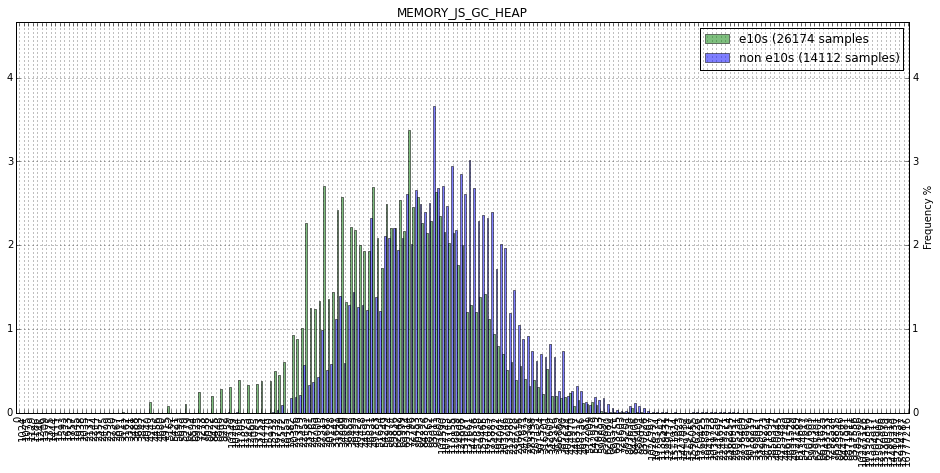

The chi2 distance for MEMORY_HEAP_ALLOCATED is 0.11003463218


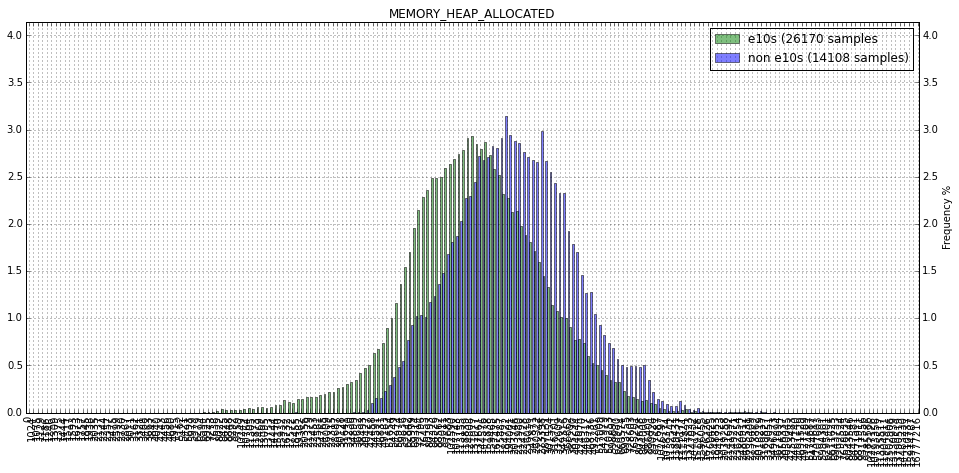

The chi2 distance for SIMPLE_MEASURES_JS_SETPROTO is 0.109606417379


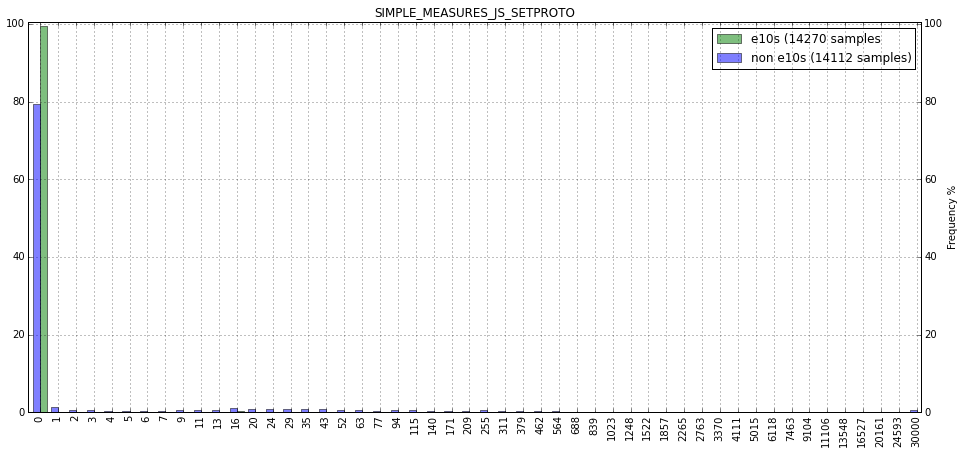

The chi2 distance for HTTP_PAGE_OPEN_TO_FIRST_SENT is 0.106672838101


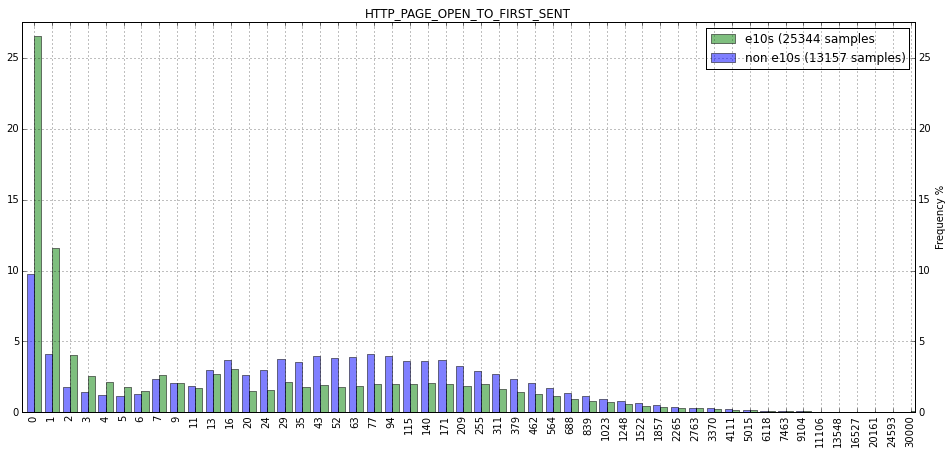

The chi2 distance for CYCLE_COLLECTOR_VISITED_REF_COUNTED is 0.101910005072


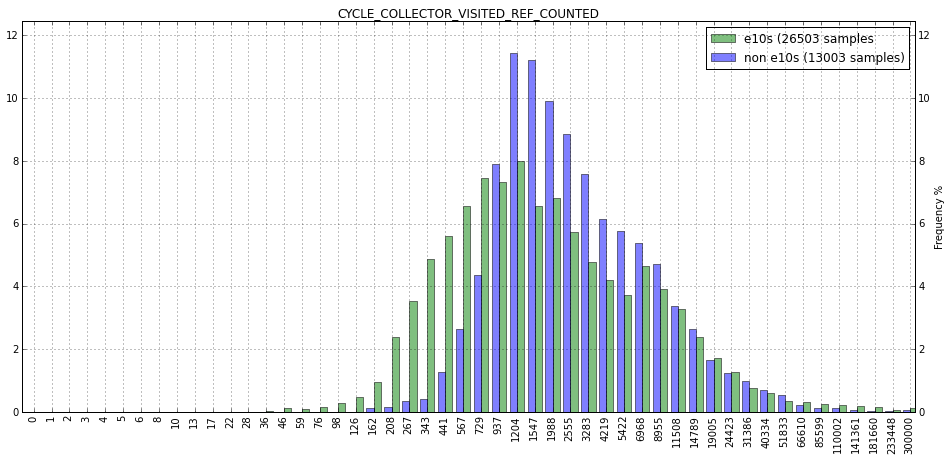

The chi2 distance for HTTP_PAGE_DNS_LOOKUP_TIME is 0.0998632891967


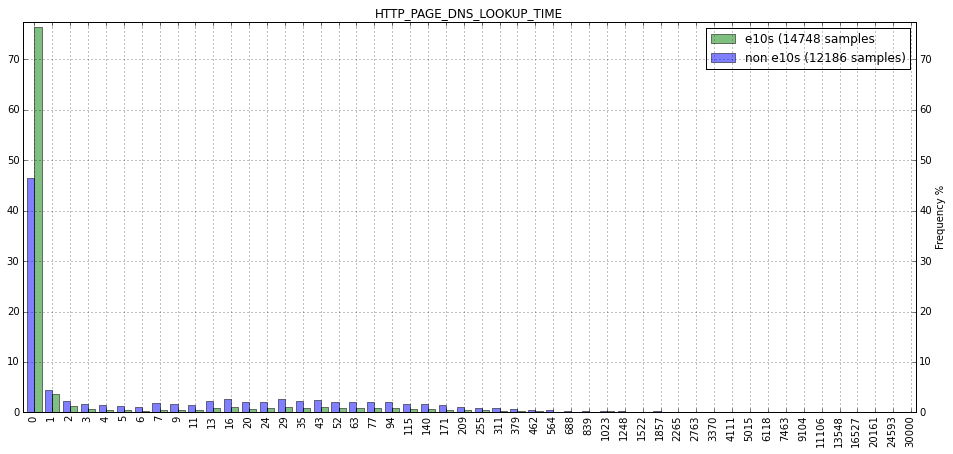

The chi2 distance for GC_SWEEP_MS is 0.0962937168744


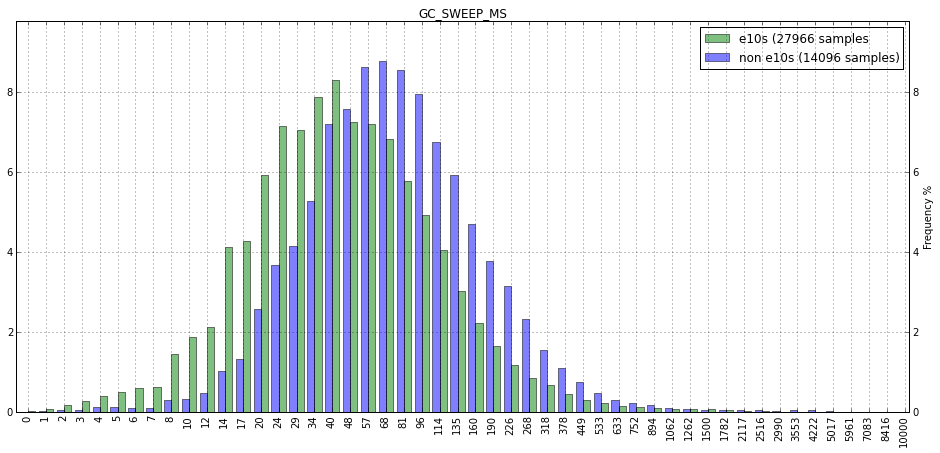

The chi2 distance for HTTP_SUB_OPEN_TO_FIRST_SENT is 0.0953976658391


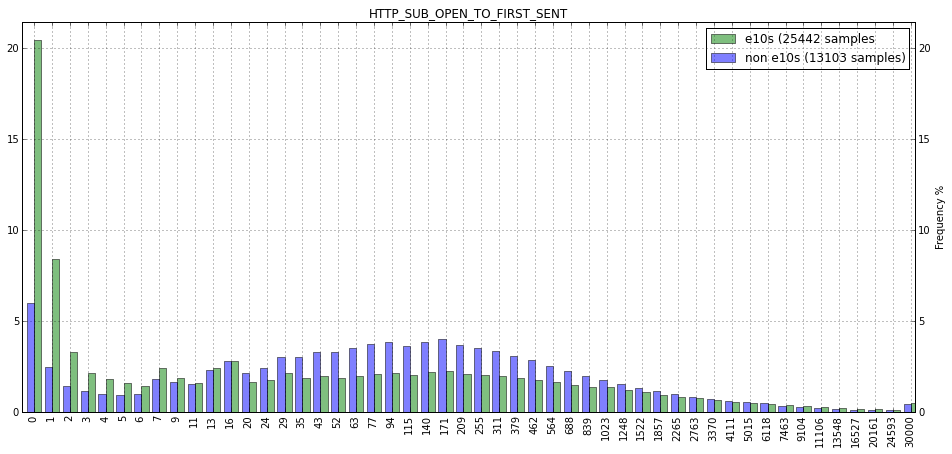

The chi2 distance for PLACES_FAVICON_PNG_SIZES is 0.0922659951163


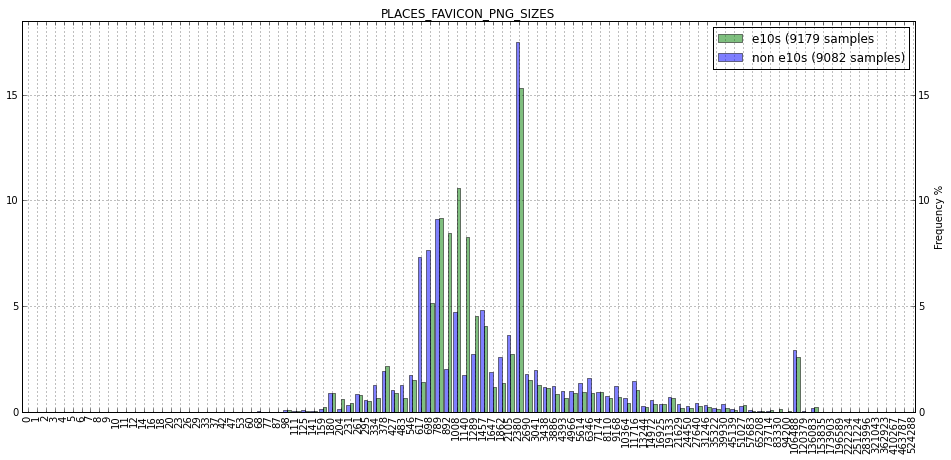

The chi2 distance for HTTP_SUB_REVALIDATION is 0.0893185922923


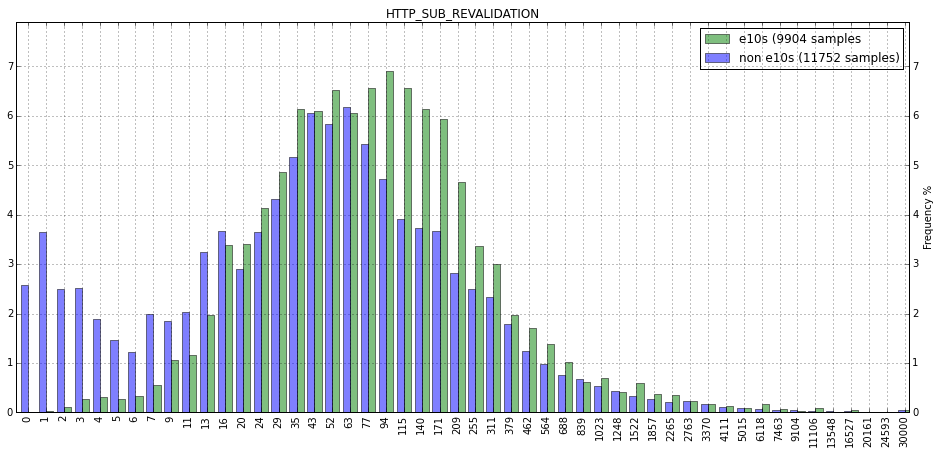

The chi2 distance for HTTP_PAGE_CACHE_READ_TIME_V2 is 0.0884339903978


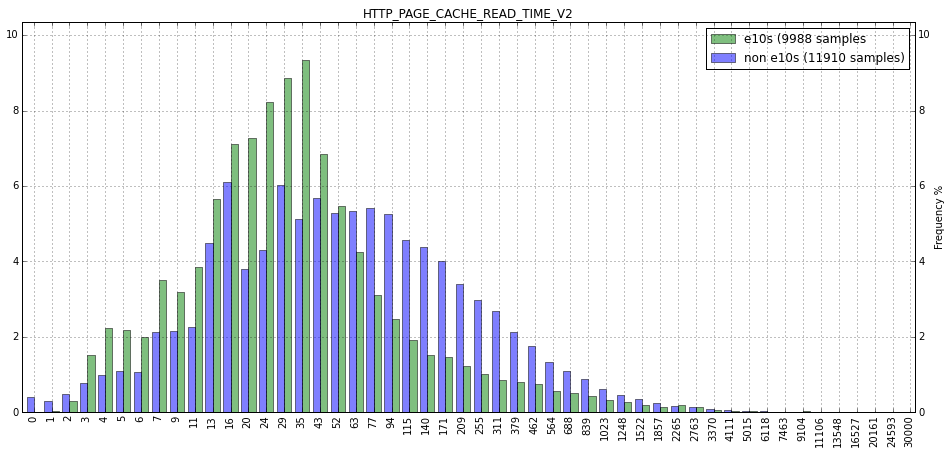

The chi2 distance for SYSTEM_FONT_FALLBACK is 0.085161674804


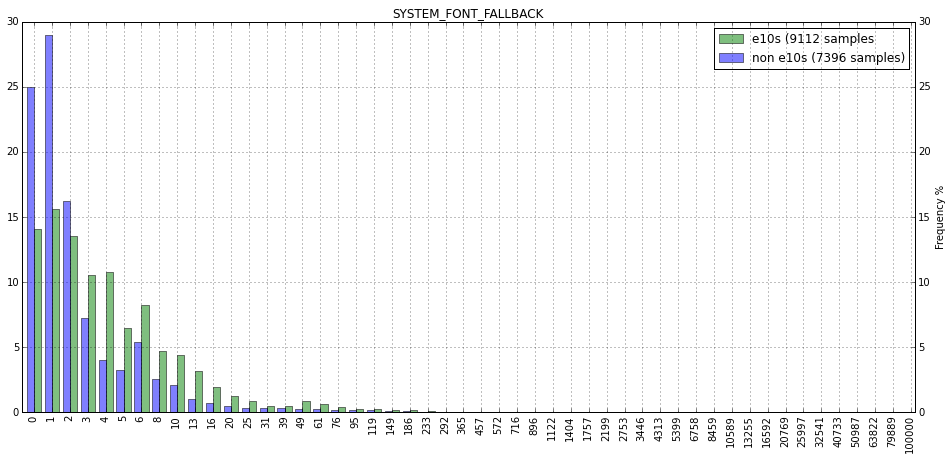

The chi2 distance for LOCALDOMSTORAGE_GETVALUE_BLOCKING_MS is 0.0749076860398


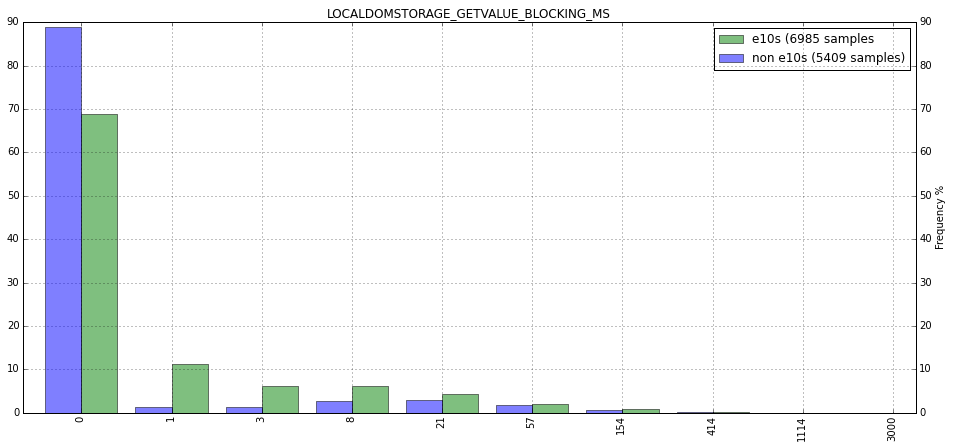

The chi2 distance for HTTP_PAGE_COMPLETE_LOAD_CACHED_V2 is 0.0733197082729


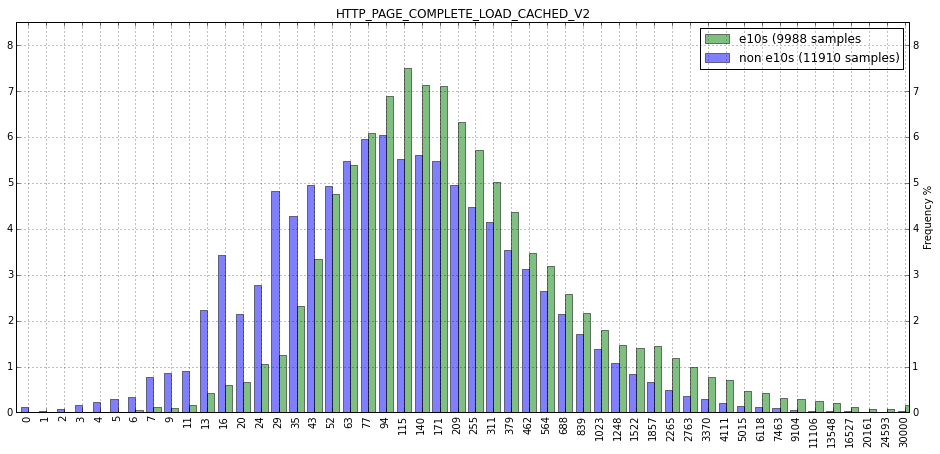

The chi2 distance for HTTP_PAGE_COMPLETE_LOAD is 0.0732874574247


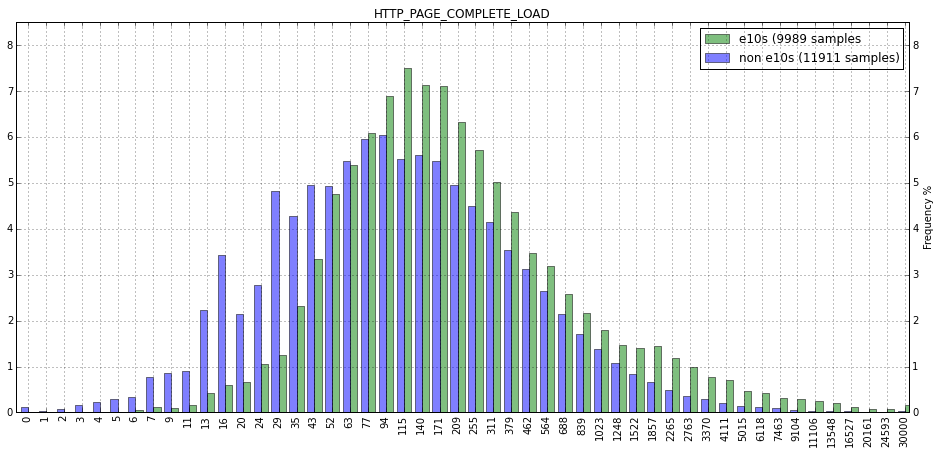

The chi2 distance for CYCLE_COLLECTOR is 0.067407018653


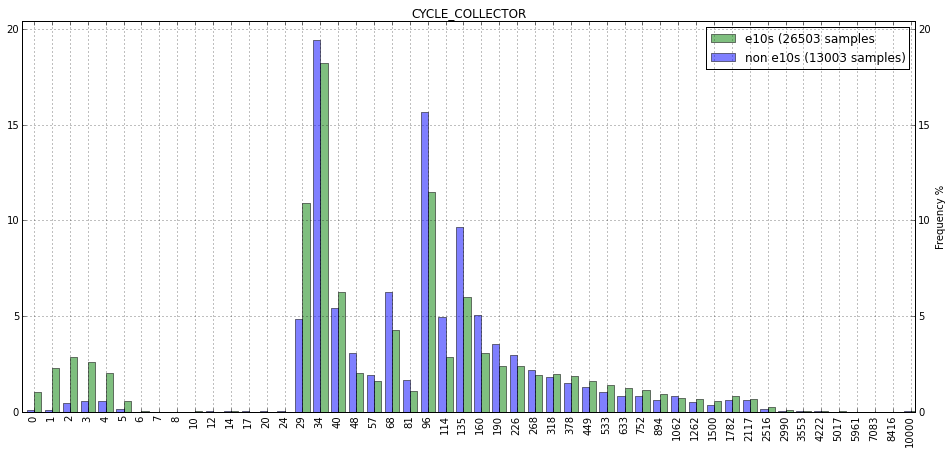

The chi2 distance for CYCLE_COLLECTOR_FULL is 0.0673540080995


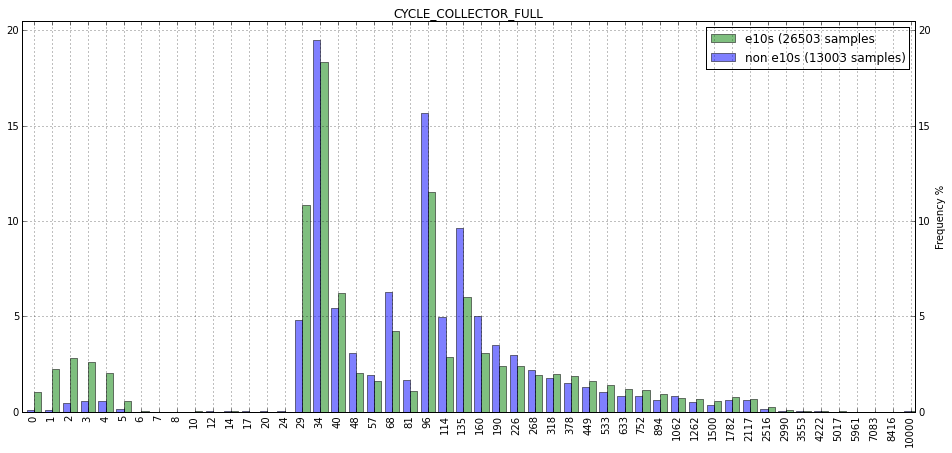

The chi2 distance for HTTP_SUB_OPEN_TO_FIRST_FROM_CACHE_V2 is 0.0616825041788


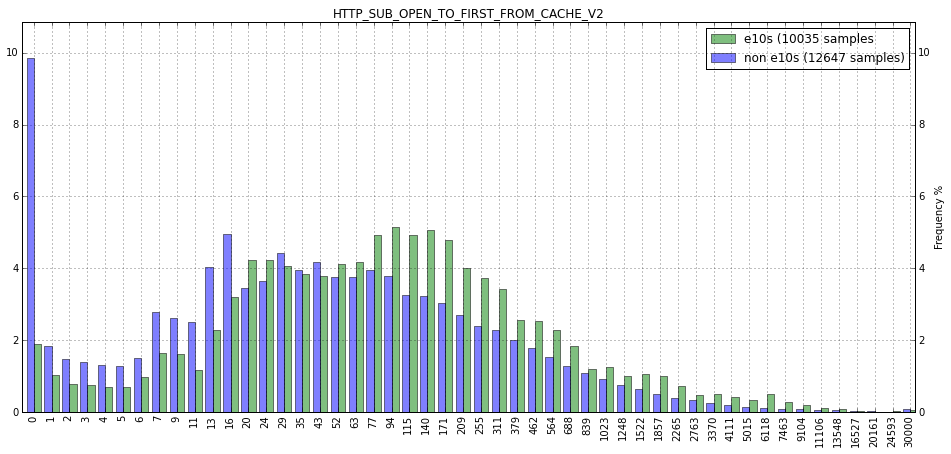

The chi2 distance for MEMORY_JS_MAIN_RUNTIME_TEMPORARY_PEAK is 0.0600159535482


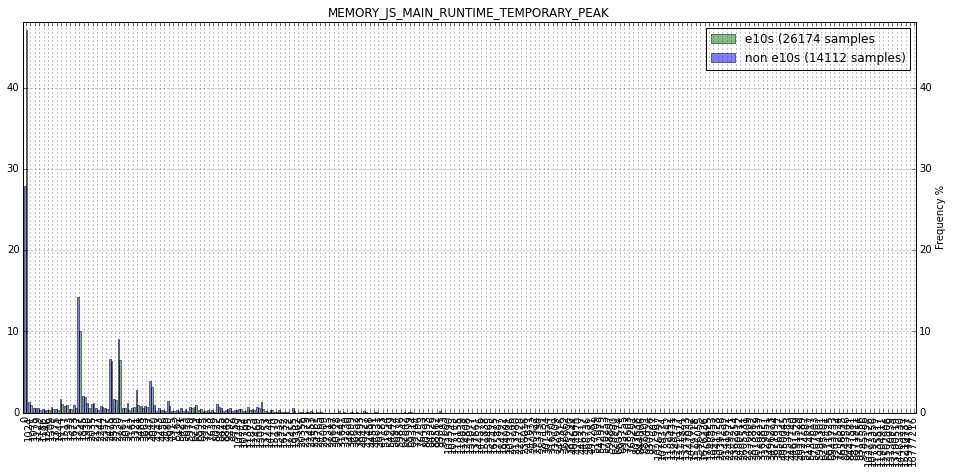

The chi2 distance for IMAGE_DECODE_ON_DRAW_LATENCY is 0.0585397477172


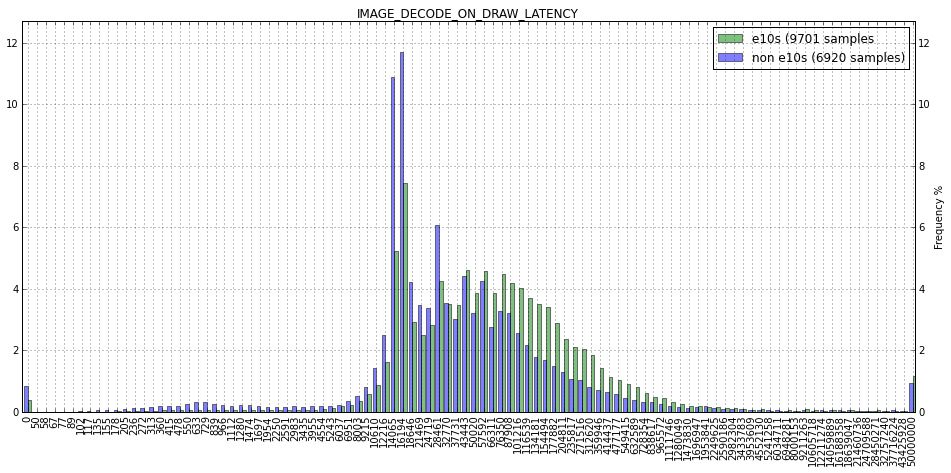

The chi2 distance for PAINT_BUILD_DISPLAYLIST_TIME is 0.0563903241015


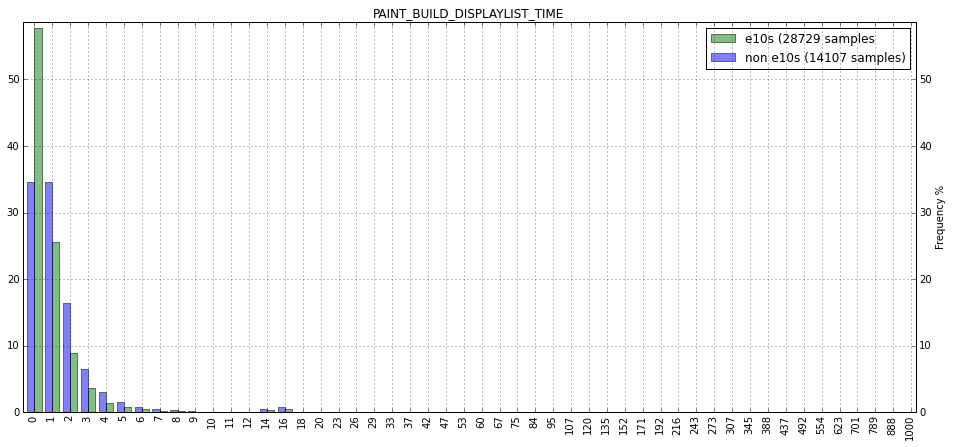

The chi2 distance for GC_MMU_50 is 0.0540342676469


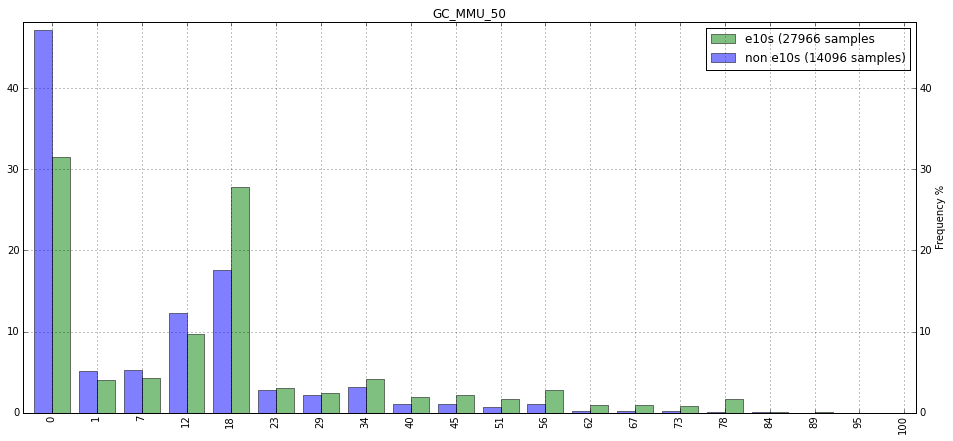

The chi2 distance for GC_MARK_GRAY_MS is 0.0524445246478


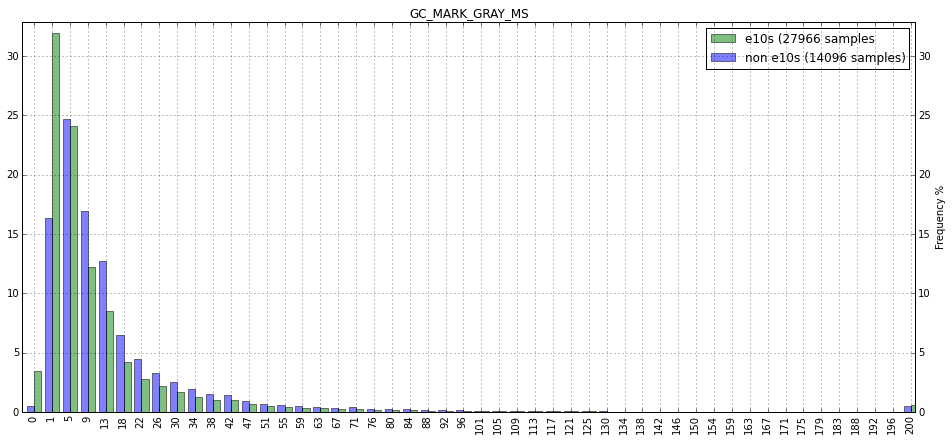

The chi2 distance for MEMORY_HEAP_COMMITTED_UNUSED_RATIO is 0.0501560039546


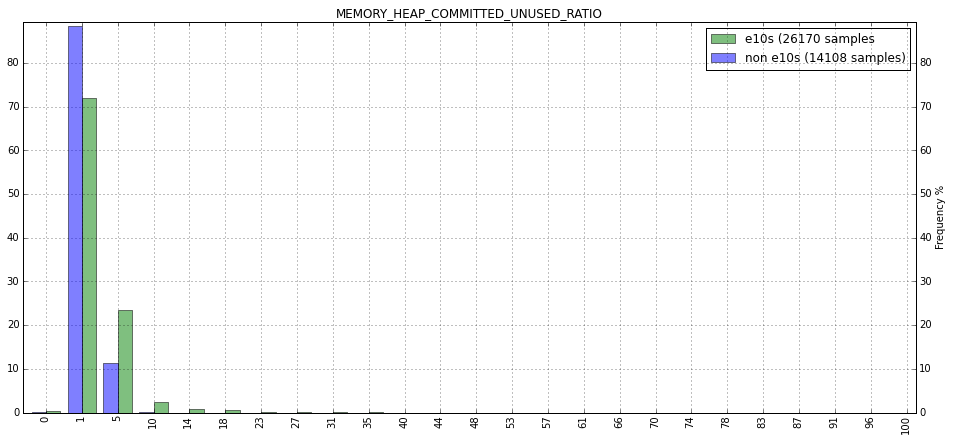

The chi2 distance for ADDON_SHIM_USAGE is 0.0481590123191


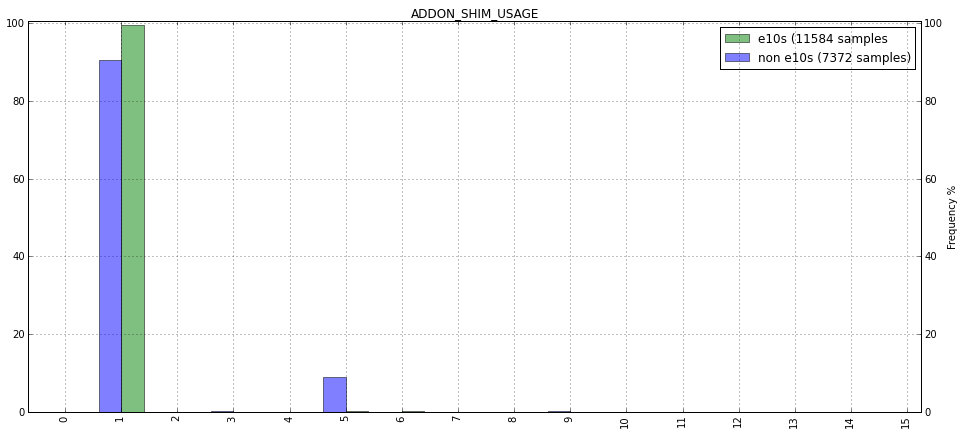

The chi2 distance for IMAGE_MAX_DECODE_COUNT is 0.0444081293419


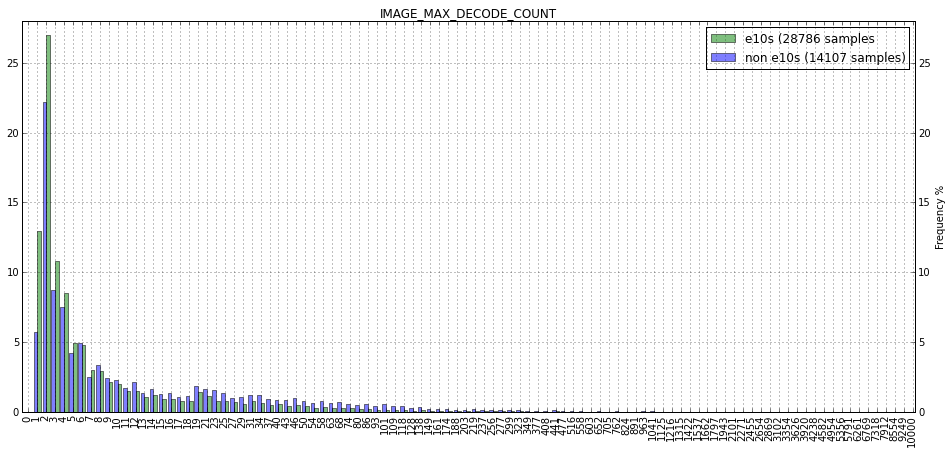

The chi2 distance for GC_REASON_2 is 0.043741528147


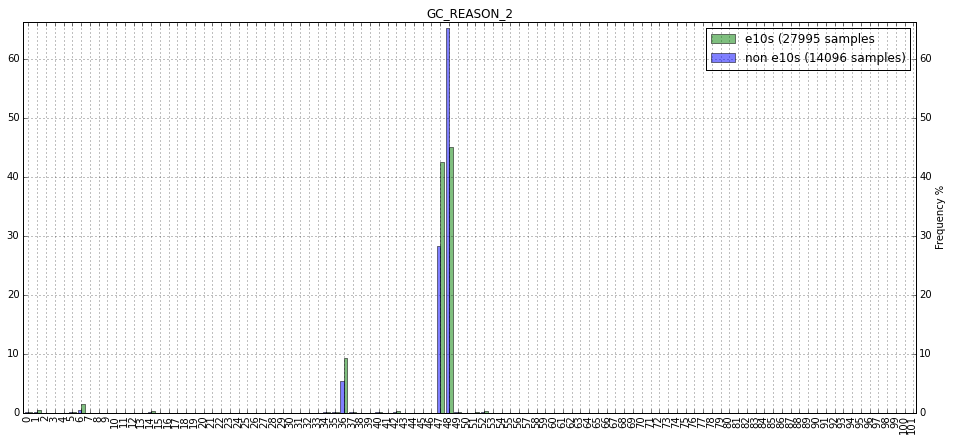

The chi2 distance for FX_PAGE_LOAD_MS is 0.0412690803043


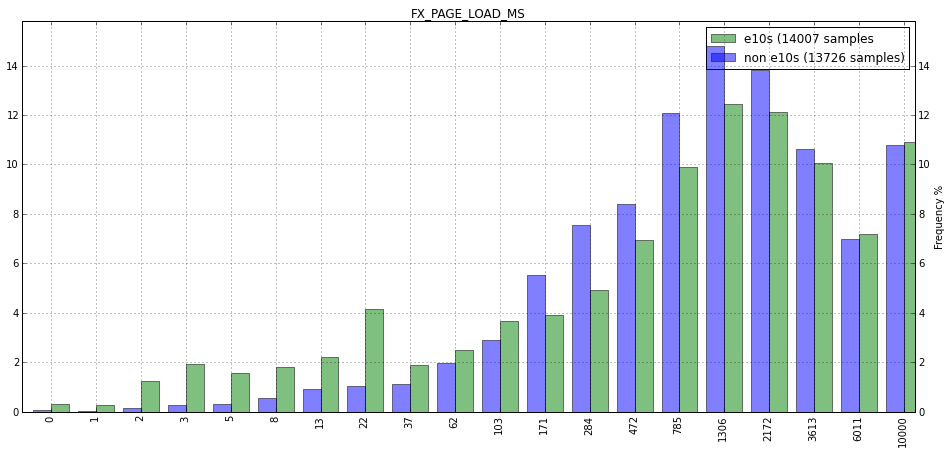

The chi2 distance for GC_SCC_SWEEP_TOTAL_MS is 0.0384216569094


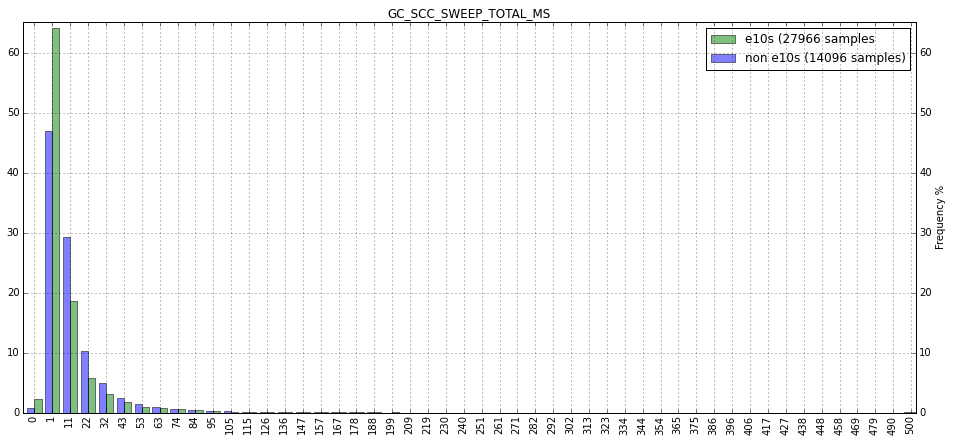

The chi2 distance for TELEMETRY_MEMORY_REPORTER_MS is 0.0377314192607


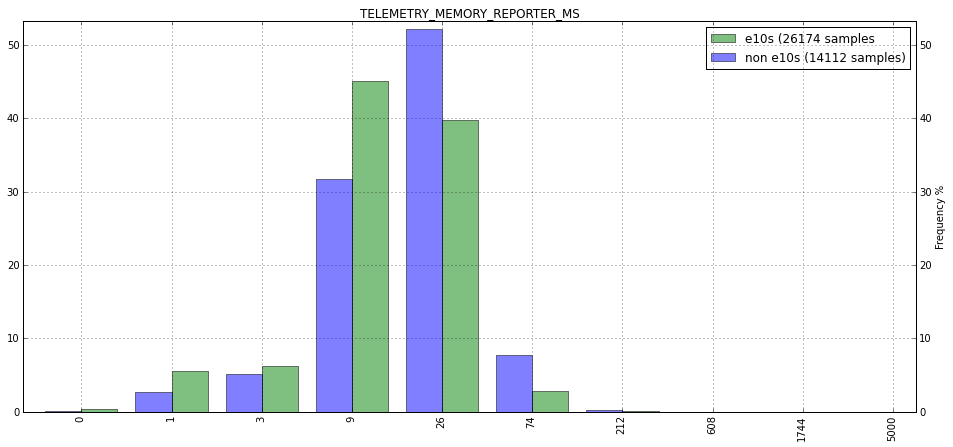

The chi2 distance for FX_TAB_ANIM_ANY_FRAME_INTERVAL_MS is 0.0374893063242


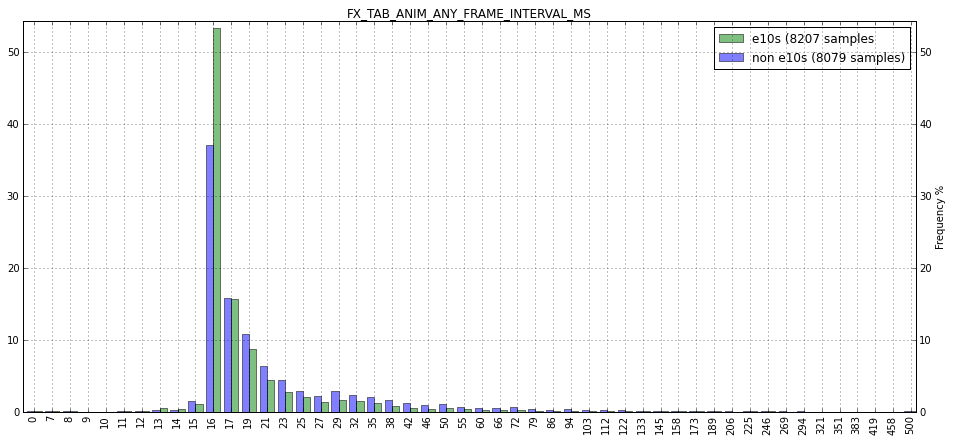

The chi2 distance for SYSTEM_FONT_FALLBACK_SCRIPT is 0.0344431938628


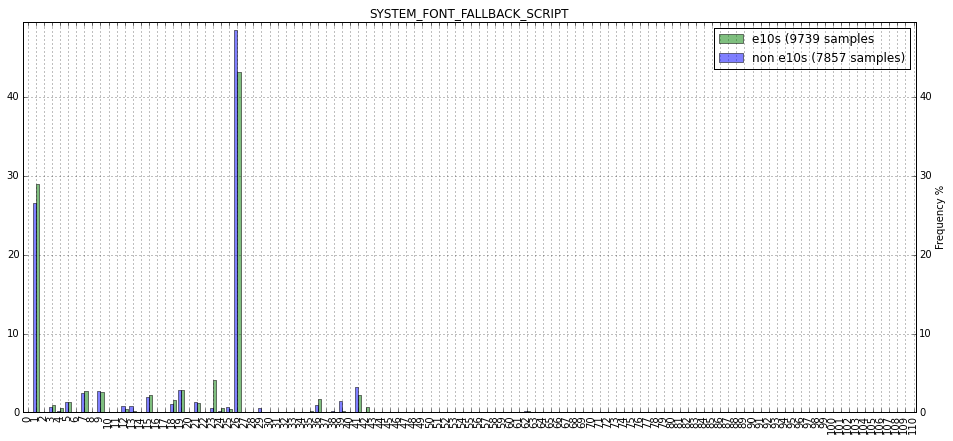

The chi2 distance for GC_MINOR_US is 0.0342546644748


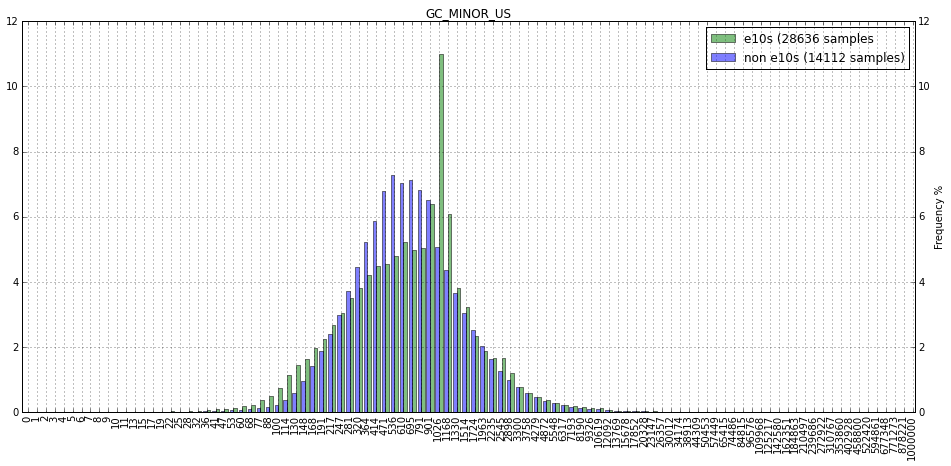

The chi2 distance for HTTP_SUBITEM_OPEN_LATENCY_TIME is 0.0341288069874


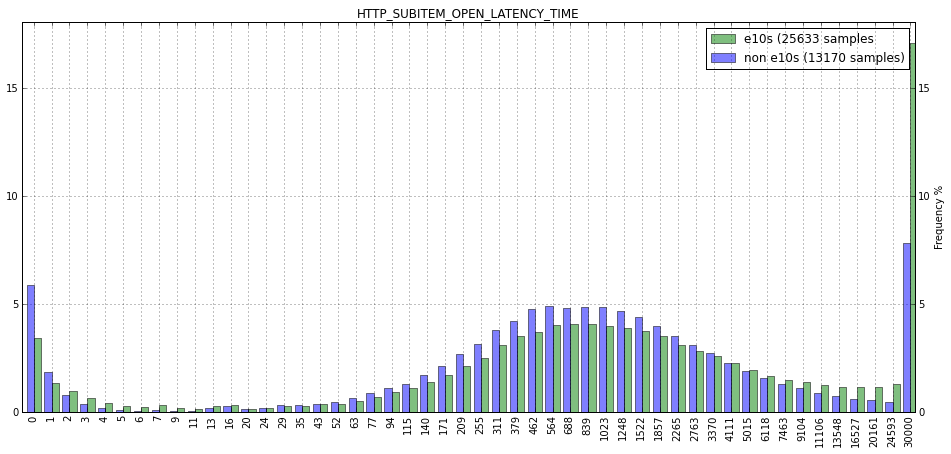

The chi2 distance for MEMORY_VSIZE_MAX_CONTIGUOUS is 0.033416296499


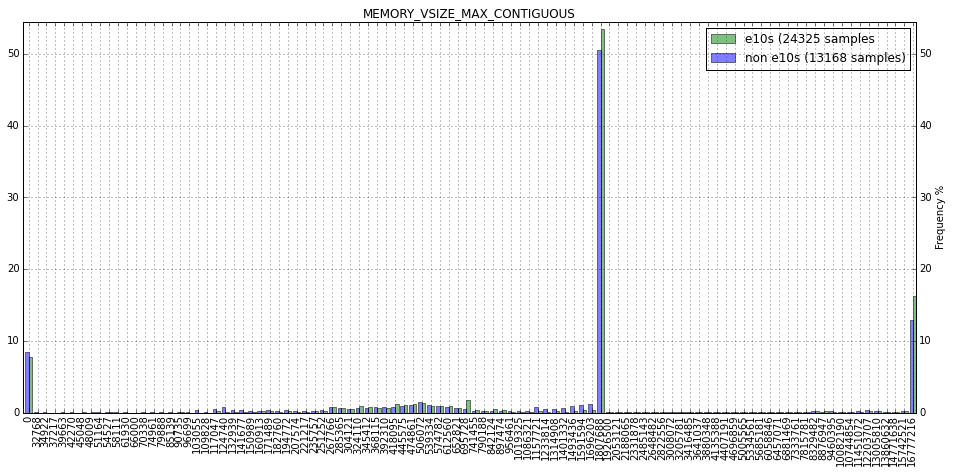

The chi2 distance for PLACES_FAVICON_ICO_SIZES is 0.031822858005


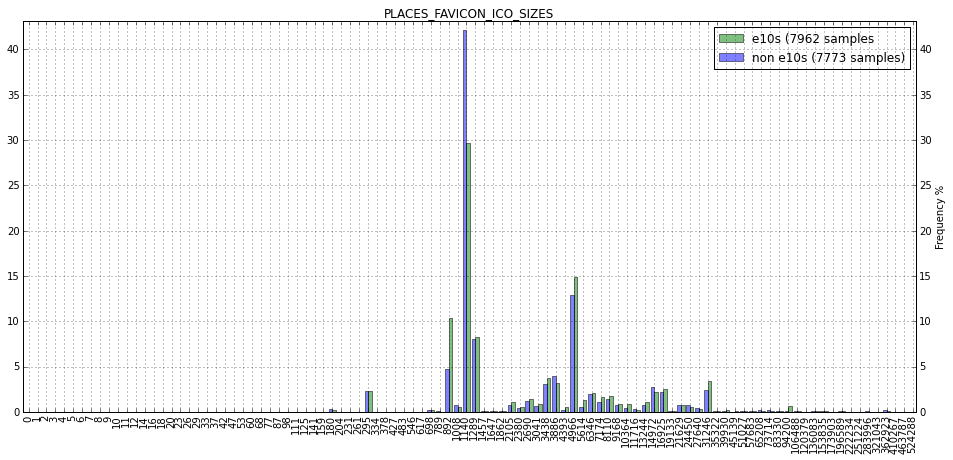

The chi2 distance for GC_MAX_PAUSE_MS is 0.0310595586013


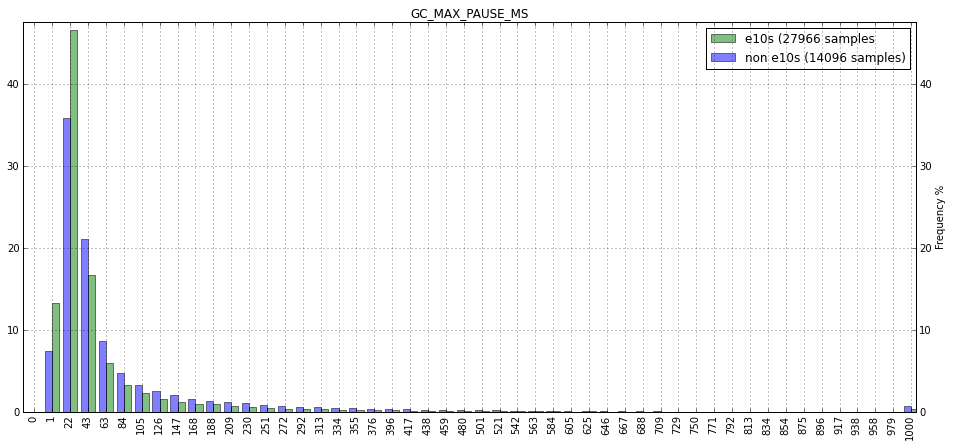

The chi2 distance for NETWORK_CACHE_V2_INPUT_STREAM_STATUS is 0.028124989199


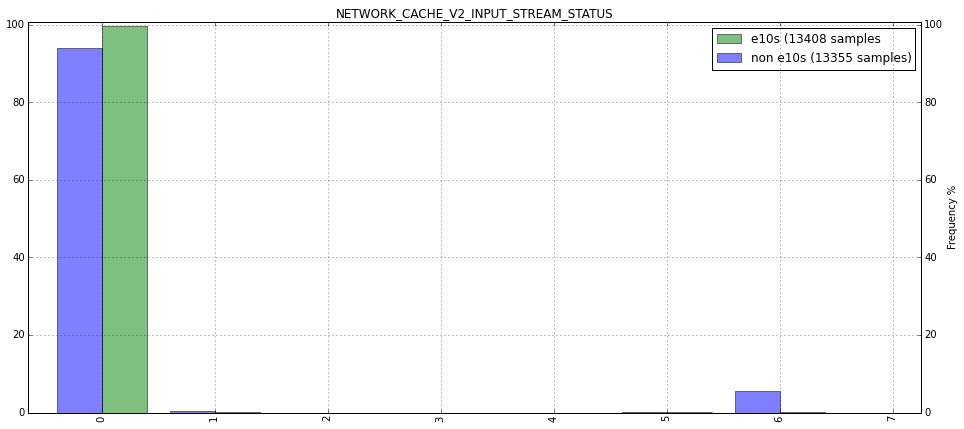

The chi2 distance for GC_SCC_SWEEP_MAX_PAUSE_MS is 0.0272884277201


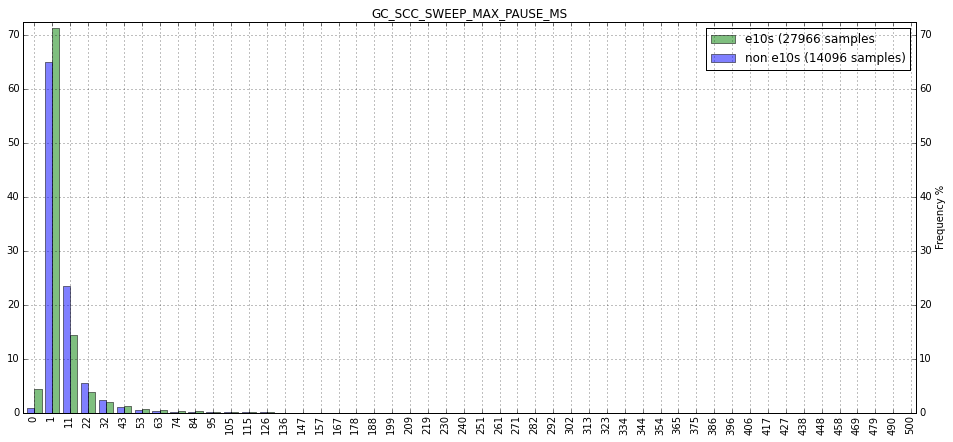

The chi2 distance for GC_SLICE_MS is 0.0270702913951


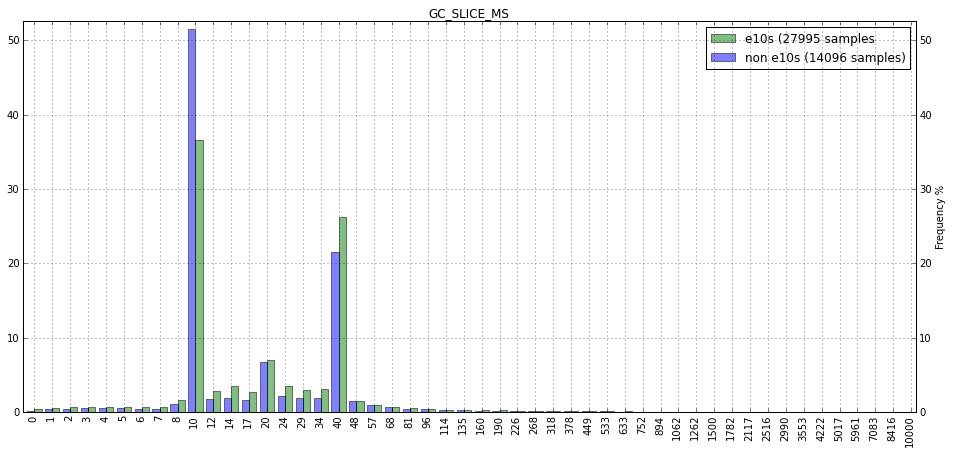

The chi2 distance for NETWORK_CACHE_HIT_RATE_PER_CACHE_SIZE is 0.0247918129695


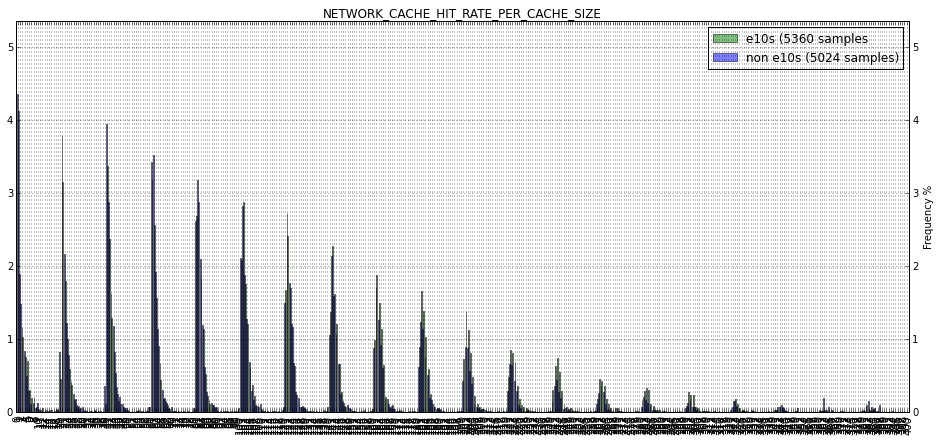

The chi2 distance for HTTP_SUB_COMPLETE_LOAD_CACHED_V2 is 0.0245814282741


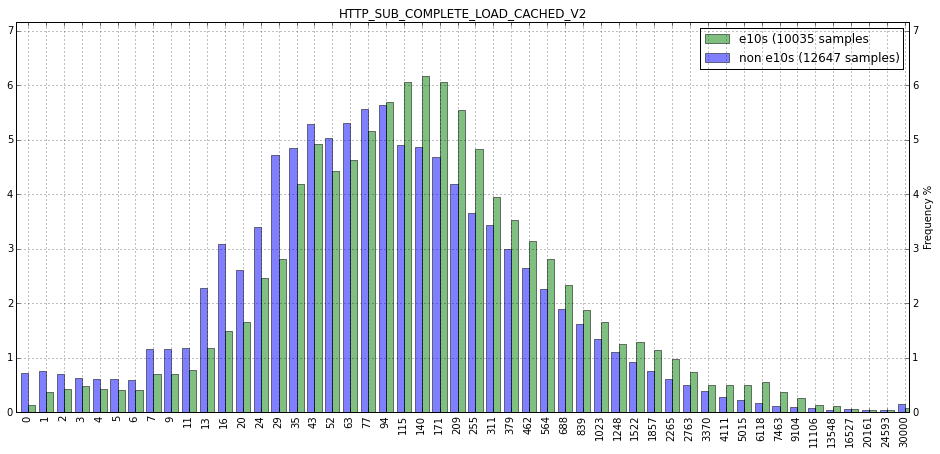

The chi2 distance for HTTP_SUB_COMPLETE_LOAD is 0.0245472570577


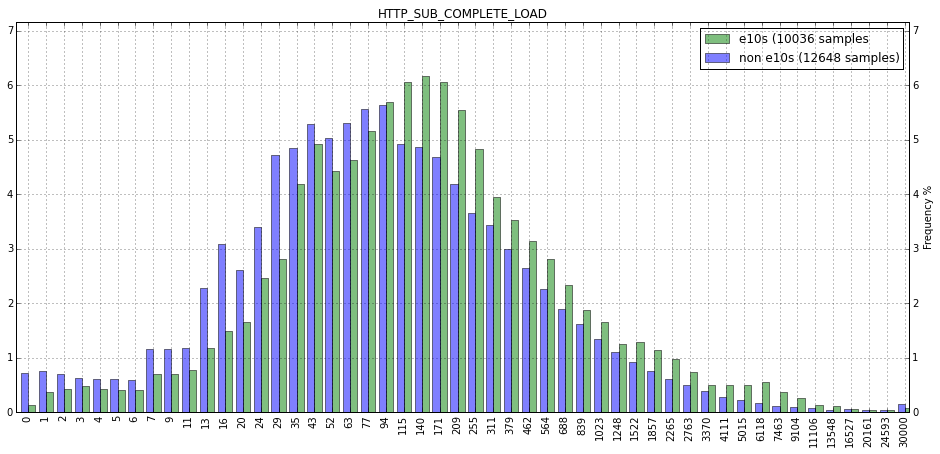

The chi2 distance for HTTP_SUB_CACHE_READ_TIME_V2 is 0.0238207267858


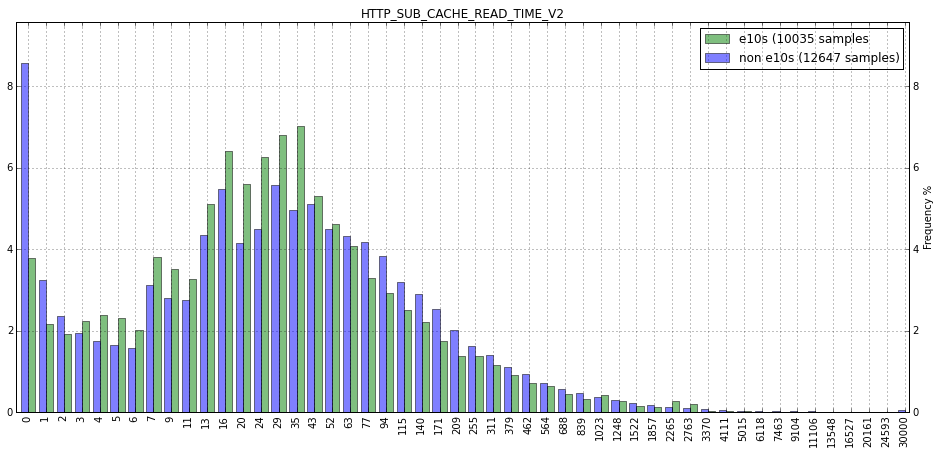

The chi2 distance for GC_BUDGET_MS is 0.0220650096123


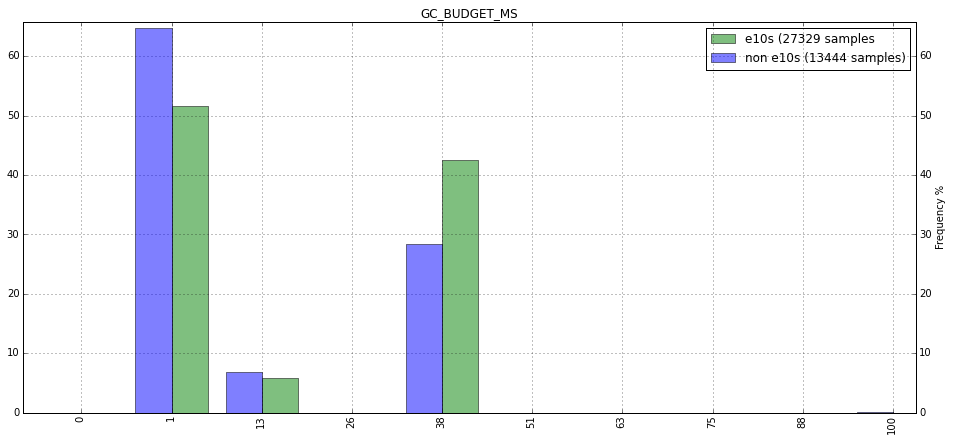

The chi2 distance for LINK_ICON_SIZES_ATTR_USAGE is 0.0218843818258


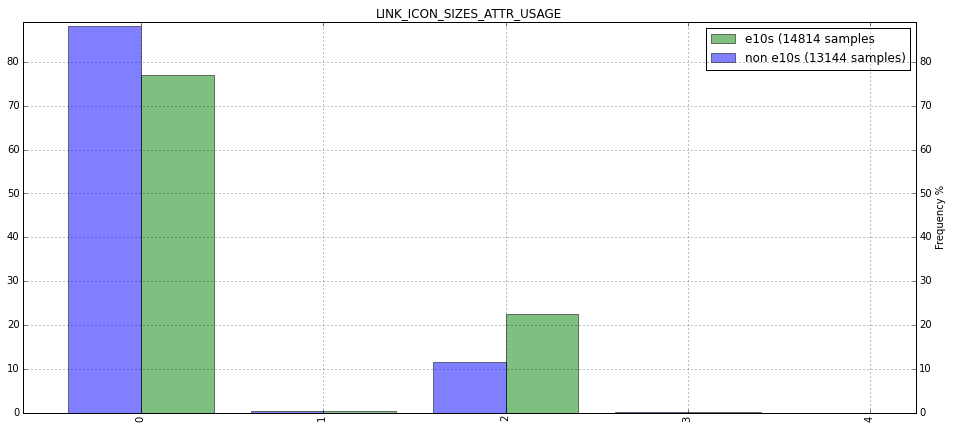

The chi2 distance for HTTP_SUB_OPEN_TO_FIRST_RECEIVED is 0.0213958587435


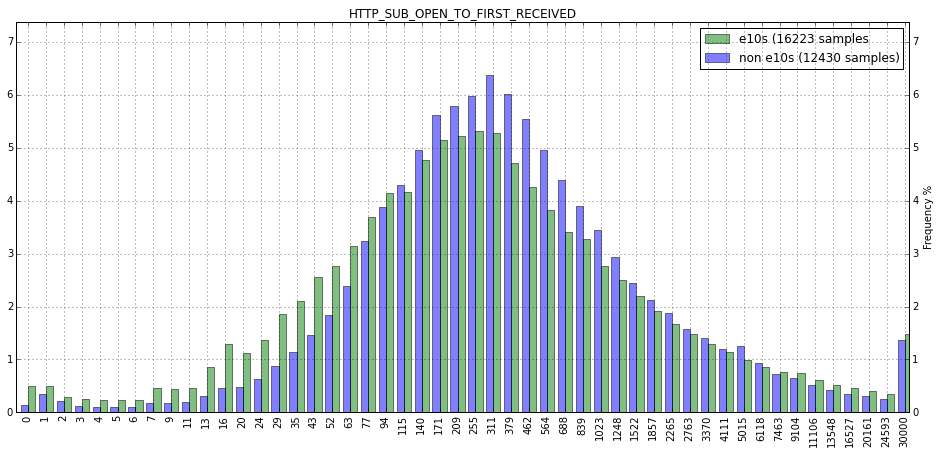

The chi2 distance for DNS_FAILED_LOOKUP_TIME is 0.0203362462994


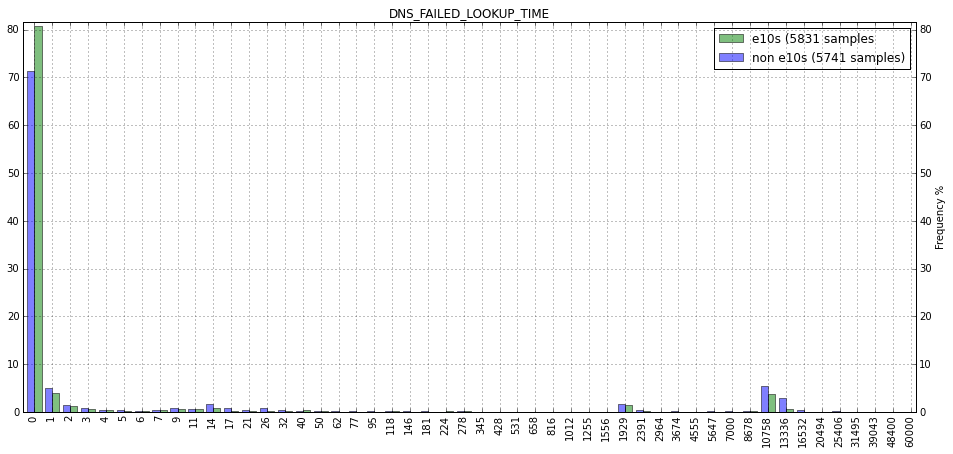

The chi2 distance for PAINT_RASTERIZE_TIME is 0.0202415090331


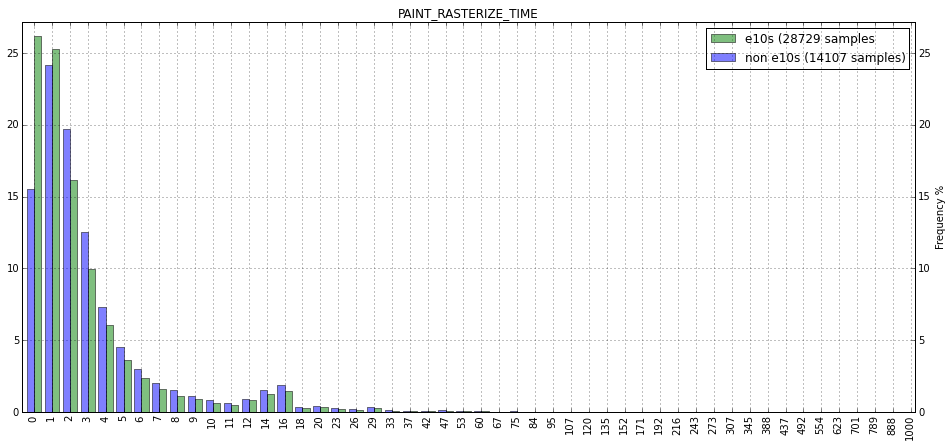

The chi2 distance for HTTP_SUB_COMPLETE_LOAD_V2 is 0.0199355714762


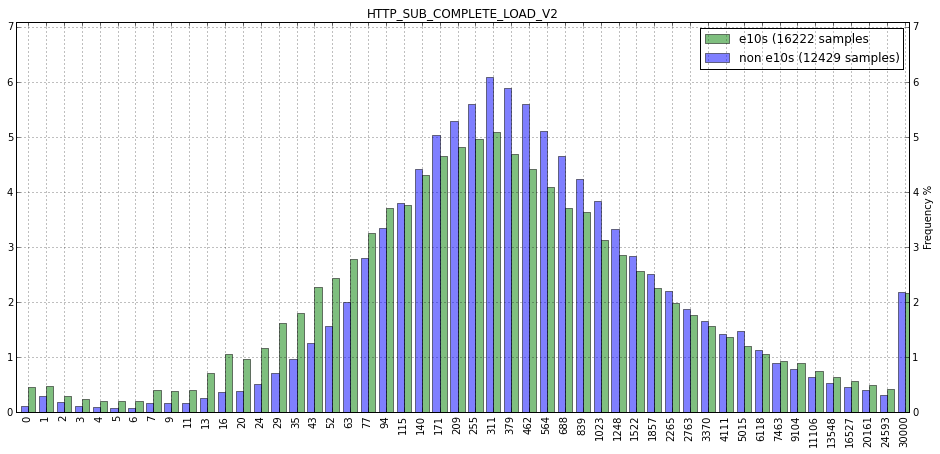

The chi2 distance for HTTP_SUB_COMPLETE_LOAD_NET_V2 is 0.0199355714762


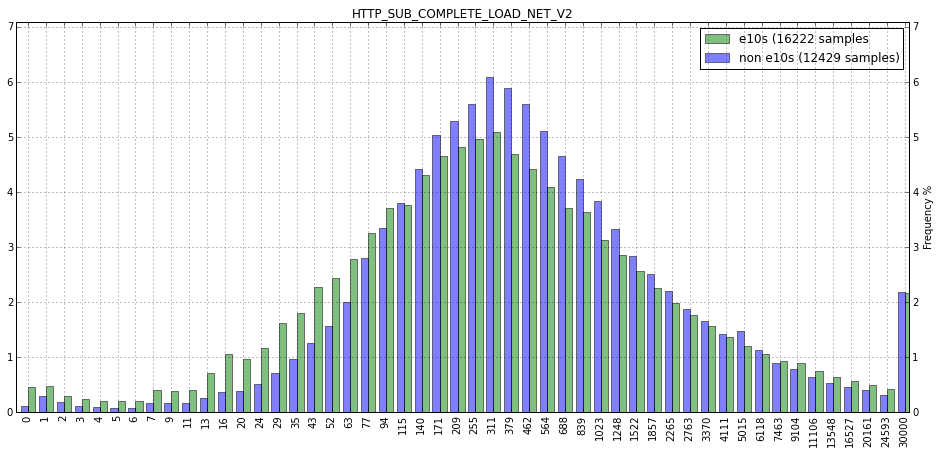

The chi2 distance for COOKIE_SCHEME_SECURITY is 0.0186035120856


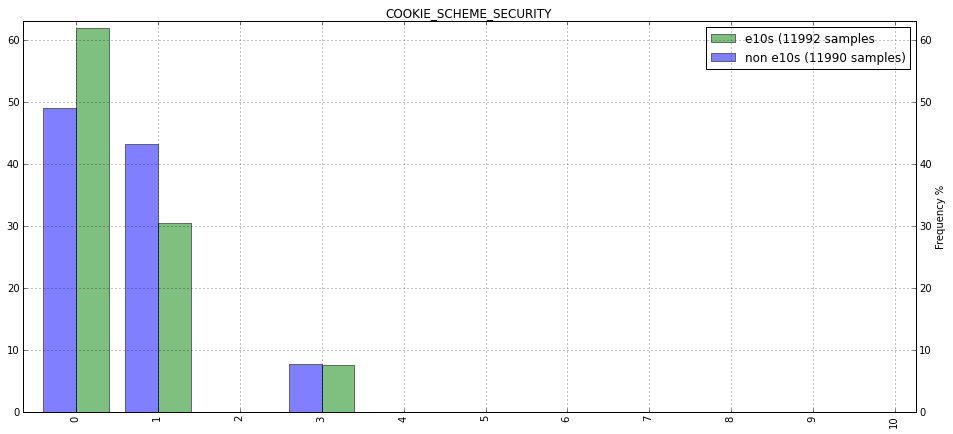

The chi2 distance for MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED is 0.0183965472143


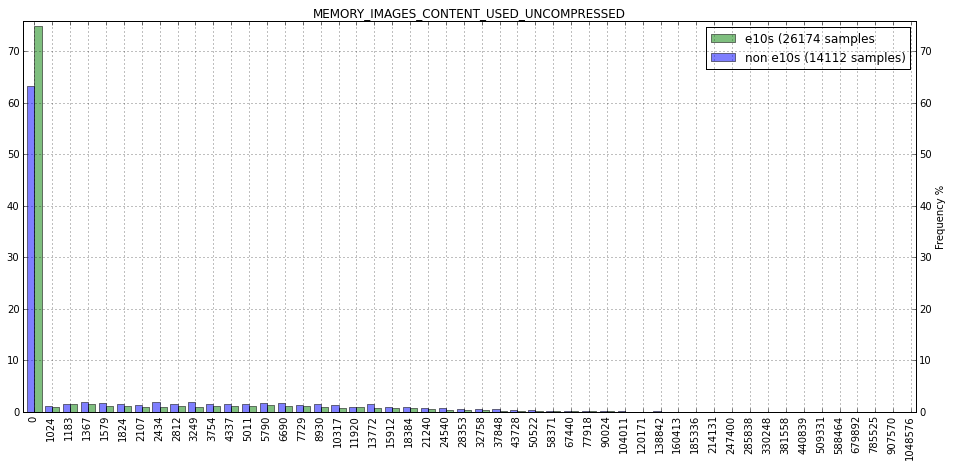

The chi2 distance for HTTP_PAGE_REVALIDATION is 0.0176699525714


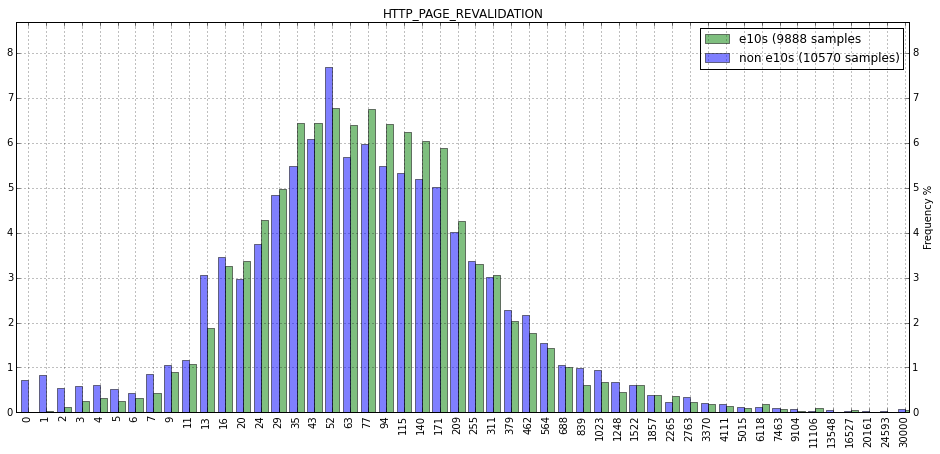

The chi2 distance for PREDICTOR_PREDICT_TIME_TO_INACTION is 0.0166021453761


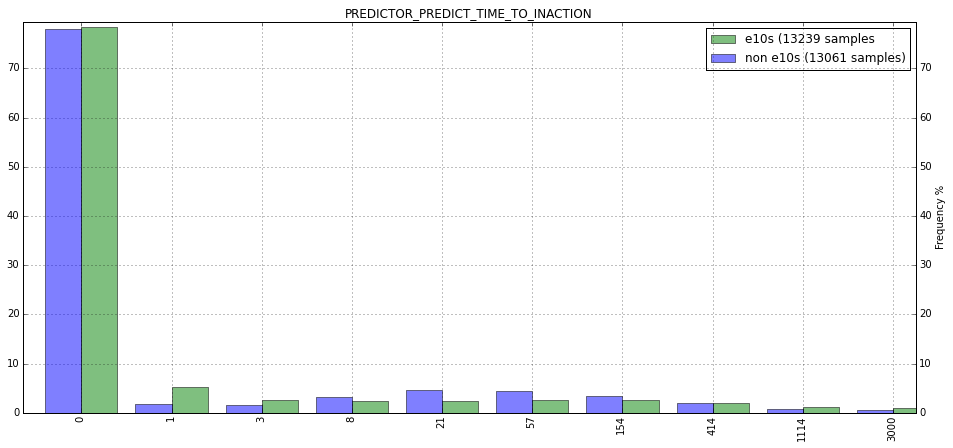

The chi2 distance for TRANSACTION_WAIT_TIME_HTTP is 0.0163785601972


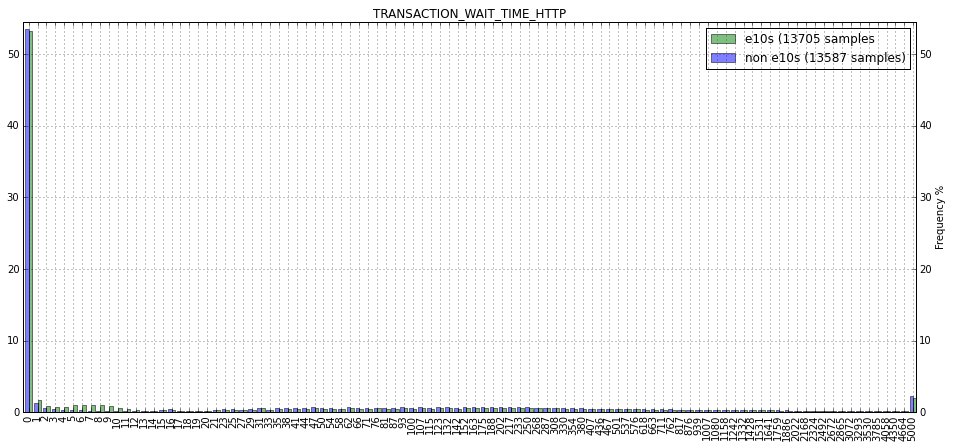

The chi2 distance for PREDICTOR_PREDICT_TIME_TO_ACTION is 0.0158341537301


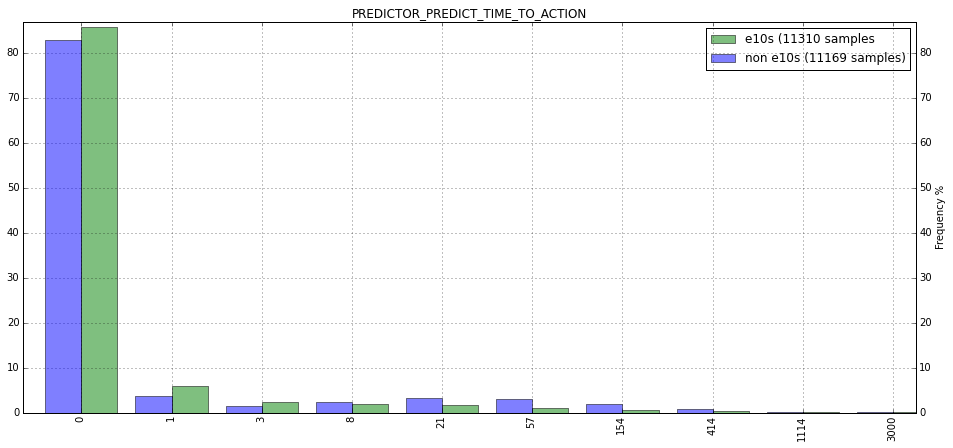

The chi2 distance for [[COUNT]]_CONTENT_DOCUMENTS_DESTROYED is 0.015345182516


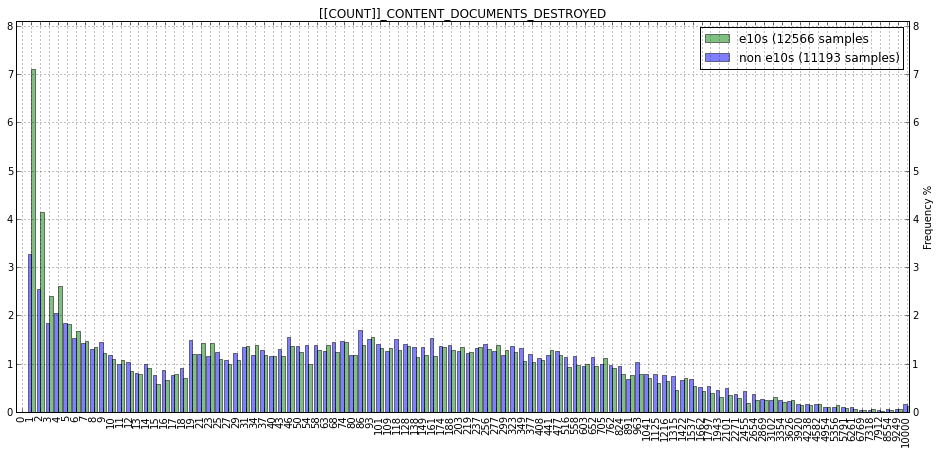

The chi2 distance for GC_ANIMATION_MS is 0.0152251931486


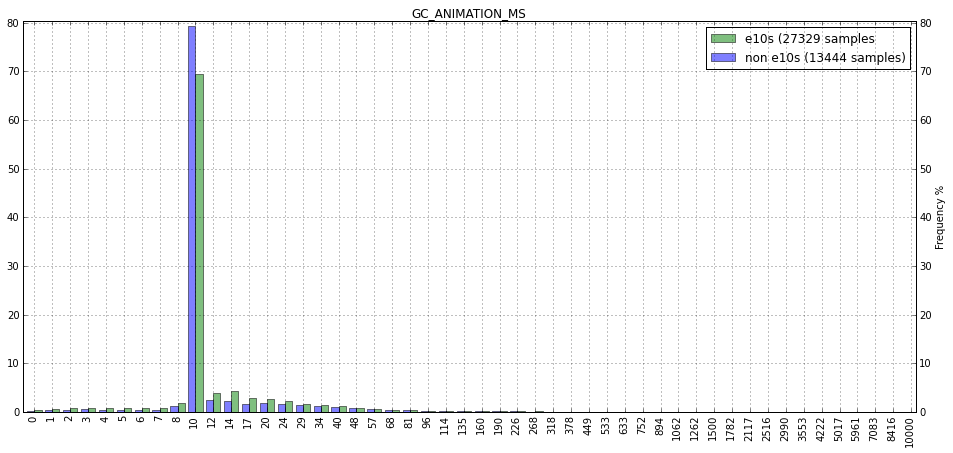

The chi2 distance for FORGET_SKIPPABLE_MAX is 0.0149451834341


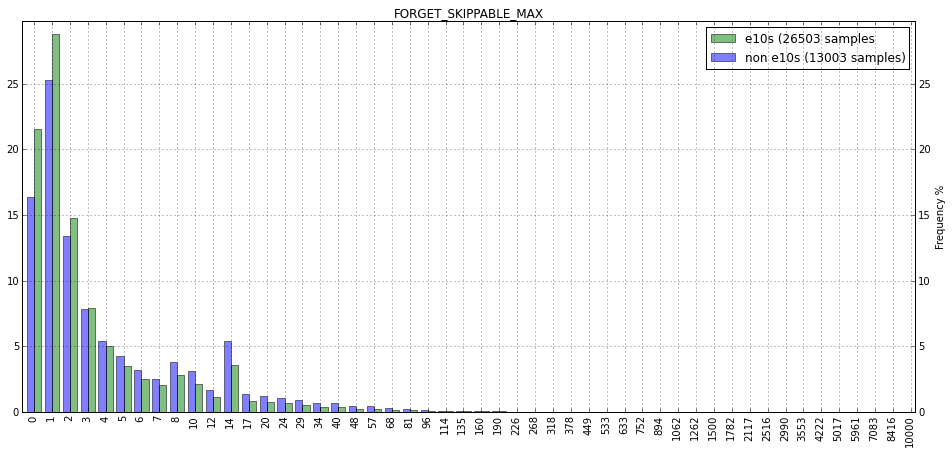

The chi2 distance for FX_THUMBNAILS_STORE_TIME_MS is 0.0149113439054


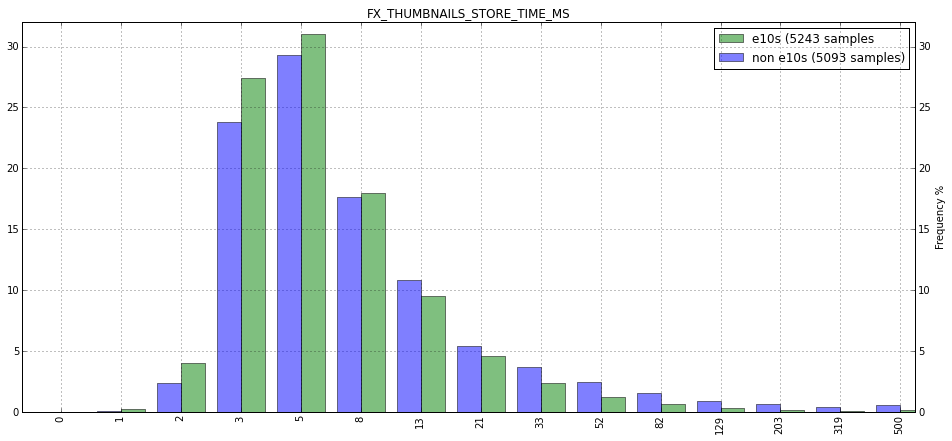

The chi2 distance for NEWTAB_PAGE_LIFE_SPAN is 0.0146297461674


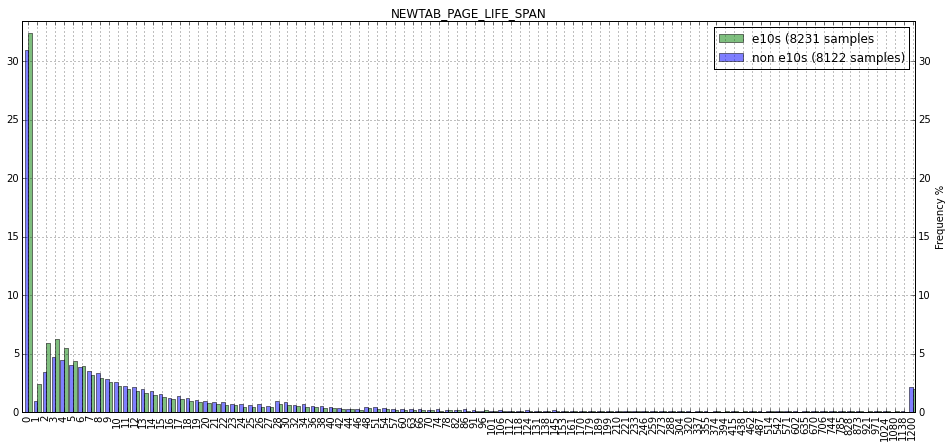

The chi2 distance for STS_NUMBER_OF_ONSOCKETREADY_CALLS is 0.0142837064142


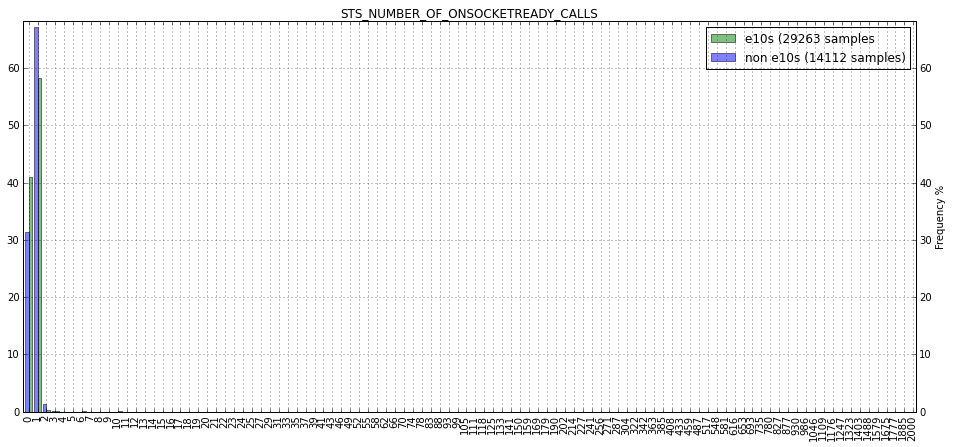

The chi2 distance for PREDICTOR_PREDICT_WORK_TIME is 0.0141869453253


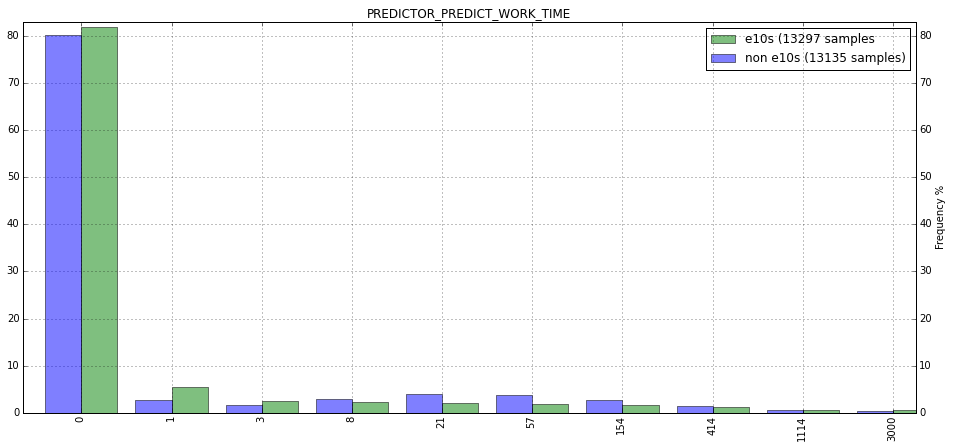

The chi2 distance for FXA_CONFIGURED is 0.0136899507545


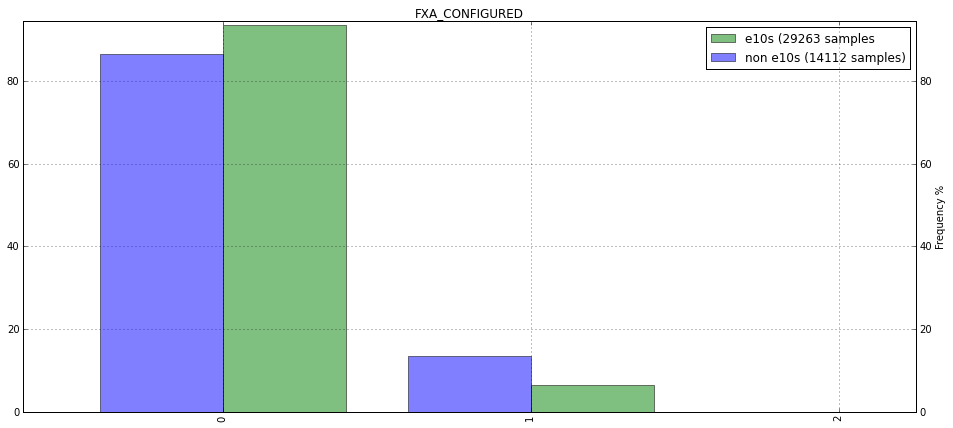

The chi2 distance for HEALTHREPORT_INIT_MS is 0.0127982309485


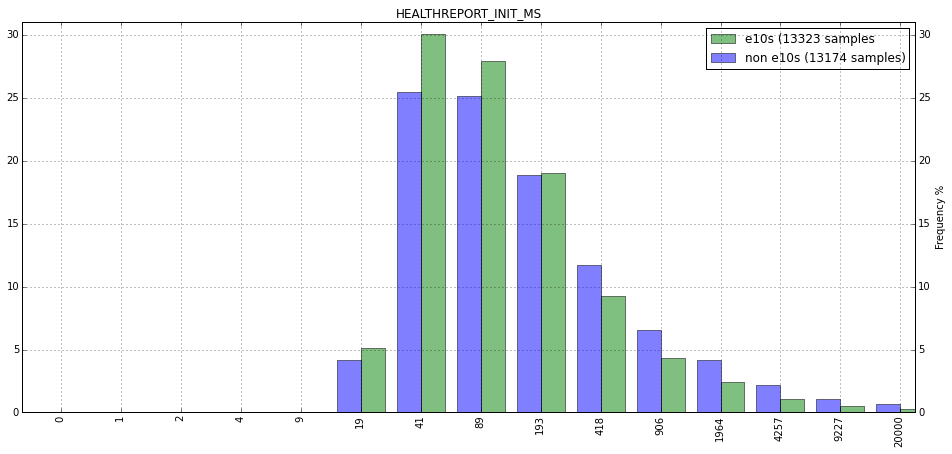

The chi2 distance for CYCLE_COLLECTOR_COLLECTED is 0.0127316623019


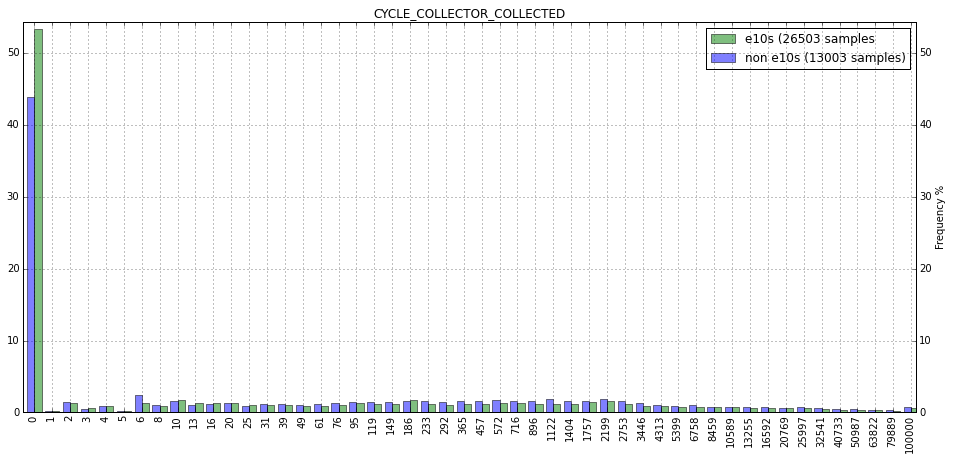

The chi2 distance for GC_SLOW_PHASE is 0.012234636523


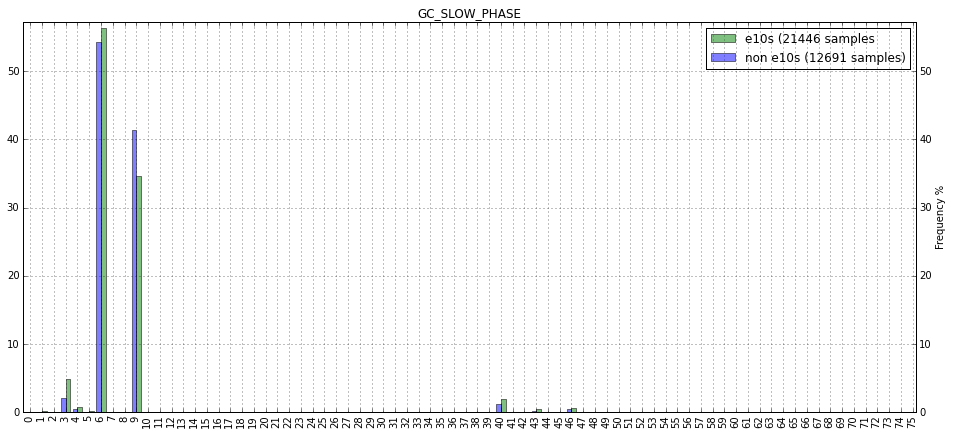

The chi2 distance for IMAGE_DECODE_COUNT is 0.0122118192741


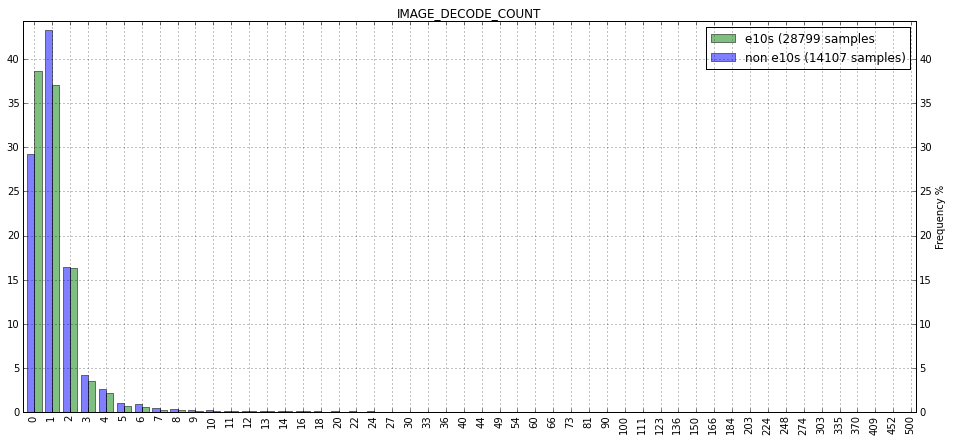

The chi2 distance for CYCLE_COLLECTOR_MAX_PAUSE is 0.0120156794906


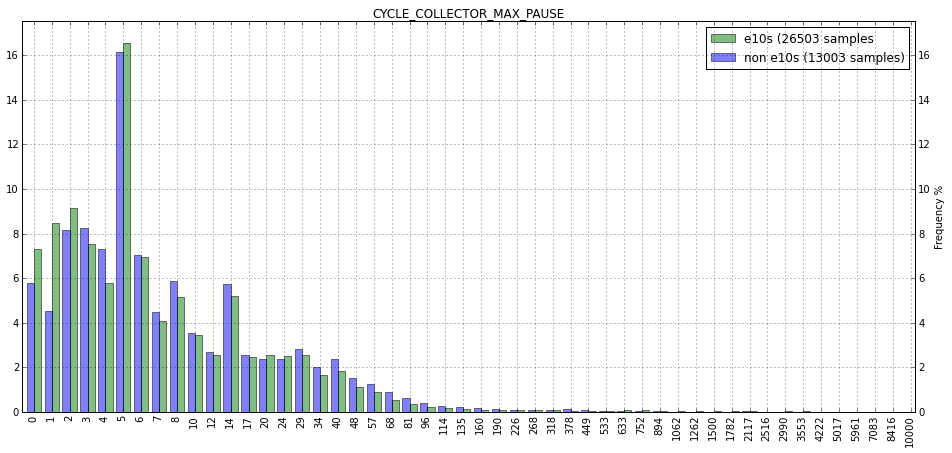

The chi2 distance for FLASH_PLUGIN_WIDTH is 0.0119577364965


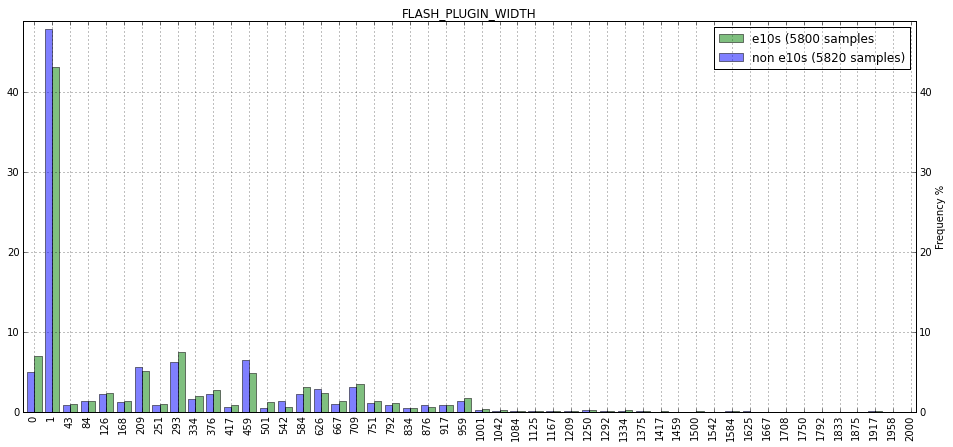

The chi2 distance for HTTP_PAGE_OPEN_TO_FIRST_RECEIVED is 0.0115469384117


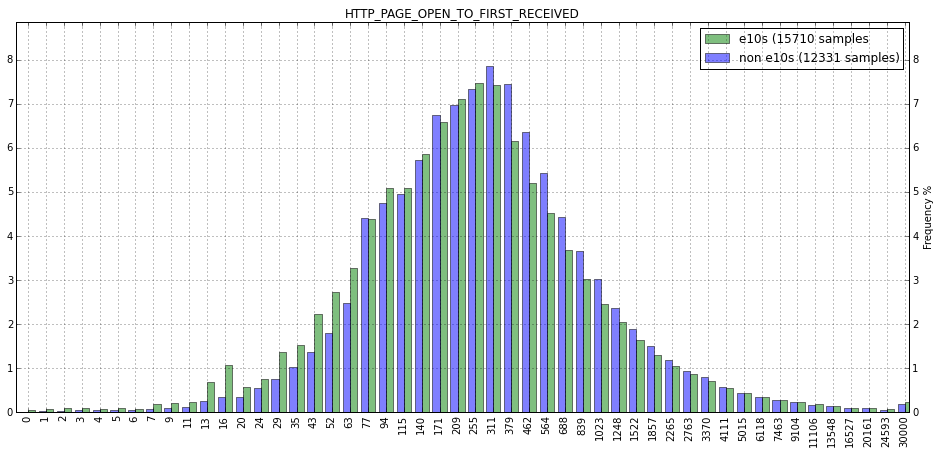

The chi2 distance for FX_SESSION_RESTORE_COLLECT_COOKIES_MS is 0.0114473709503


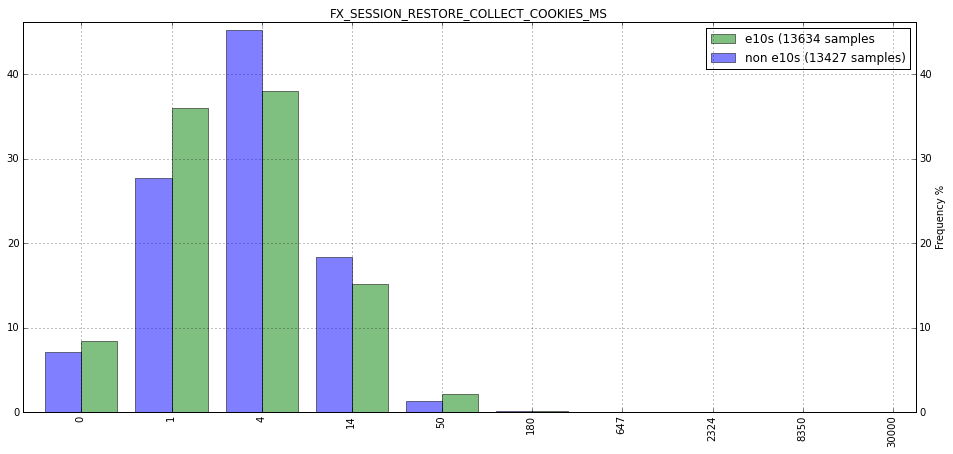

The chi2 distance for CYCLE_COLLECTOR_TIME_BETWEEN is 0.0113835615057


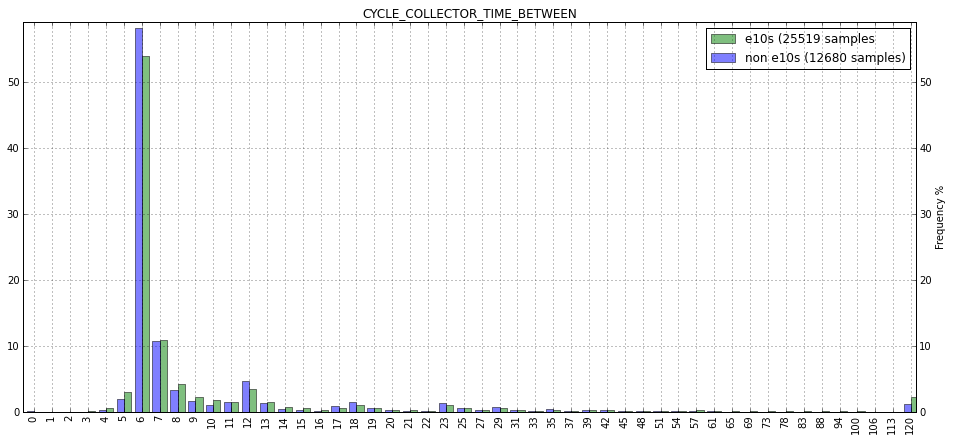

The chi2 distance for TELEMETRY_STRINGIFY is 0.0110872997369


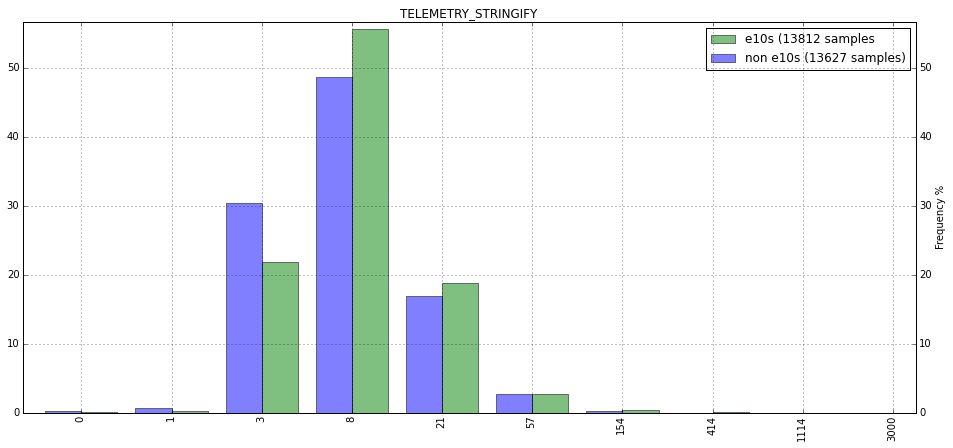

The chi2 distance for DEFERRED_FINALIZE_ASYNC is 0.0106729876235


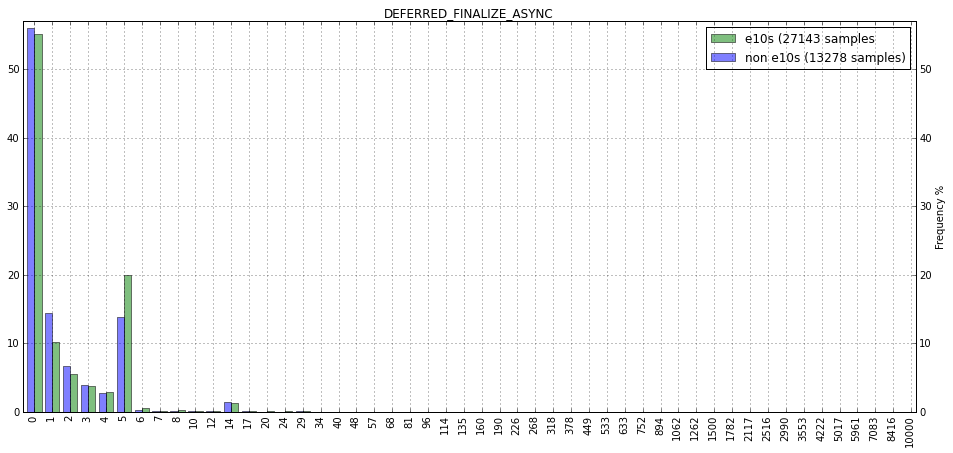

The chi2 distance for HTTP_SUB_TCP_CONNECTION is 0.0104948788449


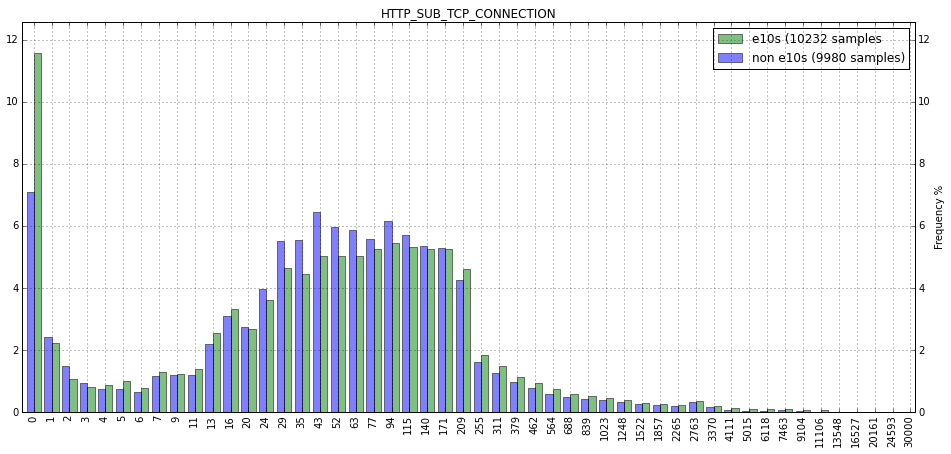

The chi2 distance for CRASH_STORE_COMPRESSED_BYTES is 0.010378769


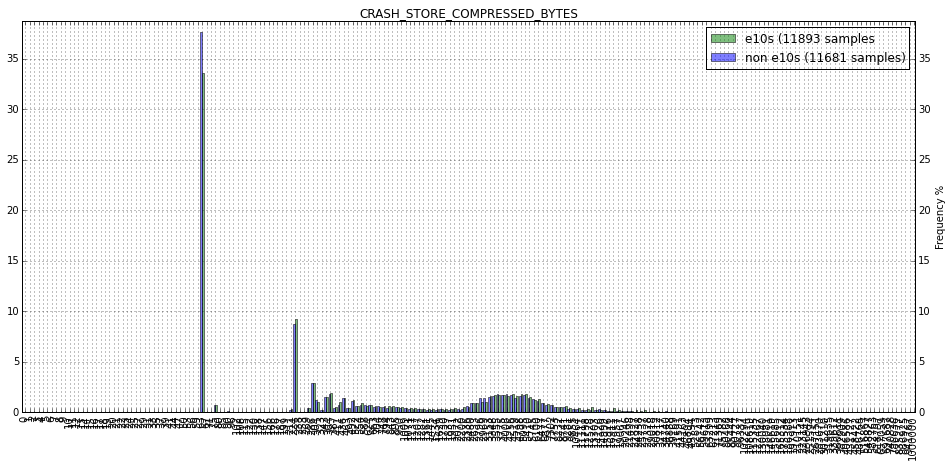

The chi2 distance for STS_NUMBER_OF_PENDING_EVENTS is 0.0100601041855


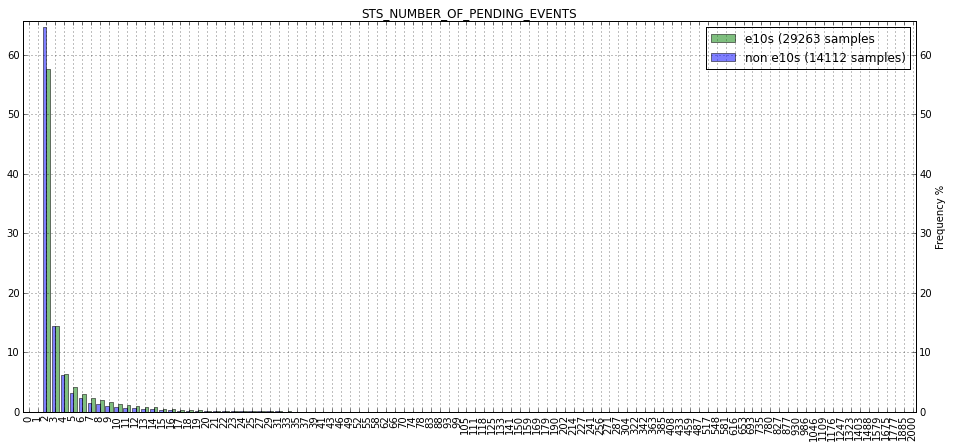

The chi2 distance for NETWORK_CACHE_METADATA_FIRST_READ_TIME_MS is 0.00993668994312


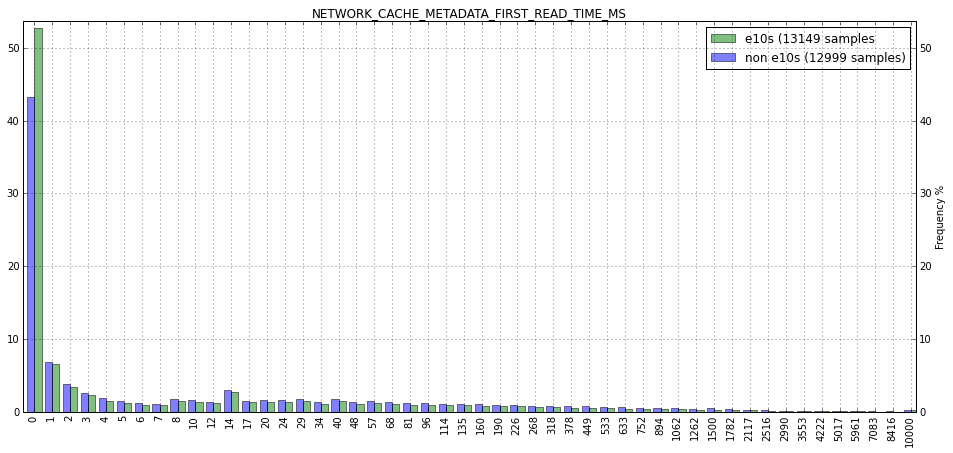

The chi2 distance for WEAVE_CAN_FETCH_KEYS is 0.00949930939733


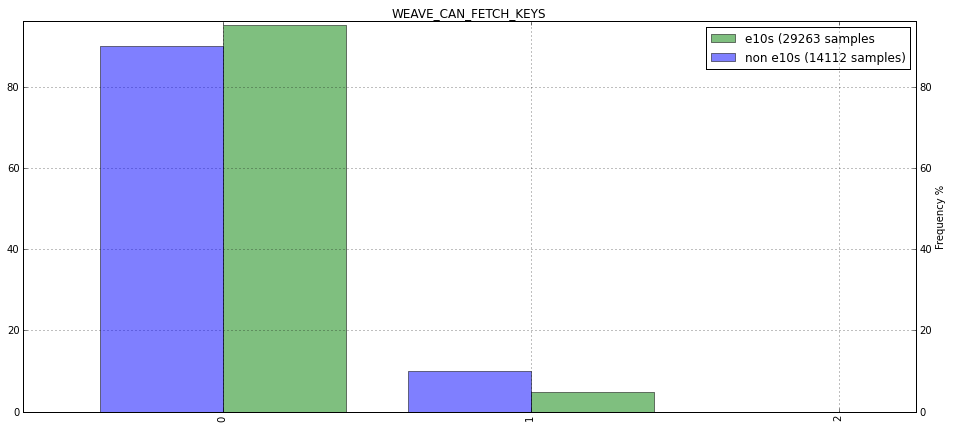

The chi2 distance for URL_PATH_CONTAINS_EXCLAMATION_SLASH is 0.00947303363241


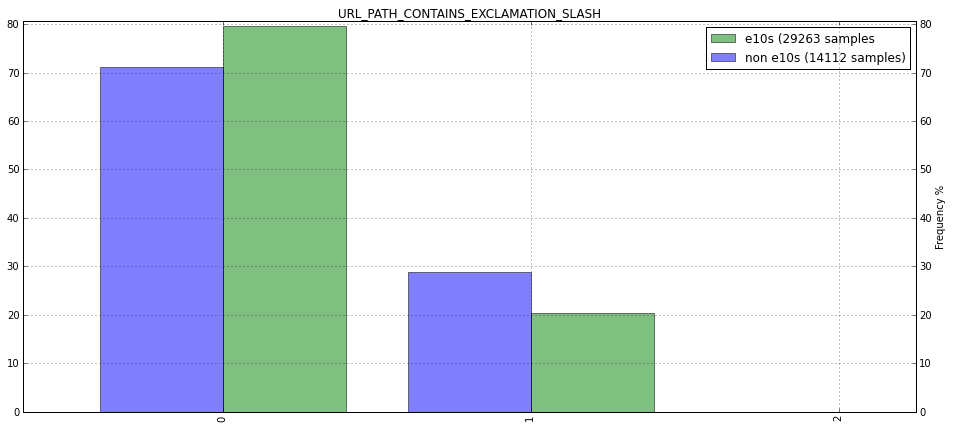

The chi2 distance for HTTP_PAGE_COMPLETE_LOAD_NET_V2 is 0.00928938046196


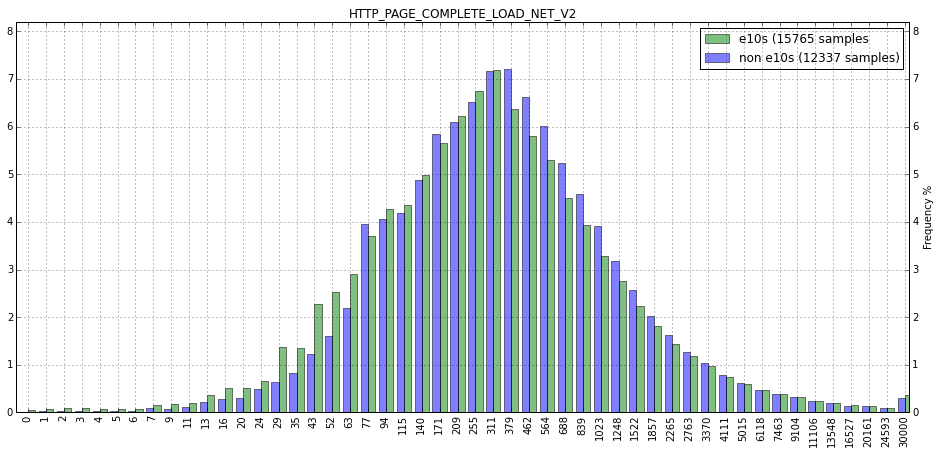

The chi2 distance for HTTP_PAGE_COMPLETE_LOAD_V2 is 0.00928938046196


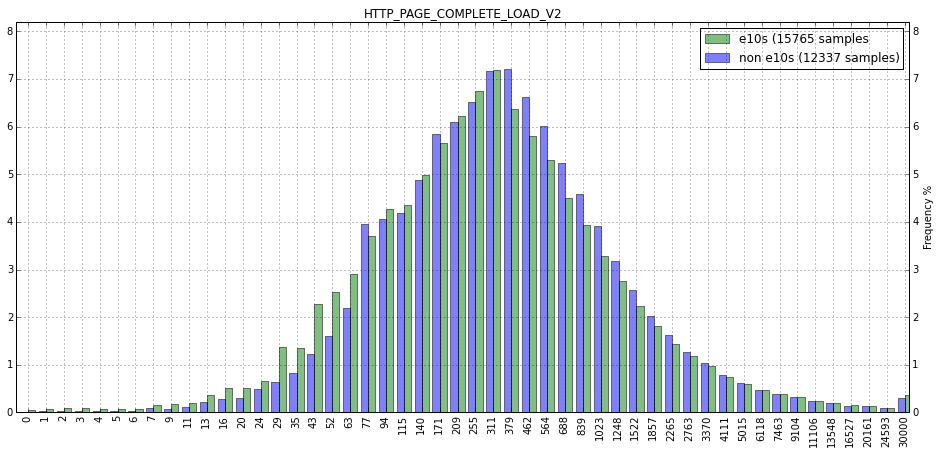

The chi2 distance for CERT_VALIDATION_HTTP_REQUEST_SUCCEEDED_TIME is 0.00924617856605


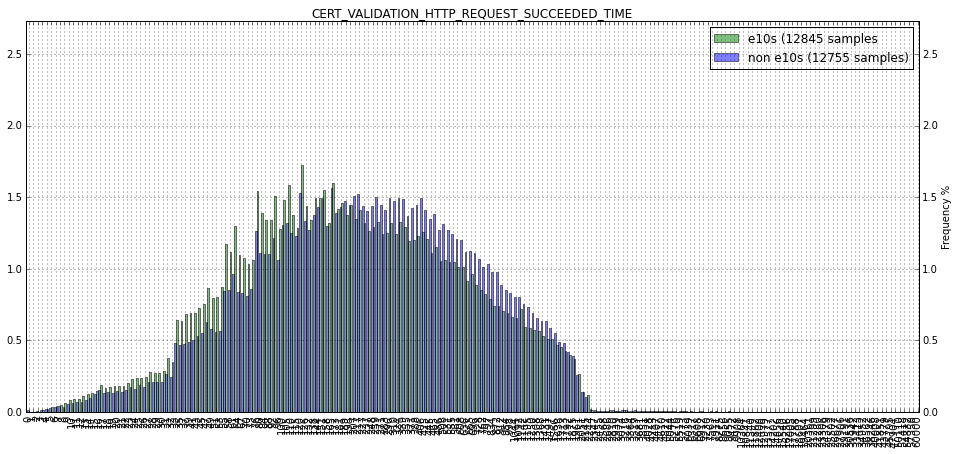

The chi2 distance for MEMORY_STORAGE_SQLITE is 0.0090996928026


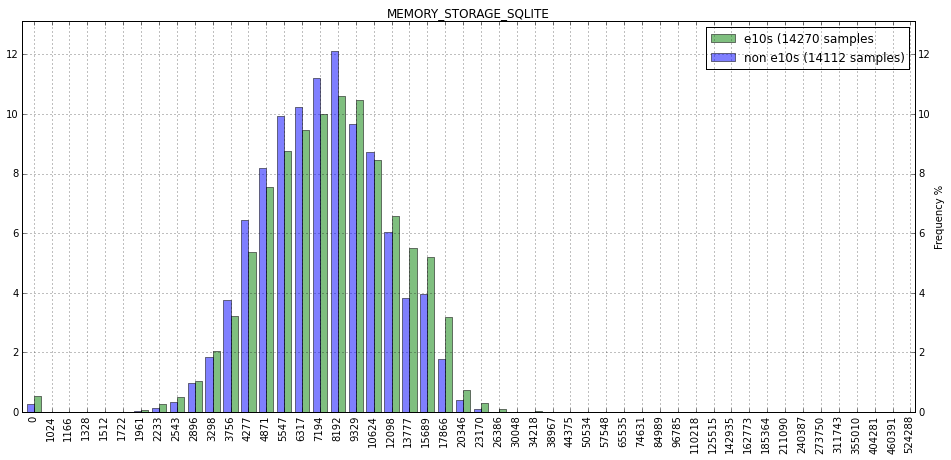

The chi2 distance for URLCLASSIFIER_LOOKUP_TIME is 0.00871558917784


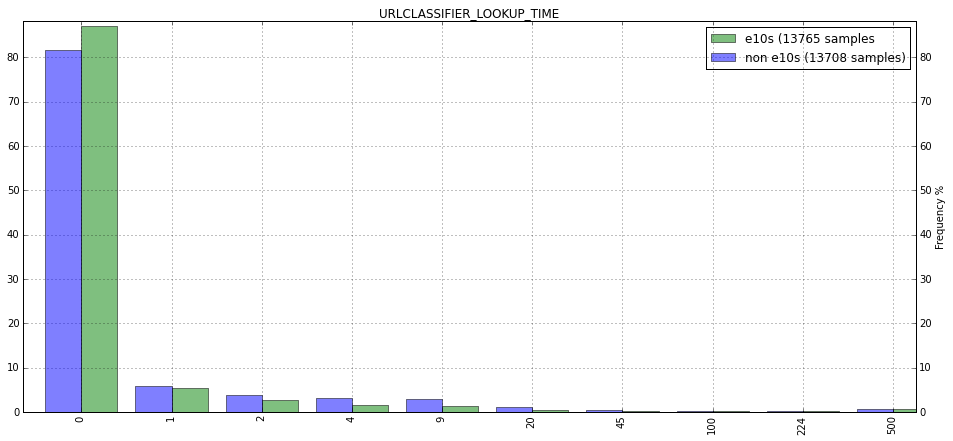

The chi2 distance for FLASH_PLUGIN_AREA is 0.00850106965924


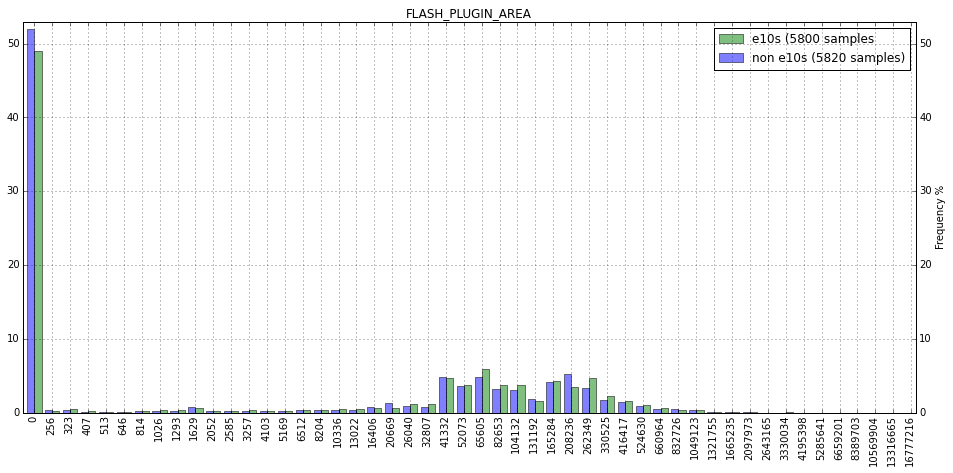

The chi2 distance for GRADIENT_DURATION is 0.008418170578


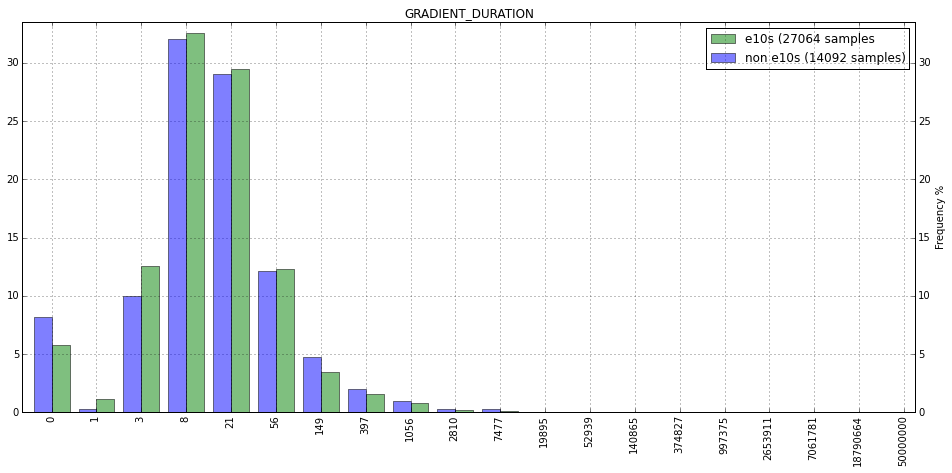

The chi2 distance for HEALTHREPORT_DB_OPEN_MS is 0.00840983160016


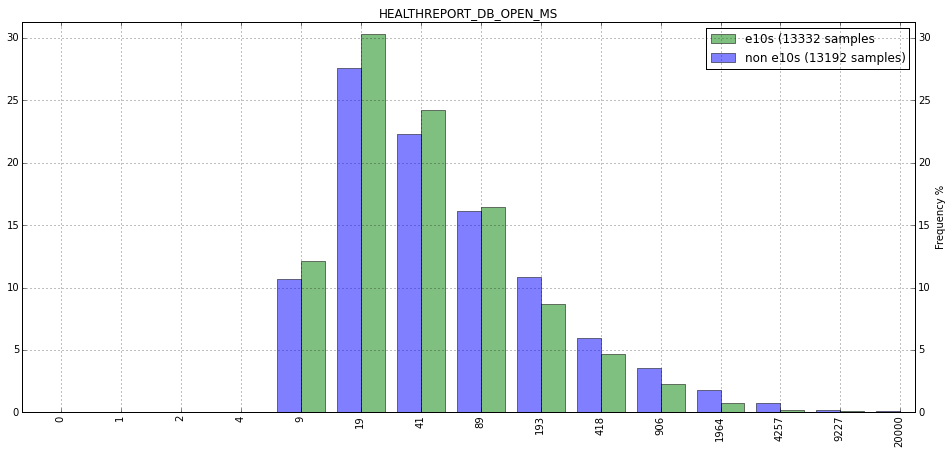

The chi2 distance for HEALTHREPORT_SHUTDOWN_MS is 0.00840633728529


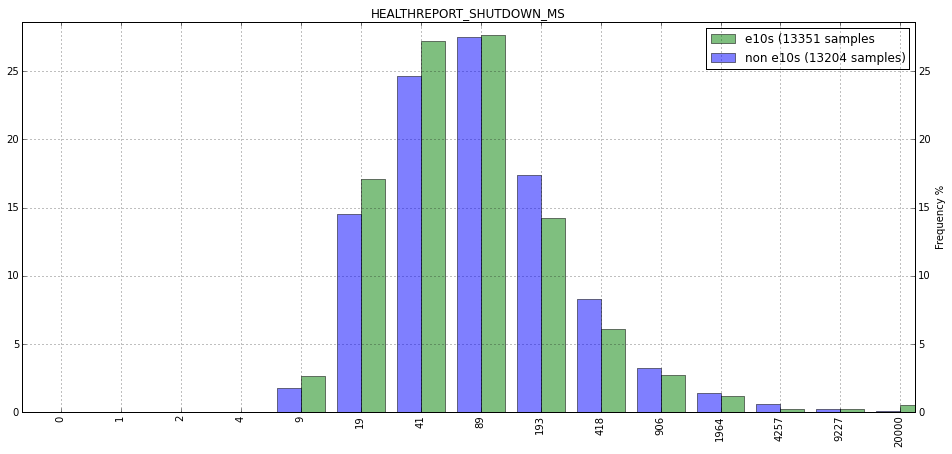

The chi2 distance for FLASH_PLUGIN_HEIGHT is 0.00815196565418


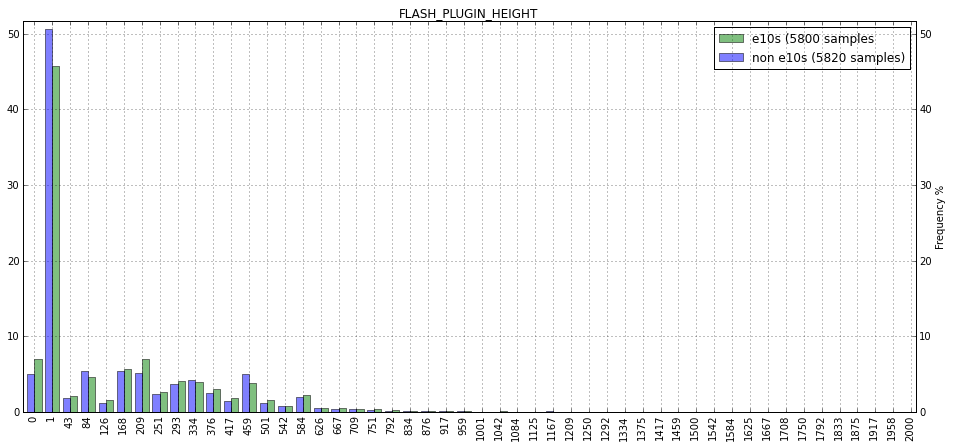

The chi2 distance for NETWORK_CACHE_V2_HIT_TIME_MS is 0.00807881028316


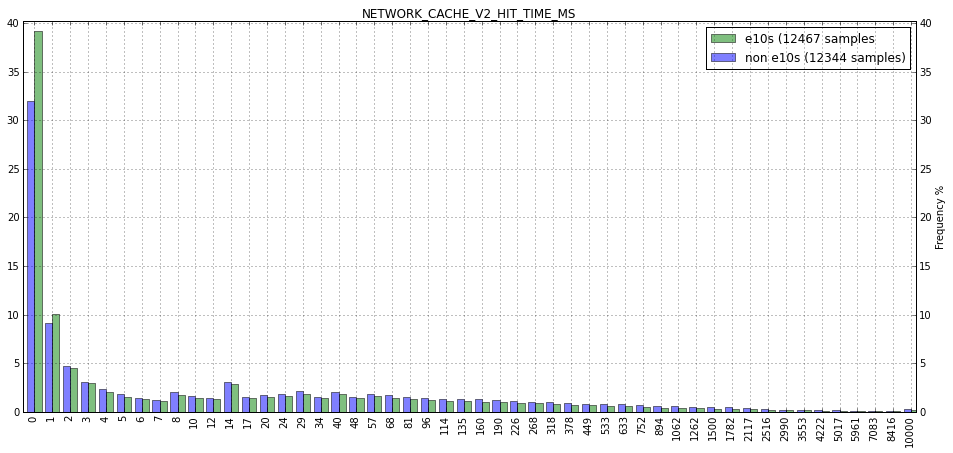

The chi2 distance for IMAGE_DECODE_SPEED_GIF is 0.00773555271139


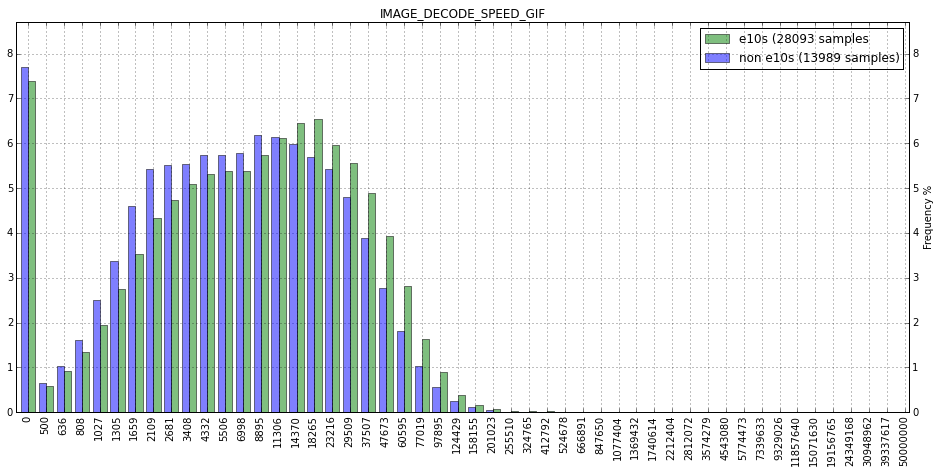

The chi2 distance for DWRITEFONT_DELAYEDINITFONTLIST_TOTAL is 0.00768972131433


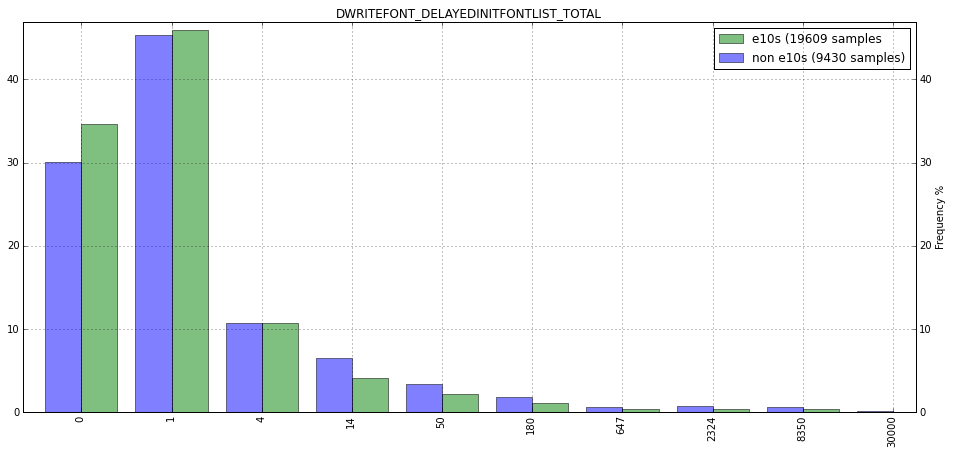

The chi2 distance for SIMPLE_MEASURES_STARTUPSESSIONRESTOREWRITEBYTES is 0.00767283969505


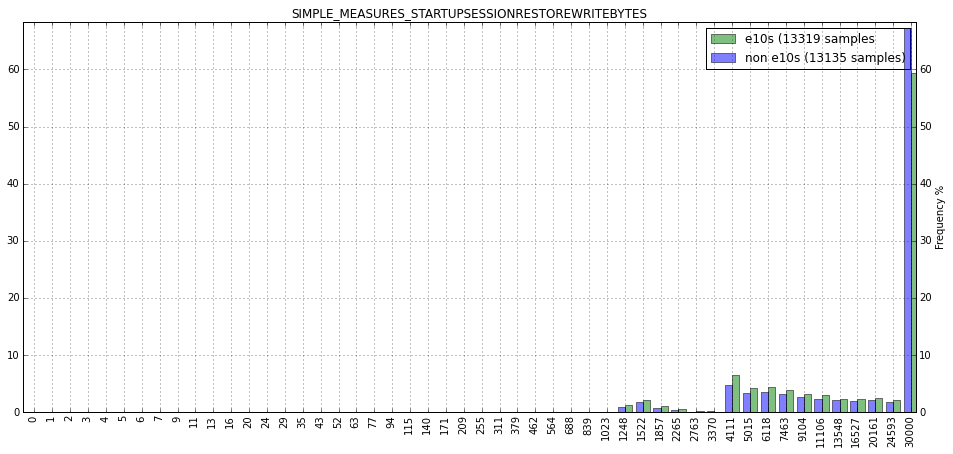

The chi2 distance for STS_POLL_AND_EVENT_THE_LAST_CYCLE is 0.00720912253097


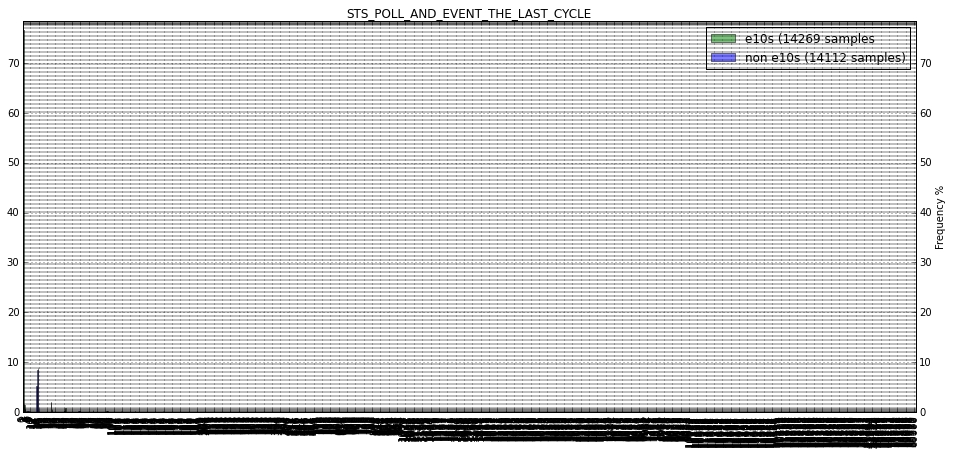

The chi2 distance for HTTP_CACHE_DISPOSITION_2_V2 is 0.00719484641611


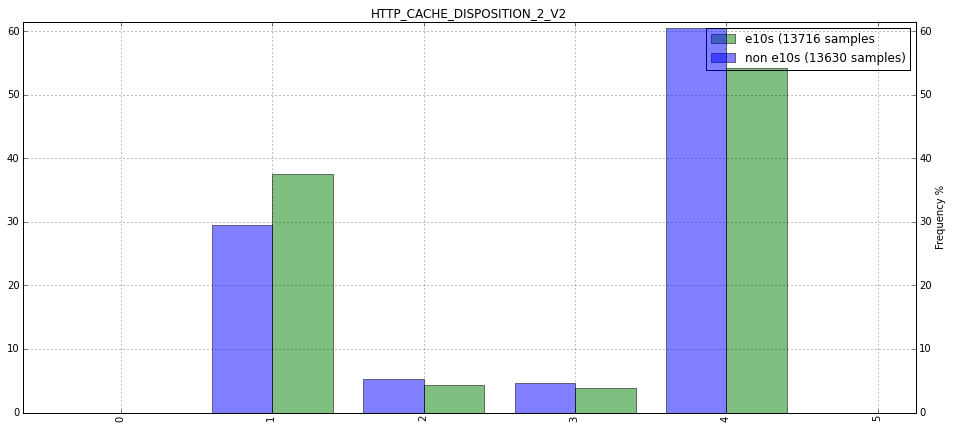

The chi2 distance for TELEMETRY_COMPRESS is 0.0071090911422


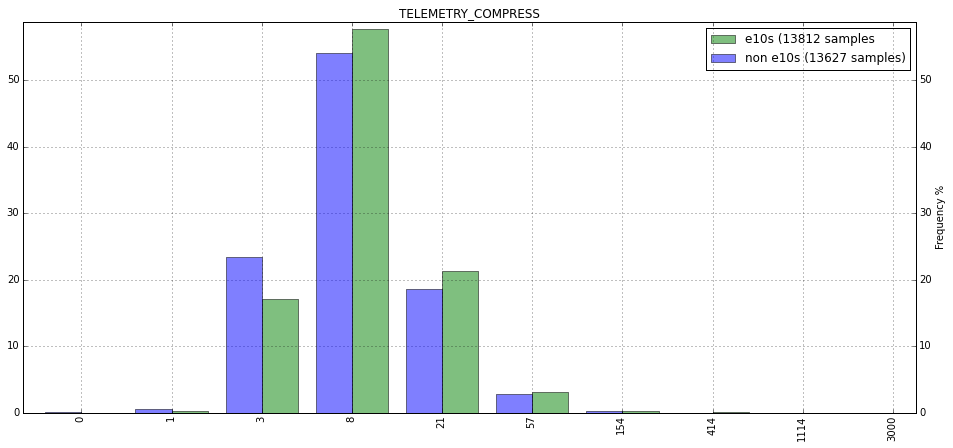

The chi2 distance for MOZ_SQLITE_OTHER_READ_B is 0.00708635878797


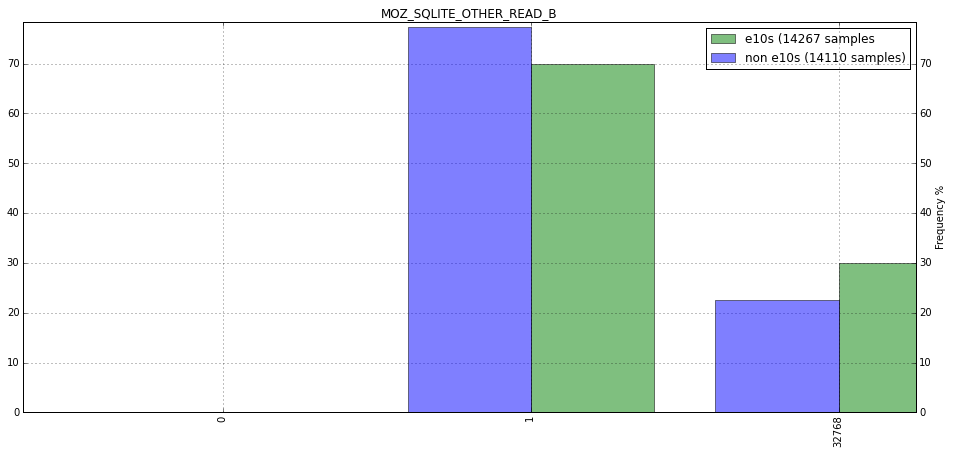

The chi2 distance for FX_SESSION_RESTORE_COLLECT_DATA_MS is 0.0068619650021


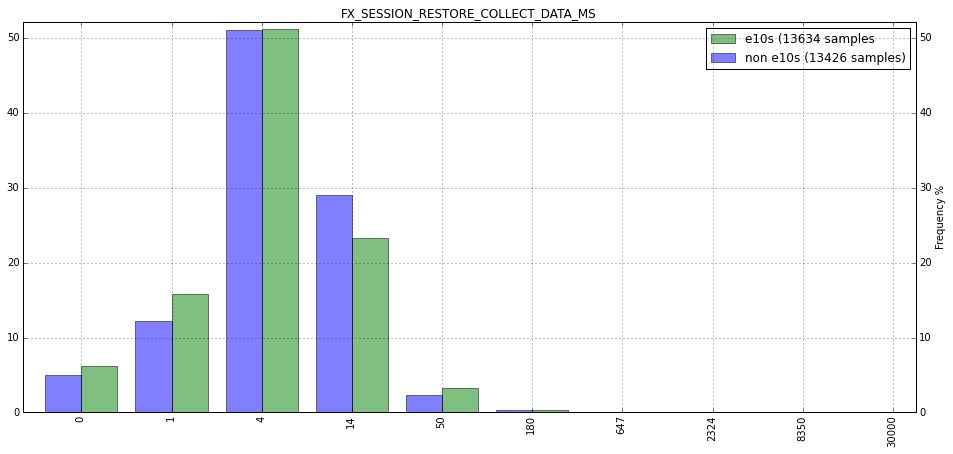

The chi2 distance for FX_SESSION_RESTORE_COLLECT_DATA_LONGEST_OP_MS is 0.00684494378345


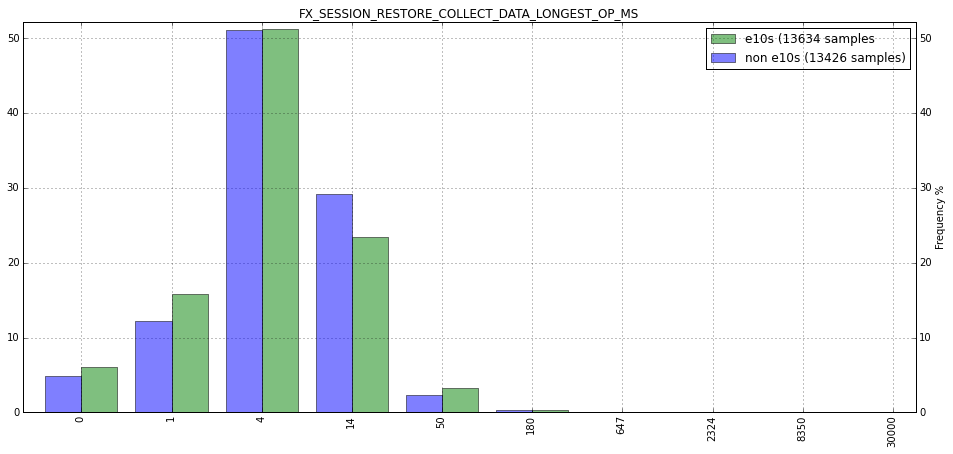

The chi2 distance for HTTP_PAGE_TCP_CONNECTION is 0.00662003472554


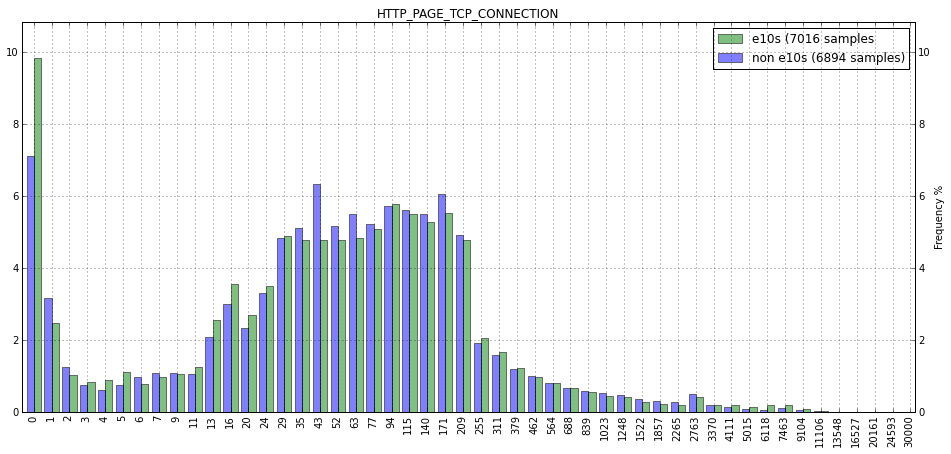

The chi2 distance for BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS is 0.00645692895445


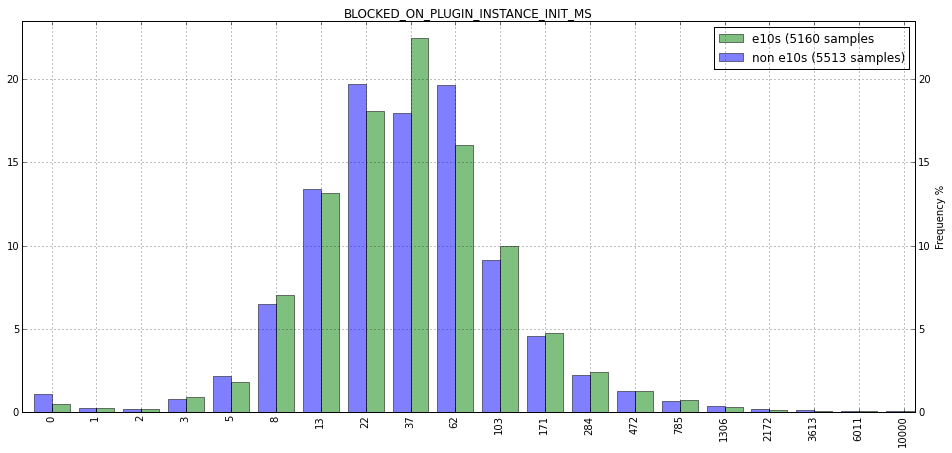

The chi2 distance for CACHE_SERVICE_LOCK_WAIT_2 is 0.00634793982436


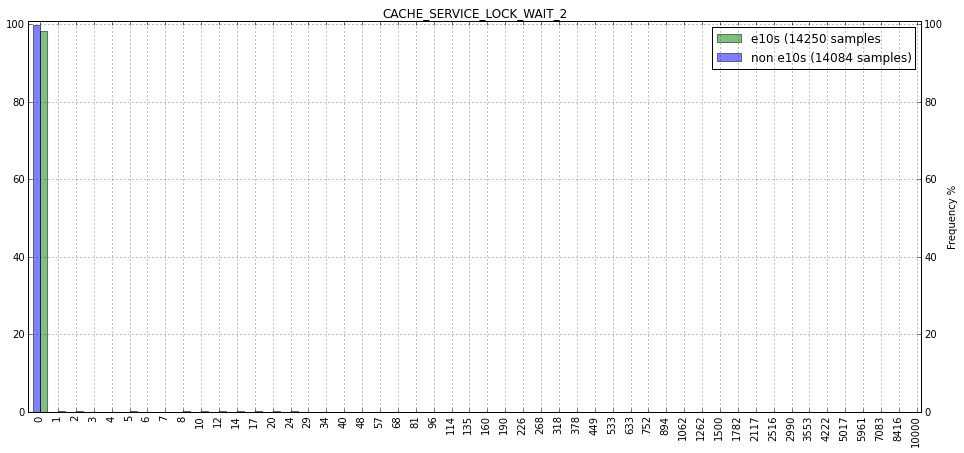

The chi2 distance for NETWORK_CACHE_METADATA_SECOND_READ_TIME_MS is 0.00620128777601


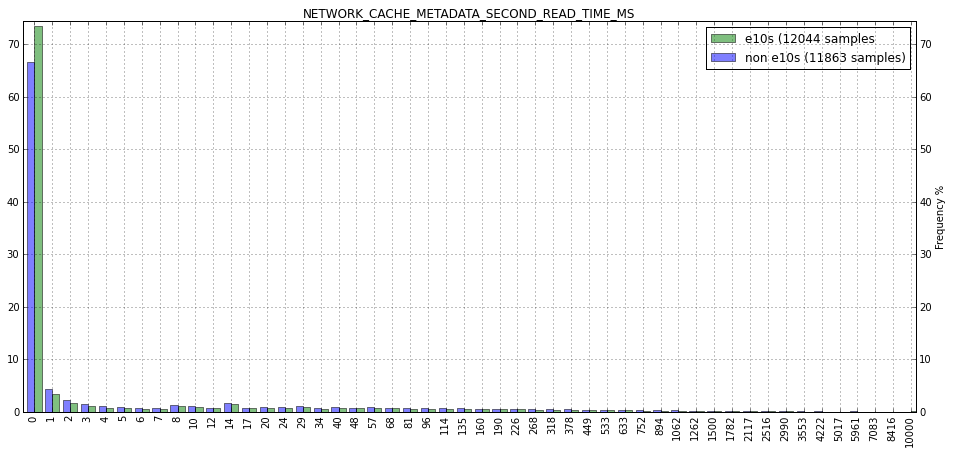

The chi2 distance for BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS is 0.00592160235572


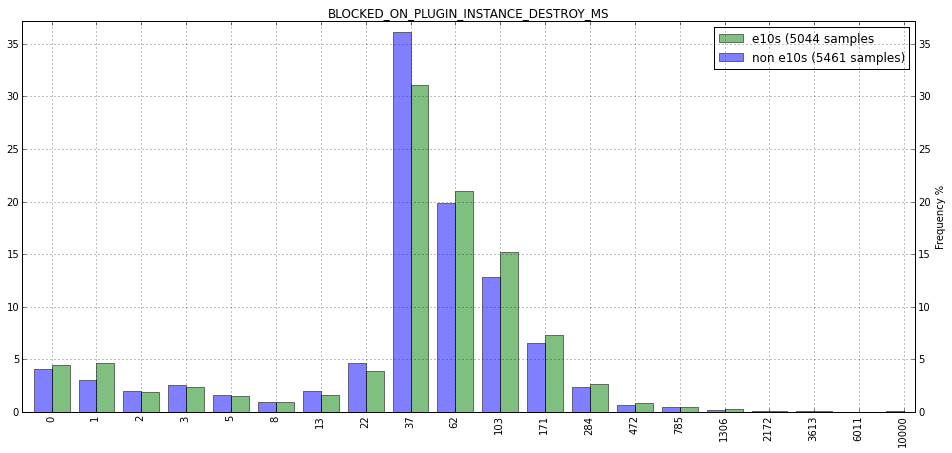

The chi2 distance for MOZ_SQLITE_OTHER_SYNC_MS is 0.0058198091287


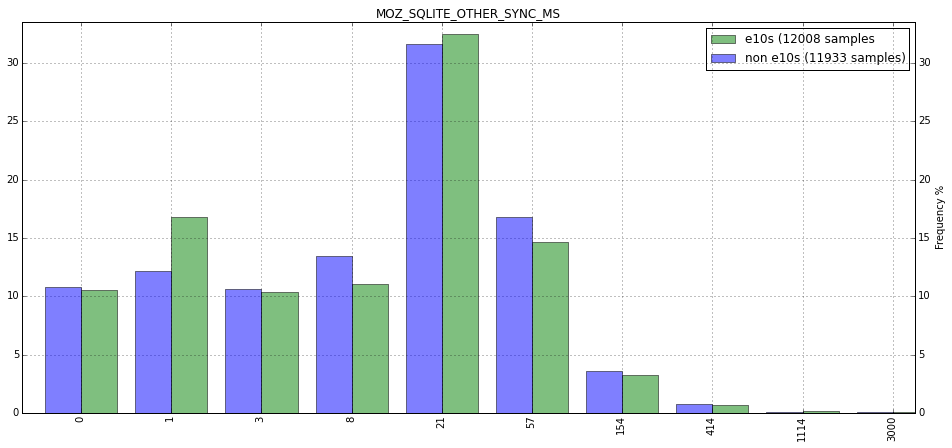

The chi2 distance for SSL_CIPHER_SUITE_RESUMED is 0.00579910298853


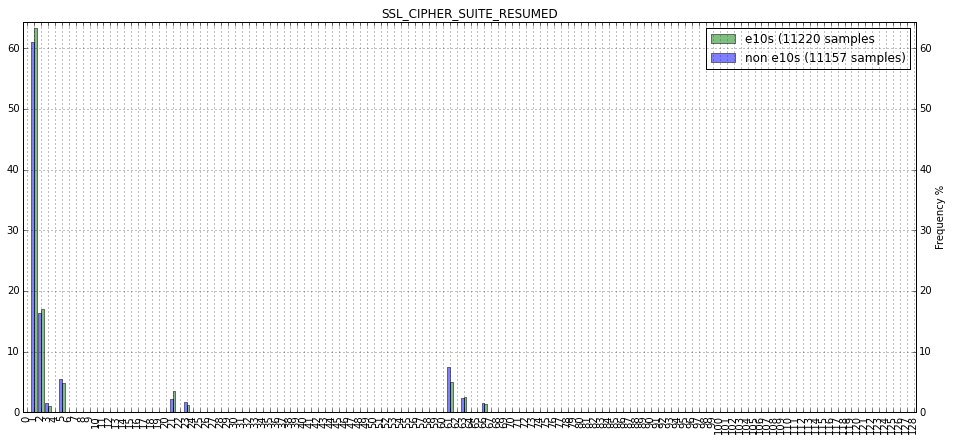

The chi2 distance for PWMGR_LOGIN_PAGE_SAFETY is 0.00535639239206


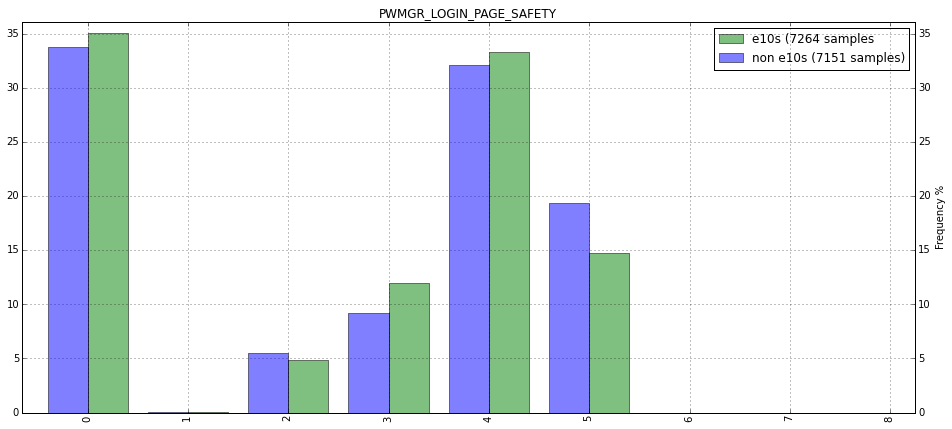

The chi2 distance for CYCLE_COLLECTOR_WORKER_VISITED_GCED is 0.00511545471972


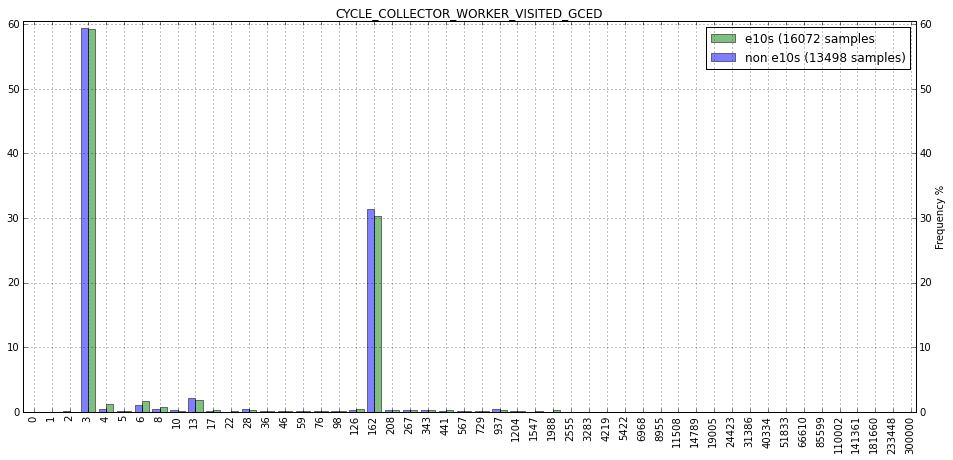

The chi2 distance for HTTP_CACHE_ENTRY_ALIVE_TIME is 0.00501601503842


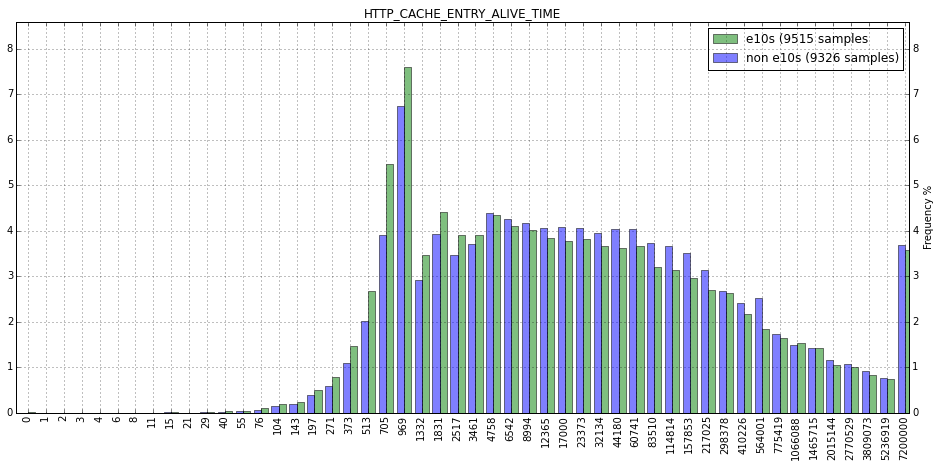

The chi2 distance for HTTP_SUB_FIRST_SENT_TO_LAST_RECEIVED is 0.00492770209194


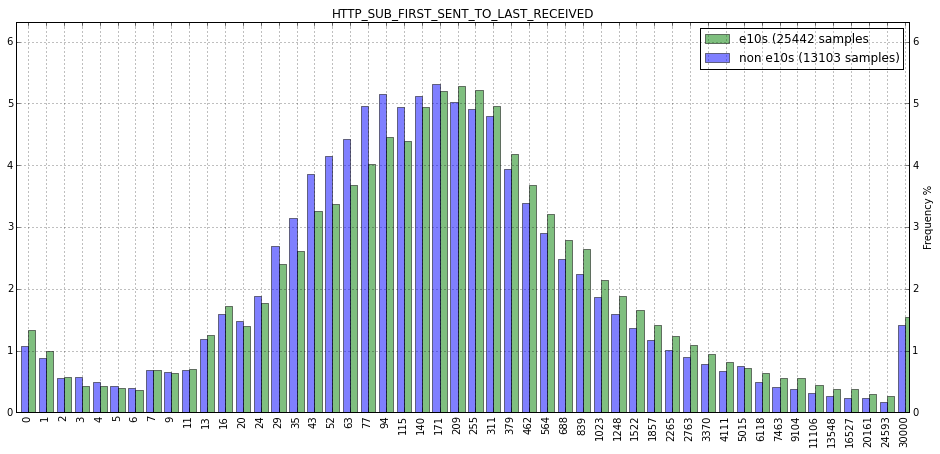

The chi2 distance for SSL_KEA_RSA_KEY_SIZE_FULL is 0.00468178122814


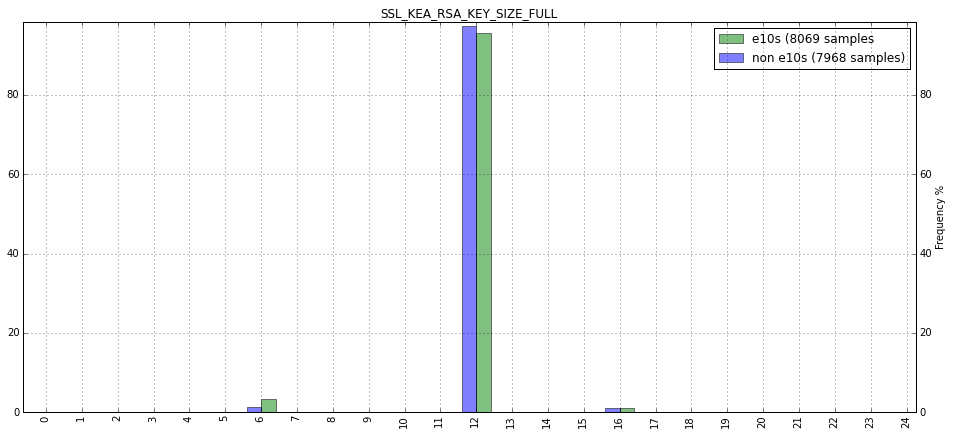

The chi2 distance for HTTP_CACHE_MISS_HALFLIFE_EXPERIMENT_2 is 0.00454628335504


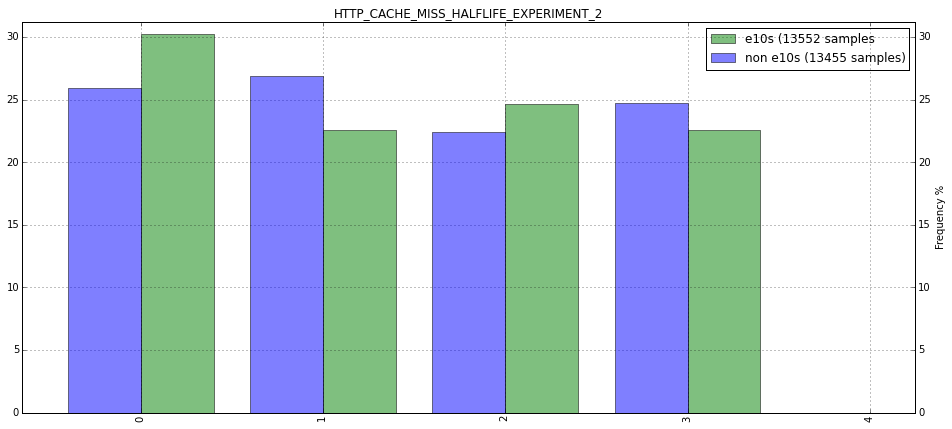

The chi2 distance for HTTP_SCHEME_UPGRADE is 0.00437277017146


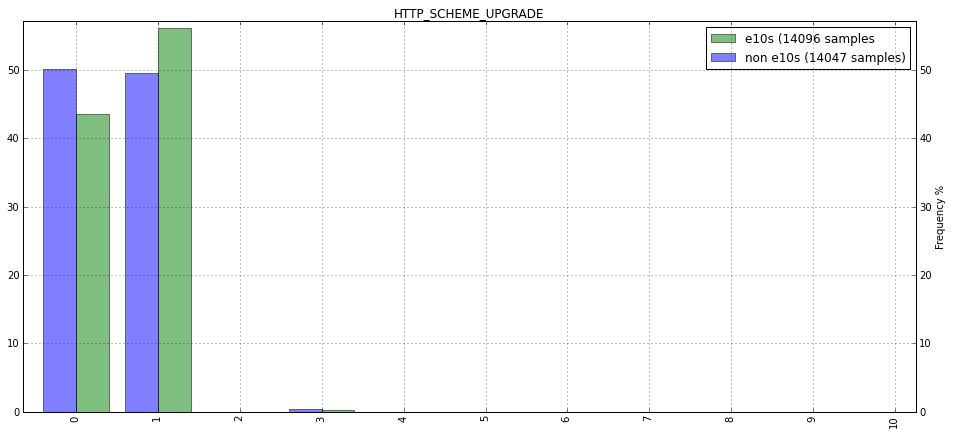

The chi2 distance for CERT_VALIDATION_HTTP_REQUEST_RESULT is 0.0041493162122


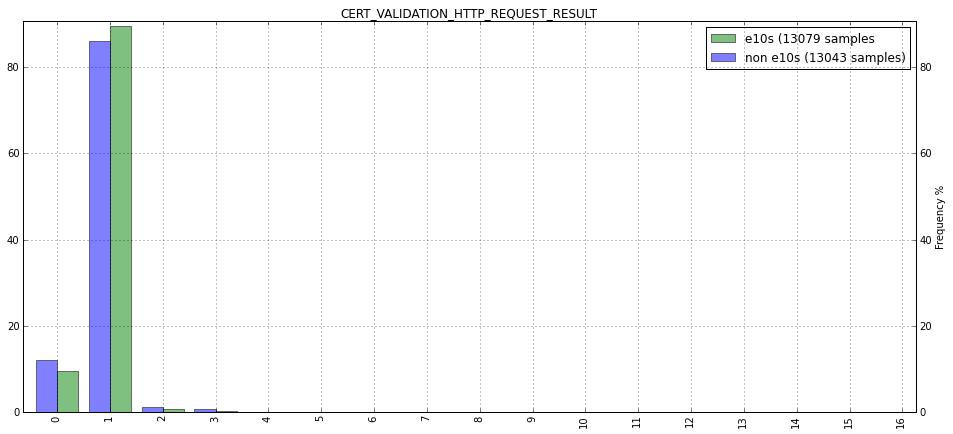

The chi2 distance for NETWORK_CACHE_HIT_MISS_STAT_PER_CACHE_SIZE is 0.00406553895778


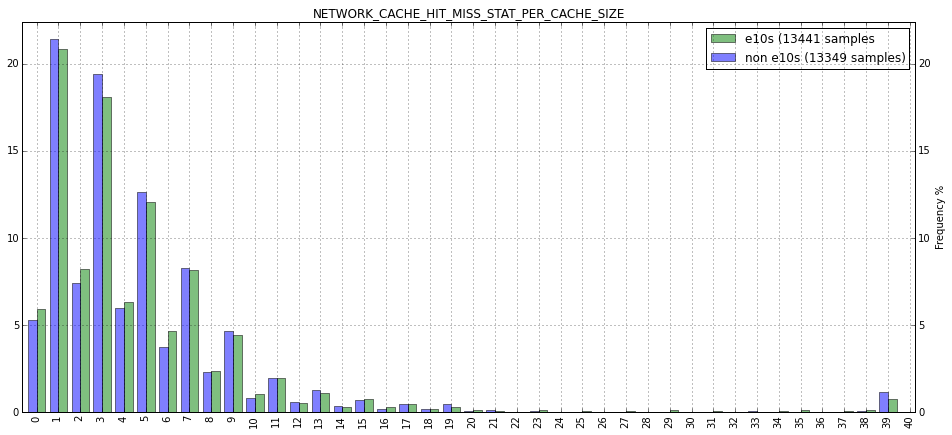

The chi2 distance for COMPOSITE_TIME is 0.00404294444892


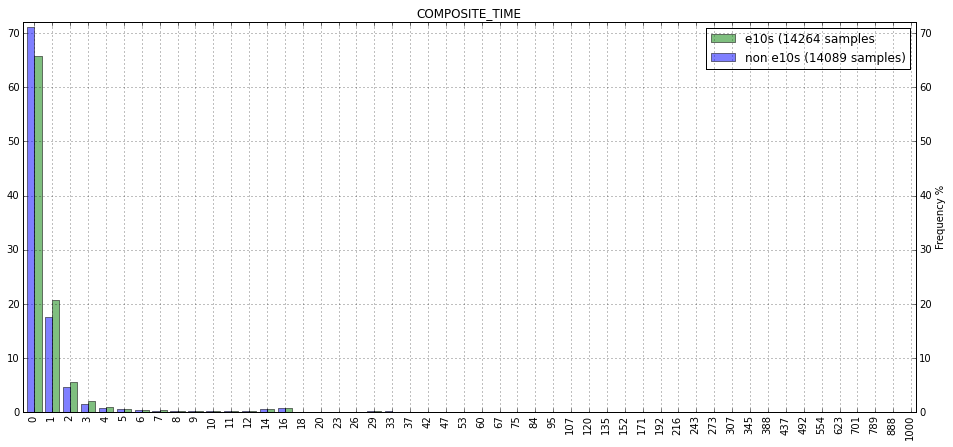

The chi2 distance for STS_NUMBER_OF_PENDING_EVENTS_IN_THE_LAST_CYCLE is 0.00390917245865


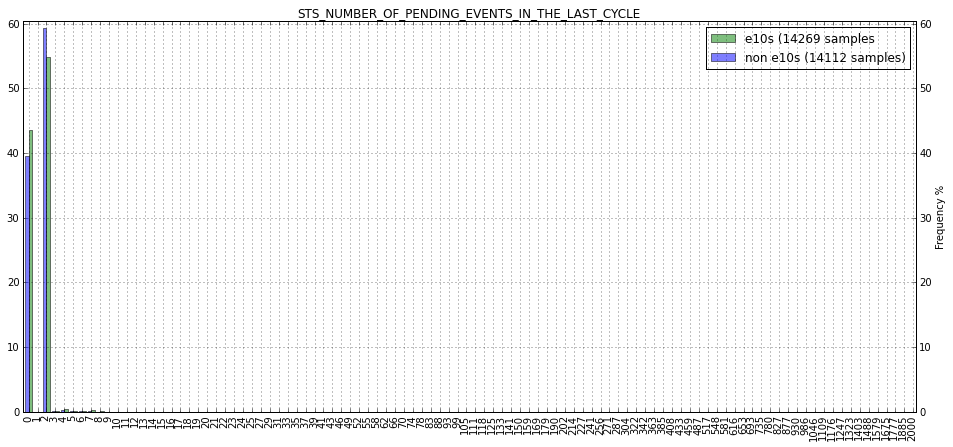

The chi2 distance for XMLHTTPREQUEST_ASYNC_OR_SYNC is 0.00377775002327


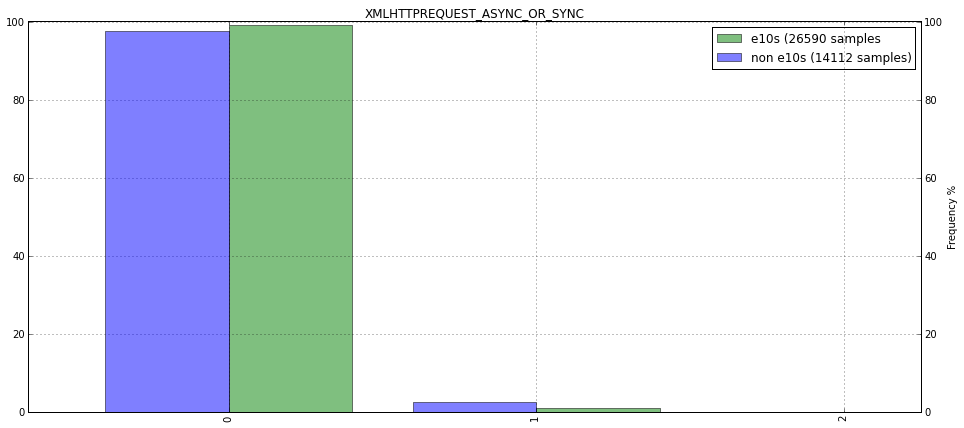

The chi2 distance for PREDICTOR_WAIT_TIME is 0.00366709095753


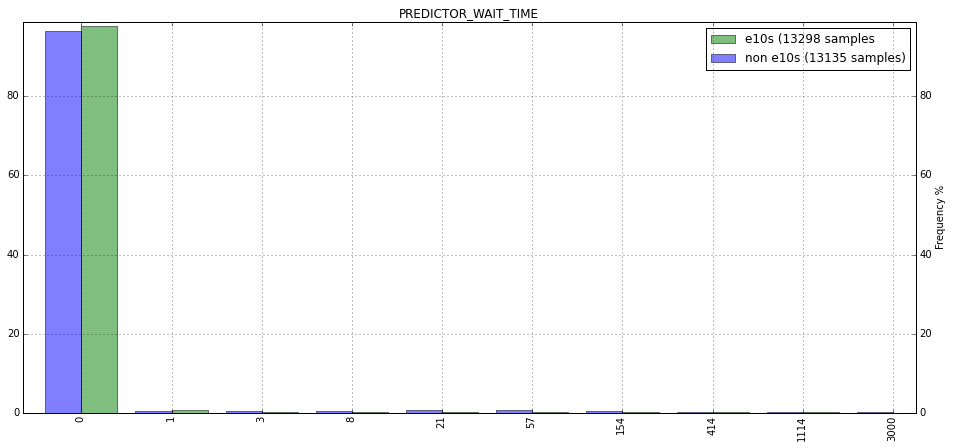

The chi2 distance for SYSTEM_FONT_FALLBACK_FIRST is 0.00357901830352


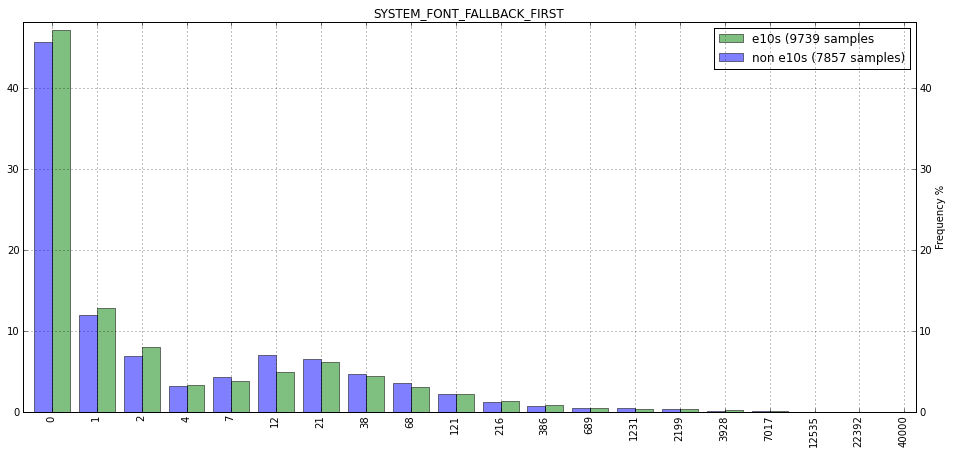

The chi2 distance for PREDICTOR_SUBRESOURCE_DEGRADATION is 0.00348376464371


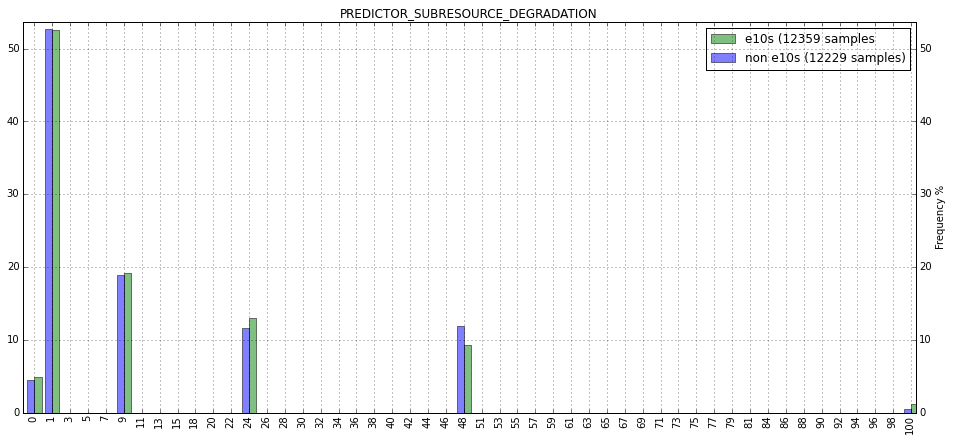

The chi2 distance for GC_NON_INCREMENTAL is 0.00344399208947


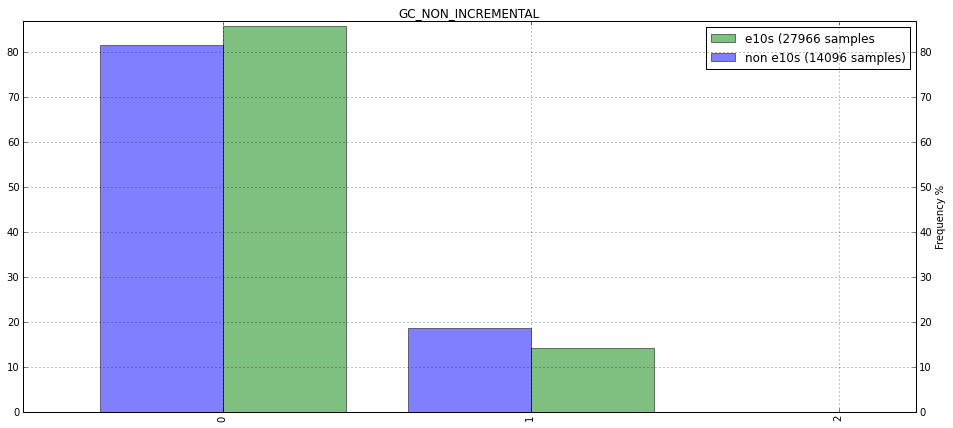

The chi2 distance for NETWORK_CACHE_METADATA_SIZE is 0.00343371358666


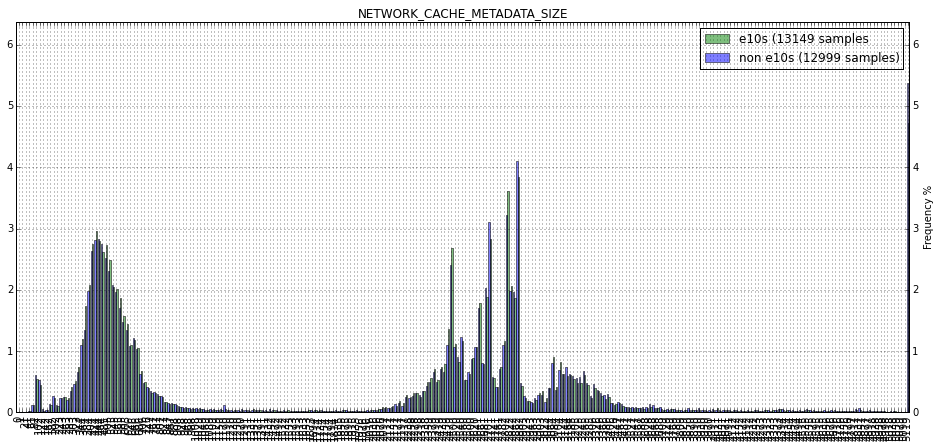

The chi2 distance for STARTUP_MOZ_SQLITE_COOKIES_OPEN_READAHEAD_MS is 0.0034116164268


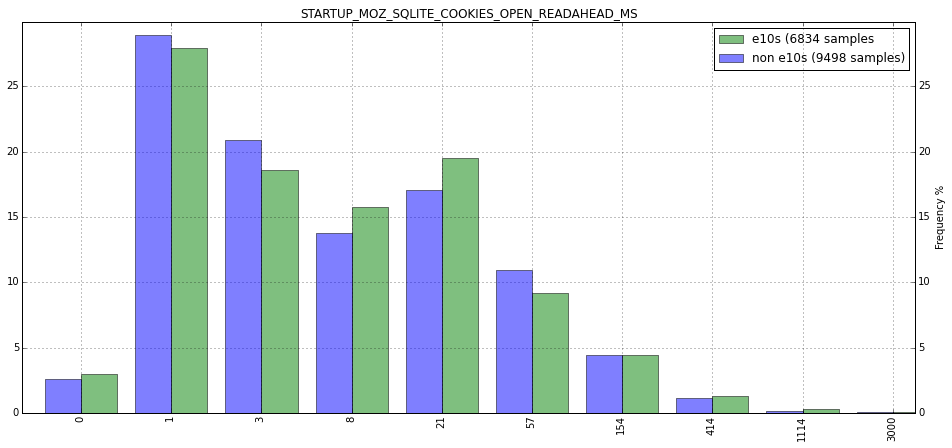

The chi2 distance for [[COUNT]]_TOP_LEVEL_CONTENT_DOCUMENTS_DESTROYED is 0.00337014465224


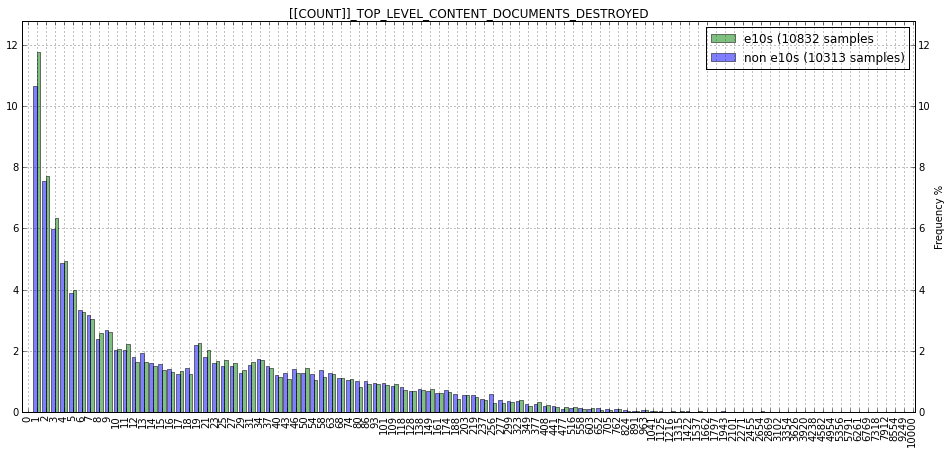

The chi2 distance for DEVTOOLS_TABS_OPEN_PEAK_LINEAR is 0.00332310837912


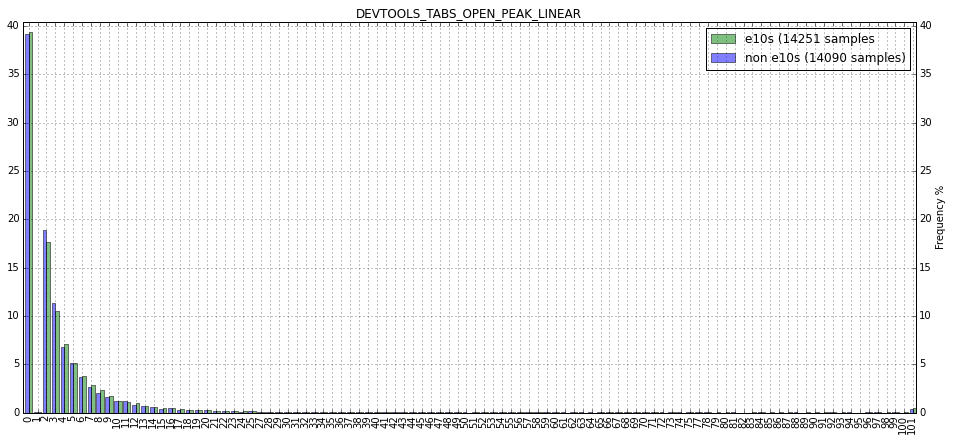

The chi2 distance for DEVTOOLS_TABS_OPEN_AVERAGE_LINEAR is 0.00326521733904


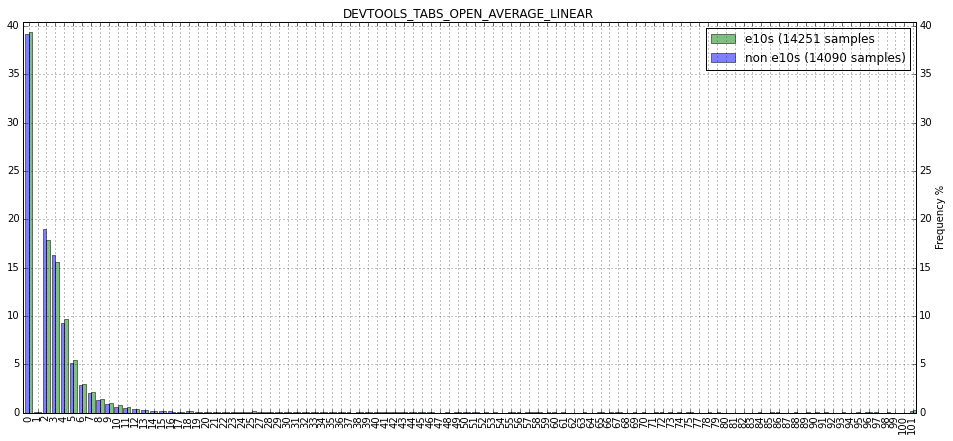

The chi2 distance for HTTP_SUBITEM_FIRST_BYTE_LATENCY_TIME is 0.00324173331521


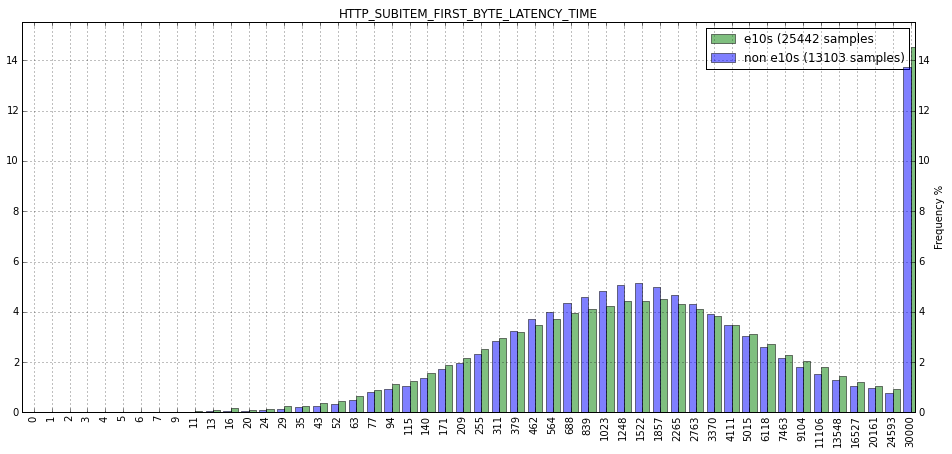

The chi2 distance for EVENTLOOP_UI_LAG_EXP_MS is 0.00322303555724


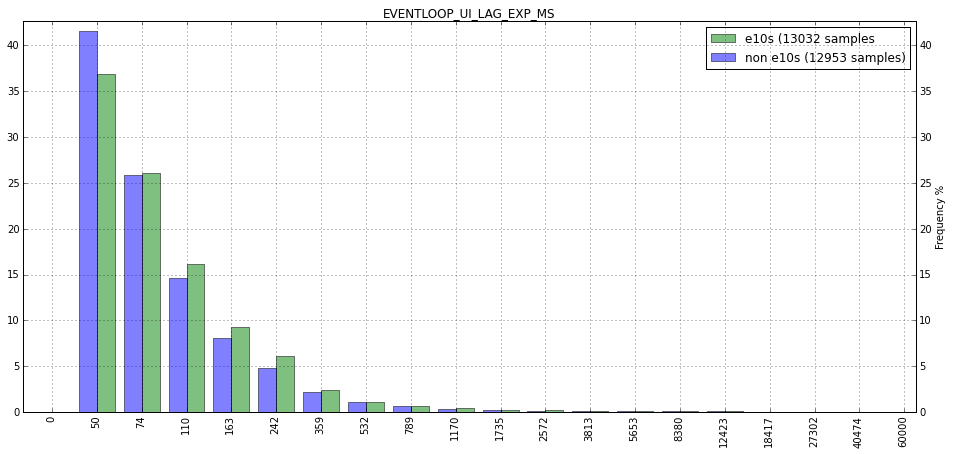

The chi2 distance for SSL_SUCCESFUL_CERT_VALIDATION_TIME_MOZILLAPKIX is 0.00315770964358


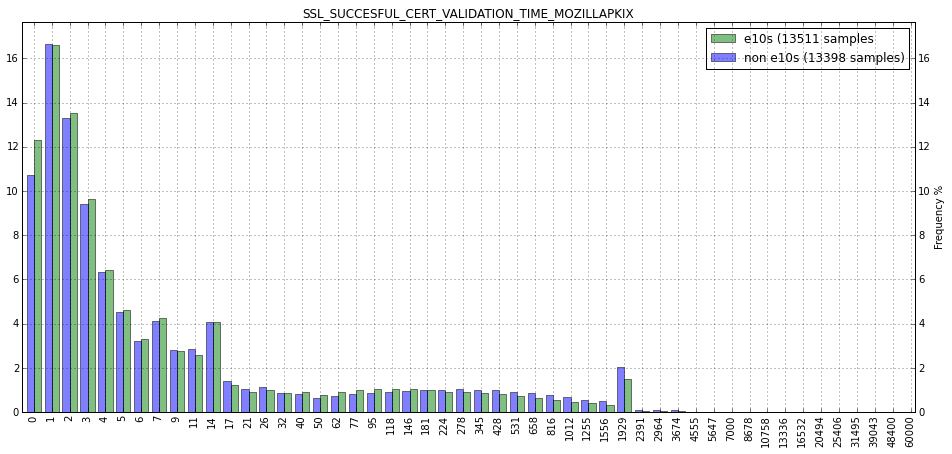

The chi2 distance for IMAGE_DECODE_SPEED_JPEG is 0.00312867097999


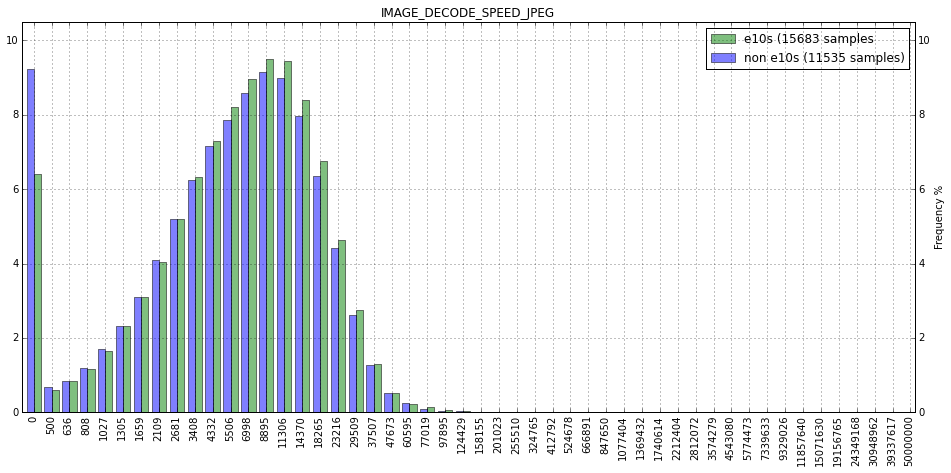

The chi2 distance for SSL_OBSERVED_END_ENTITY_CERTIFICATE_LIFETIME is 0.00301778931607


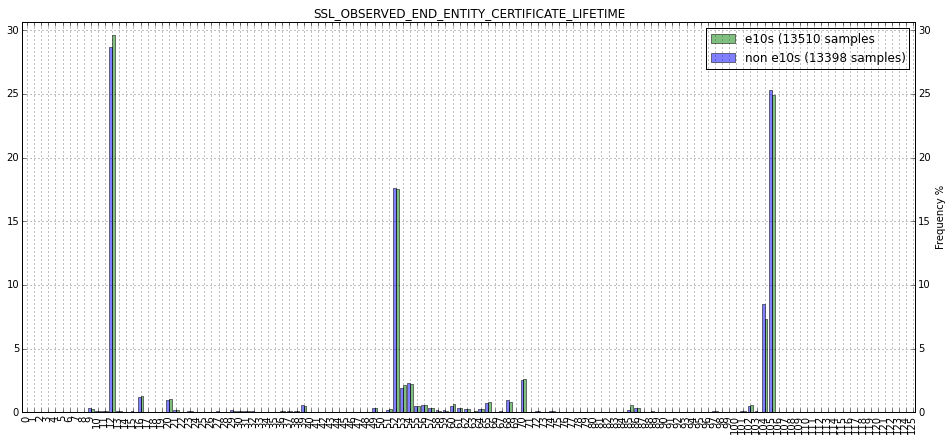

The chi2 distance for IDLE_NOTIFY_IDLE_MS is 0.00296494538838


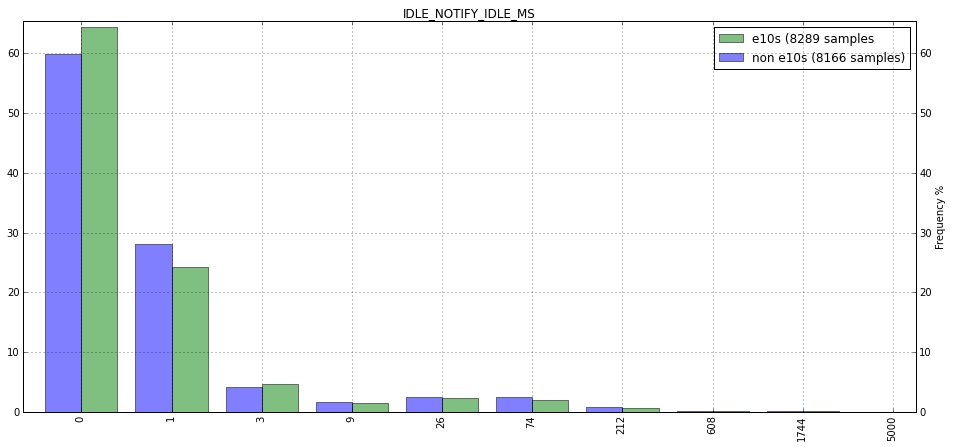

The chi2 distance for SSL_NPN_TYPE is 0.00295076717804


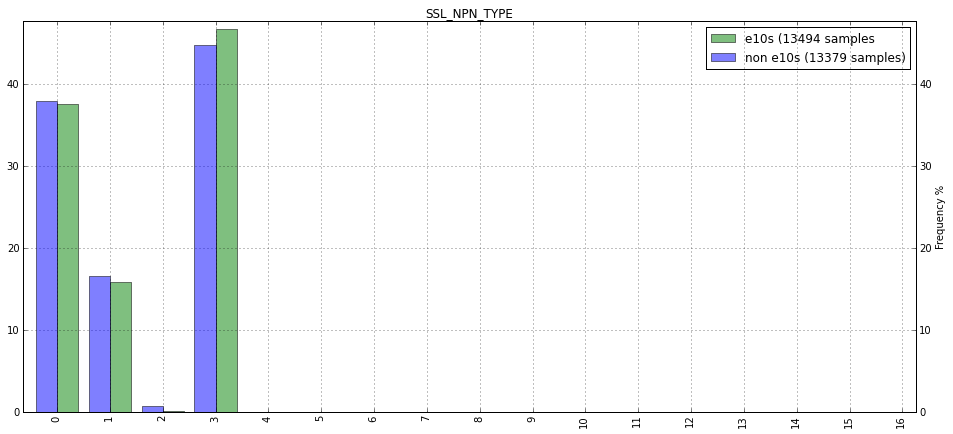

The chi2 distance for FX_SESSION_RESTORE_STARTUP_ONLOAD_INITIAL_WINDOW_MS is 0.00288969669038


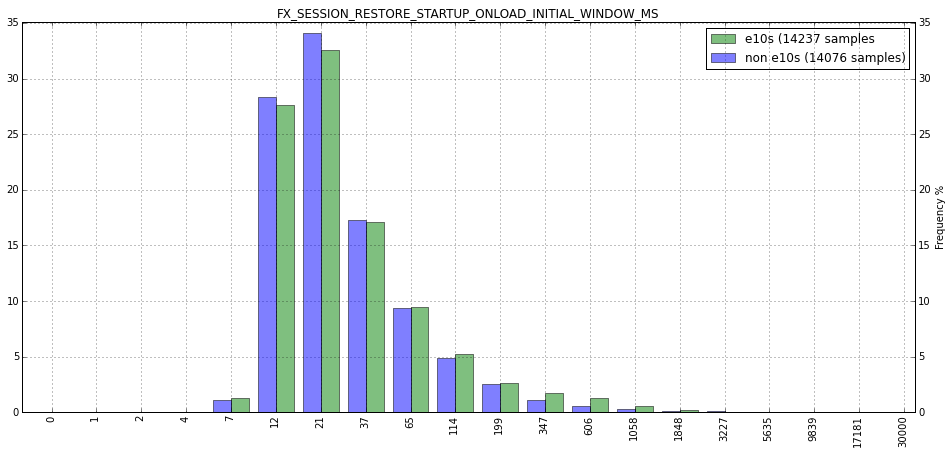

The chi2 distance for TOTAL_CONTENT_PAGE_LOAD_TIME is 0.00283431939603


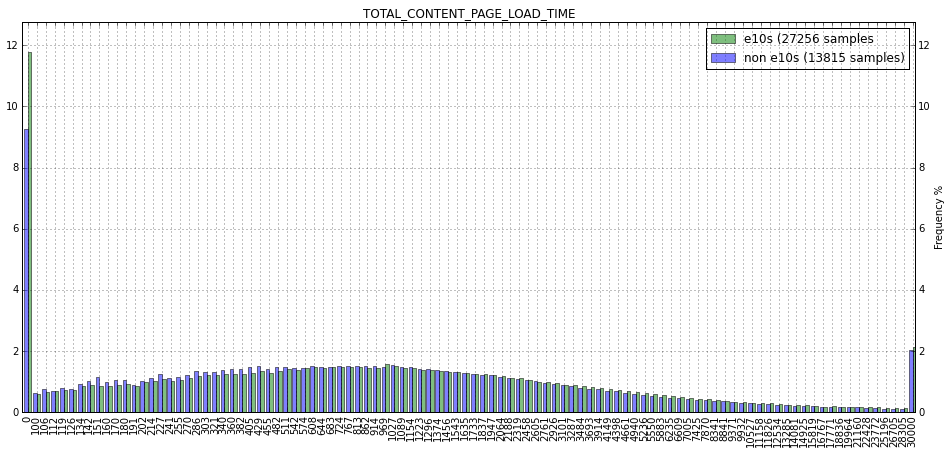

The chi2 distance for HTTP_CACHE_ENTRY_RELOAD_TIME is 0.00283008132636


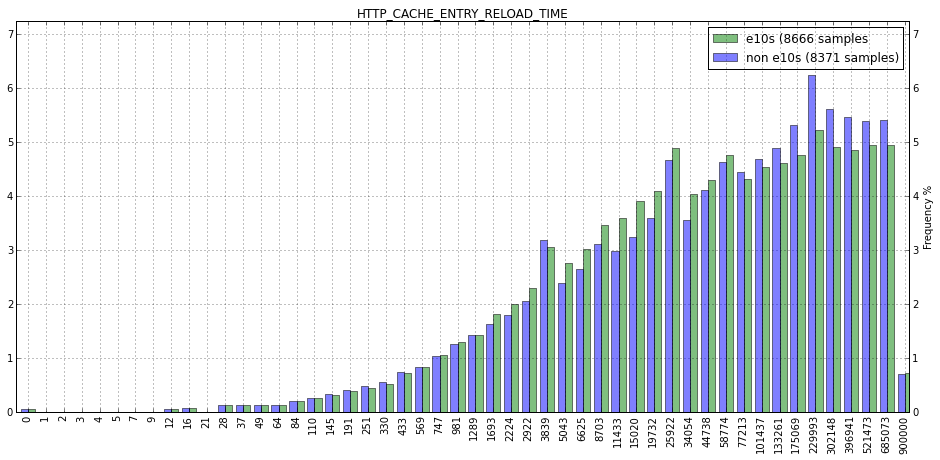

The chi2 distance for COMPONENTS_SHIM_ACCESSED_BY_CONTENT is 0.00276053317468


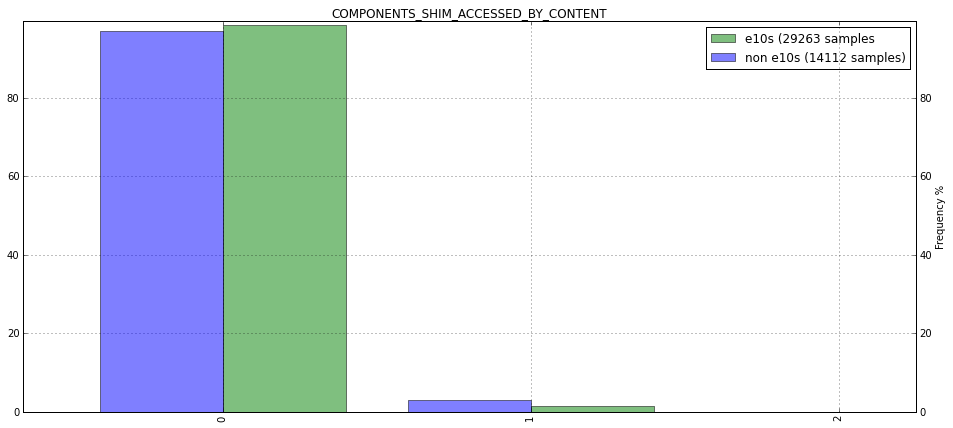

The chi2 distance for DNS_RENEWAL_TIME is 0.00276020919362


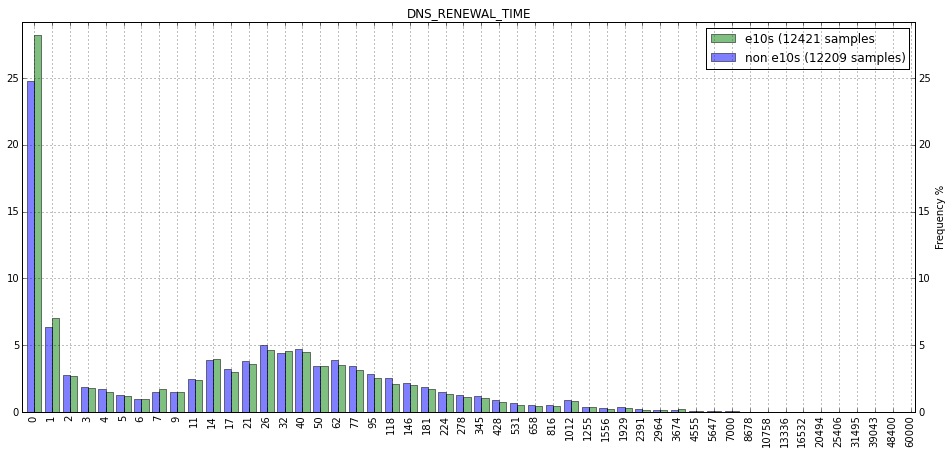

The chi2 distance for SPDY_CHUNK_RECVD is 0.00270675965459


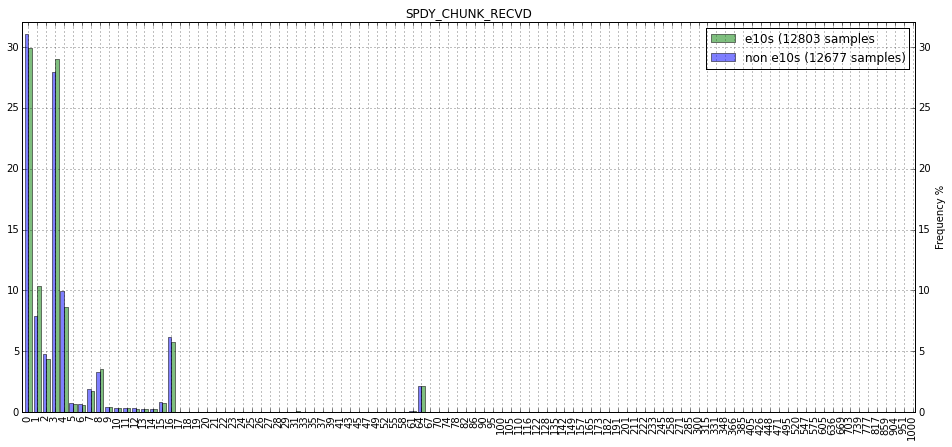

The chi2 distance for HTTP_REQUEST_PER_PAGE is 0.00267784196225


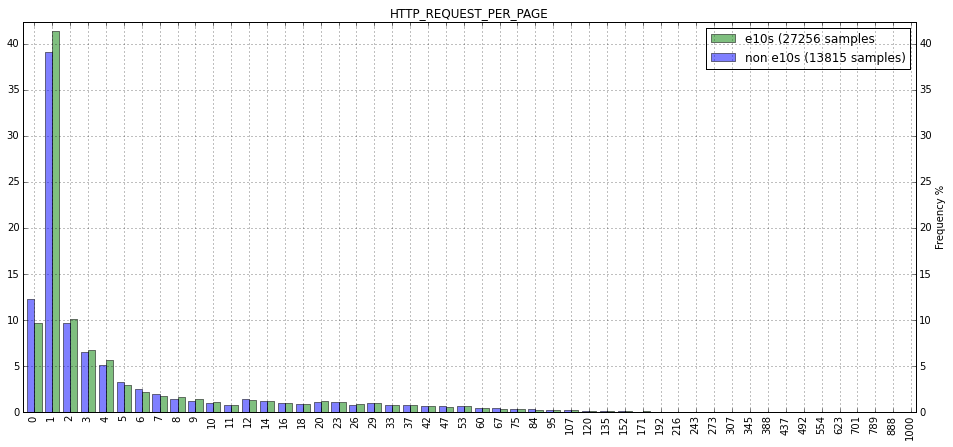

The chi2 distance for PREDICTOR_LEARN_WORK_TIME is 0.00267335720678


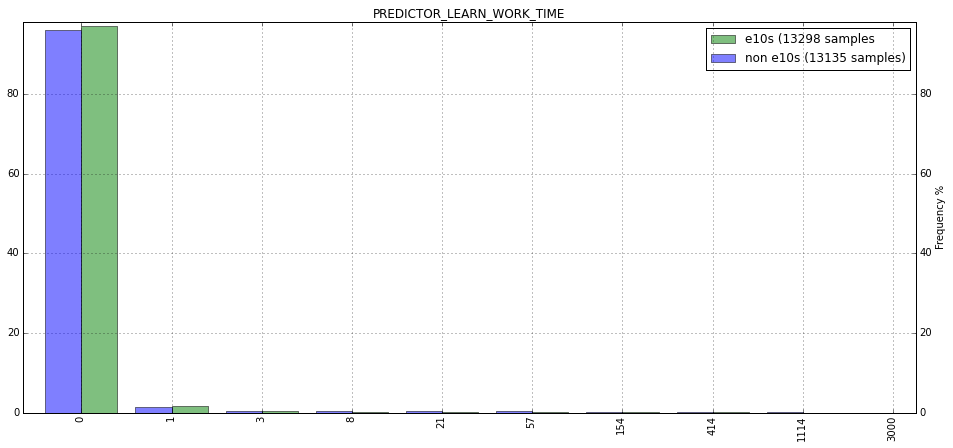

The chi2 distance for [[COUNT]]_SEARCH_COUNTS is 0.00262226206097


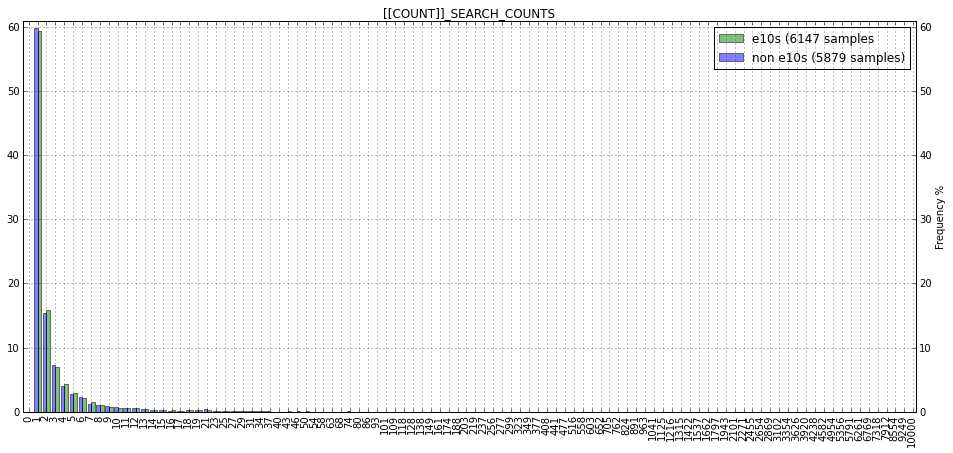

The chi2 distance for MOZ_SQLITE_PLACES_SYNC_MS is 0.00254397766055


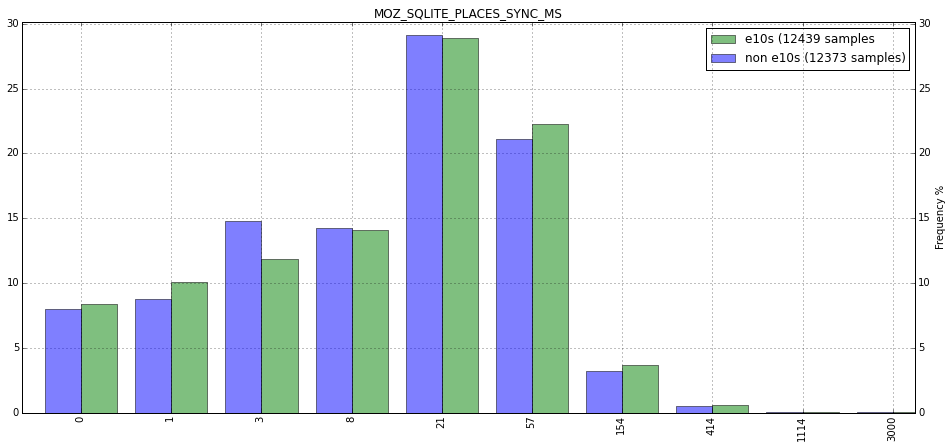

The chi2 distance for TELEMETRY_PENDING_CHECKING_OVER_QUOTA_MS is 0.00254193605897


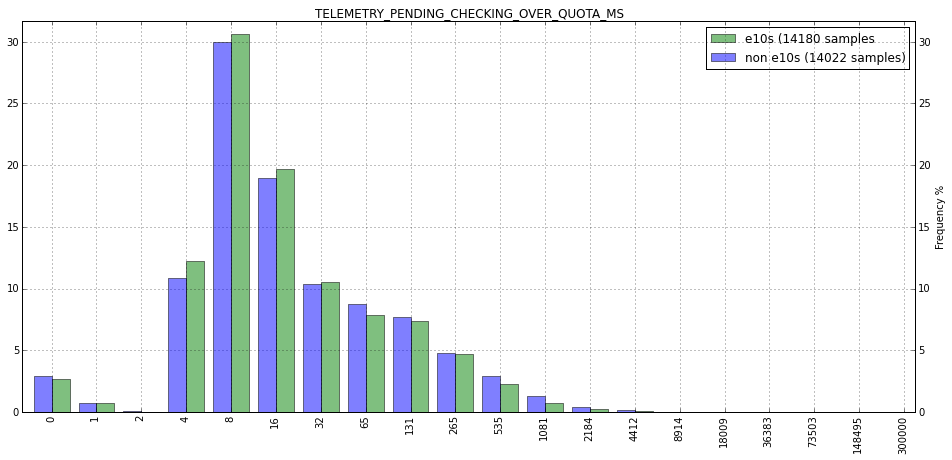

The chi2 distance for GHOST_WINDOWS is 0.00253160959891


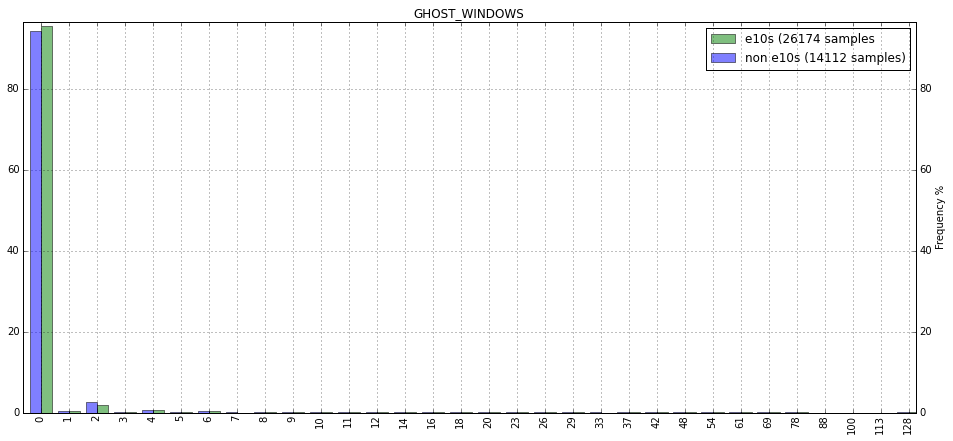

The chi2 distance for DNS_RENEWAL_TIME_FOR_TTL is 0.00252282847753


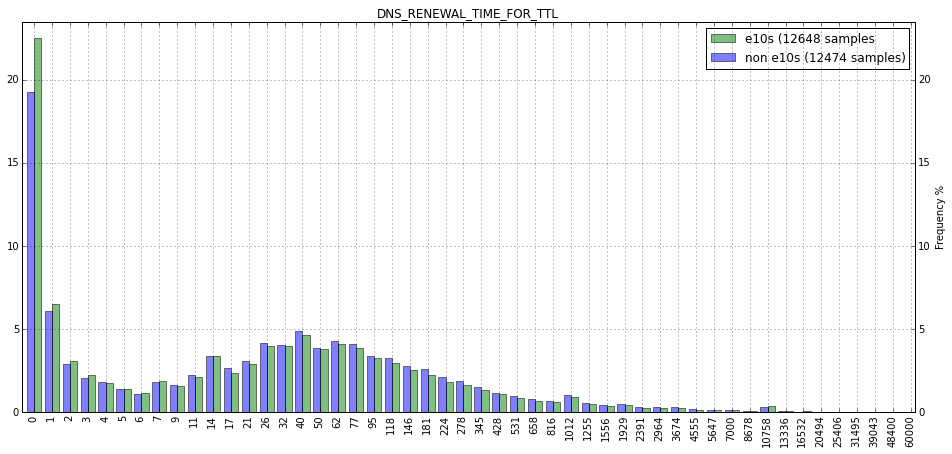

The chi2 distance for TELEMETRY_ARCHIVE_CHECKING_OVER_QUOTA_MS is 0.00251736124398


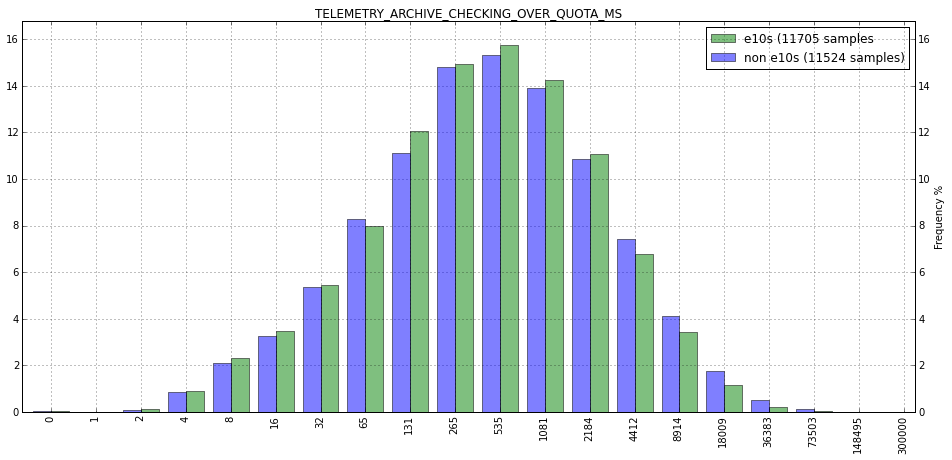

The chi2 distance for IMAGE_DECODE_SPEED_PNG is 0.00251116091642


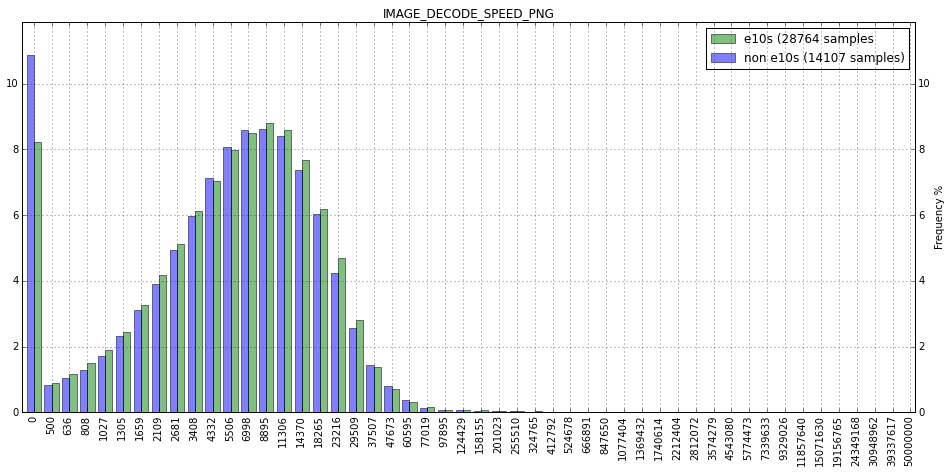

The chi2 distance for DWRITEFONT_DELAYEDINITFONTLIST_COLLECT is 0.00247222742715


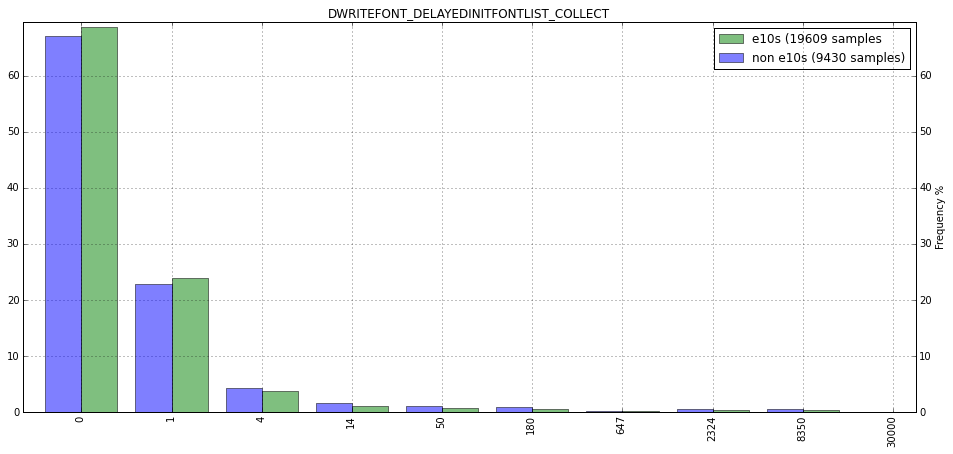

The chi2 distance for FX_SESSION_RESTORE_COLLECT_ALL_WINDOWS_DATA_MS is 0.00241563952805


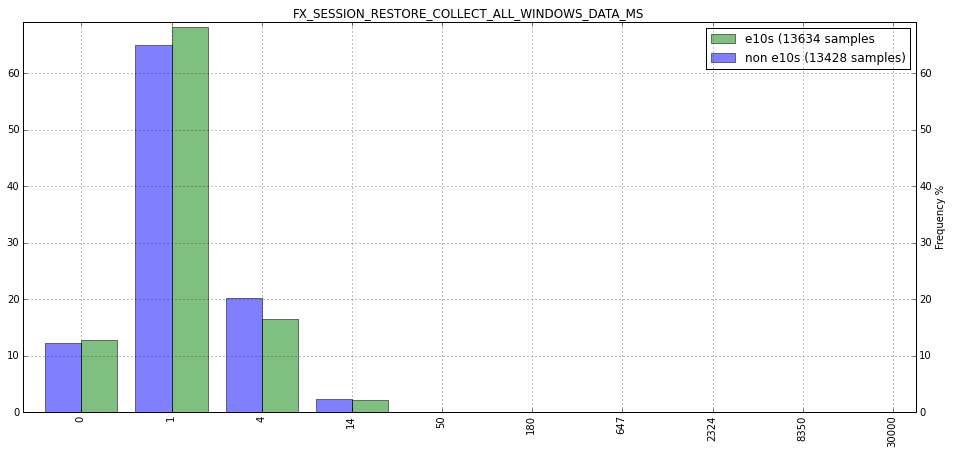

The chi2 distance for PWMGR_PASSWORD_INPUT_IN_FORM is 0.00237468414734


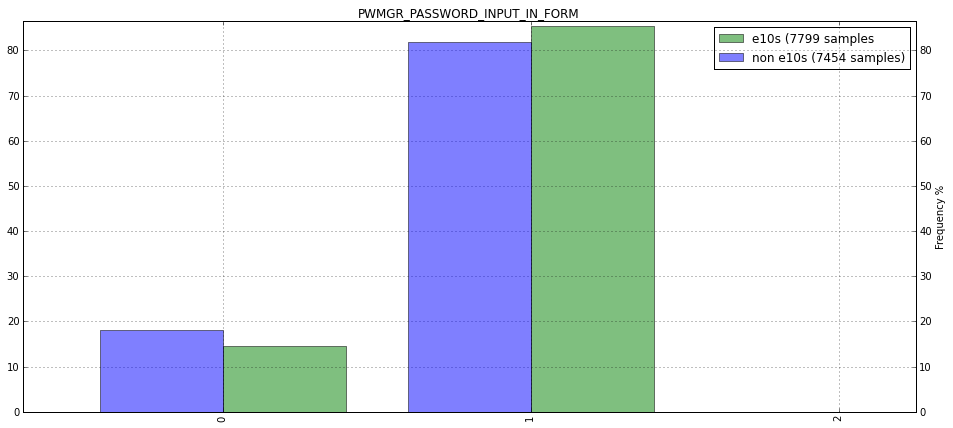

The chi2 distance for PLACES_AUTOCOMPLETE_1ST_RESULT_TIME_MS is 0.00232796311694


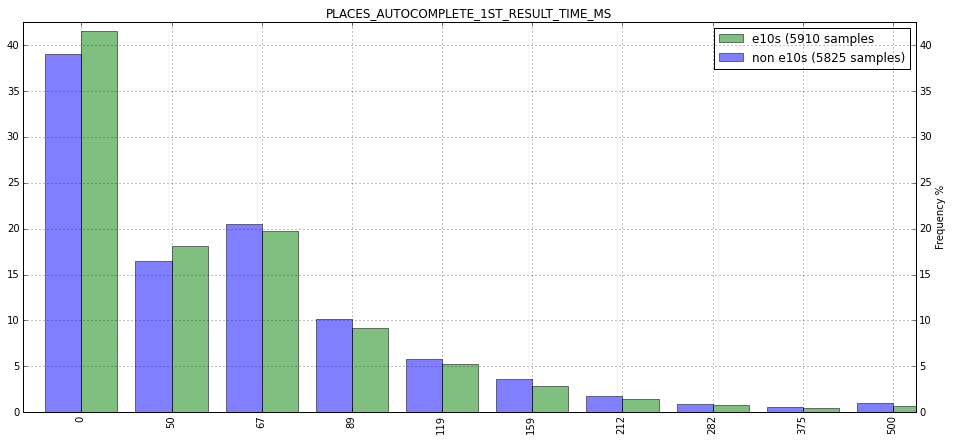

The chi2 distance for SIMPLE_MEASURES_ADDONMANAGER_XPIDB_SYNCREAD_MS is 0.00232694161964


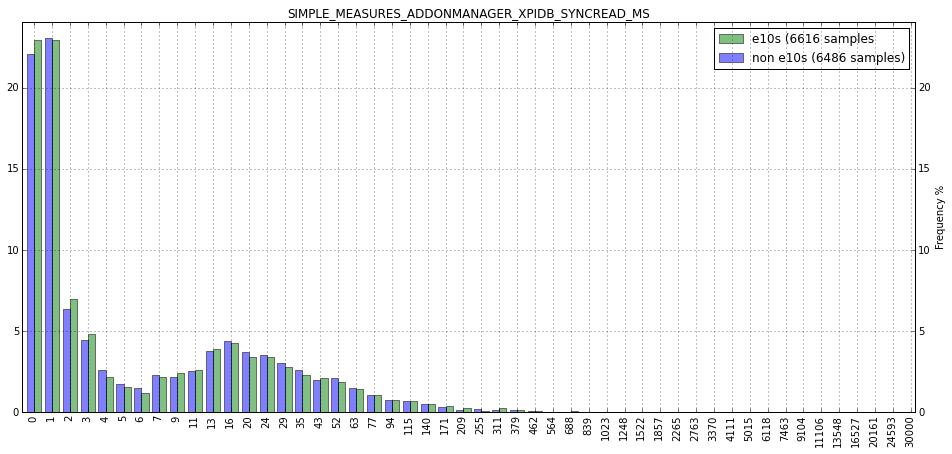

The chi2 distance for HTTP_PAGE_FIRST_SENT_TO_LAST_RECEIVED is 0.00224907107288


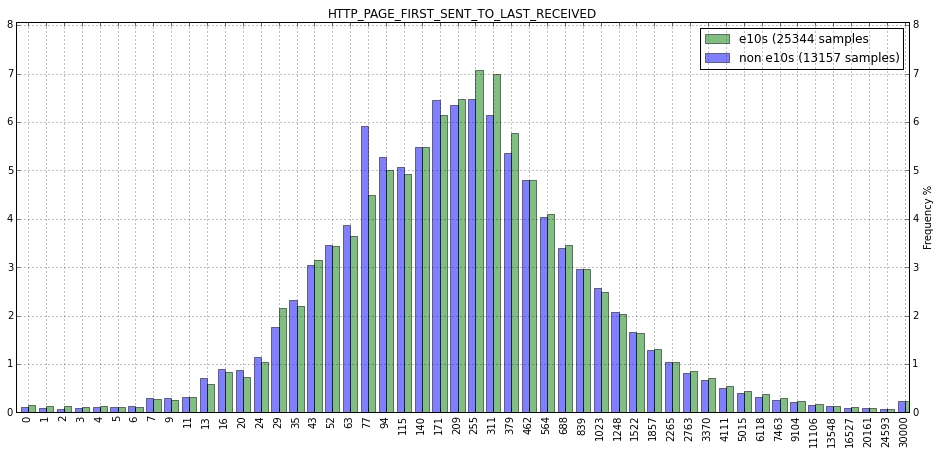

The chi2 distance for SIMPLE_MEASURES_MAIN is 0.00224825877227


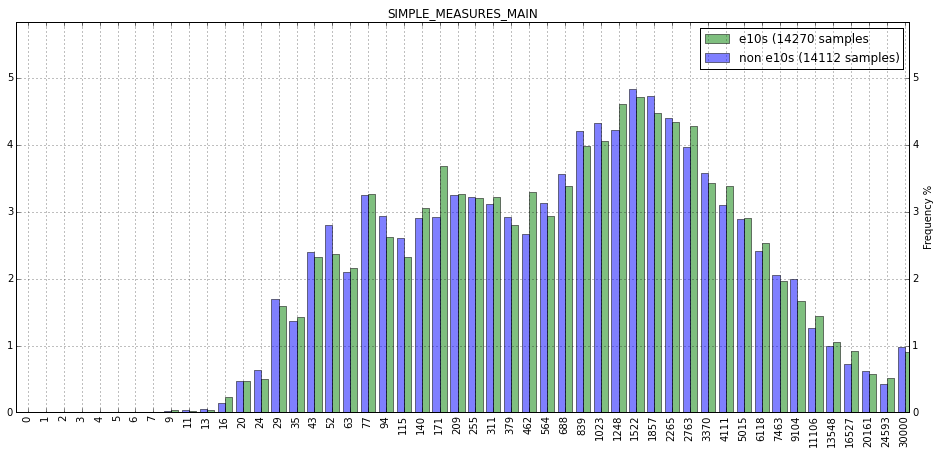

The chi2 distance for TELEMETRY_ARCHIVE_SCAN_PING_COUNT is 0.00221517685585


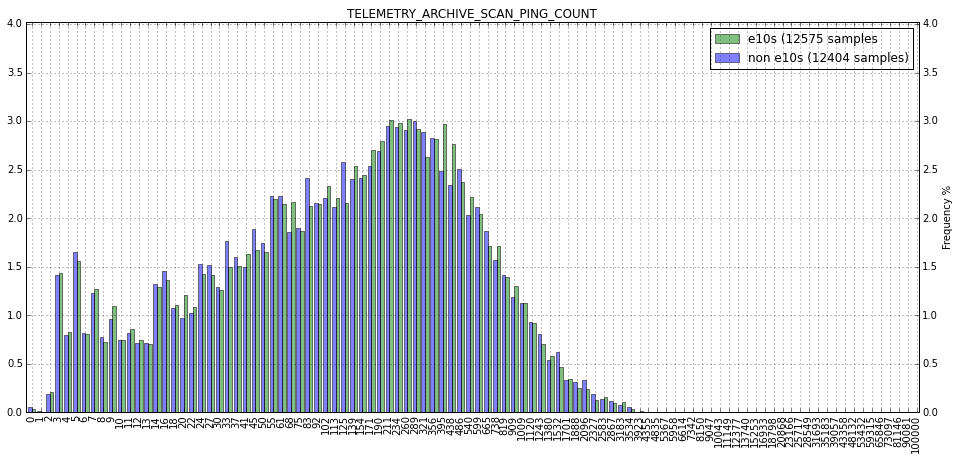

The chi2 distance for CYCLE_COLLECTOR_WORKER_VISITED_REF_COUNTED is 0.00218699707864


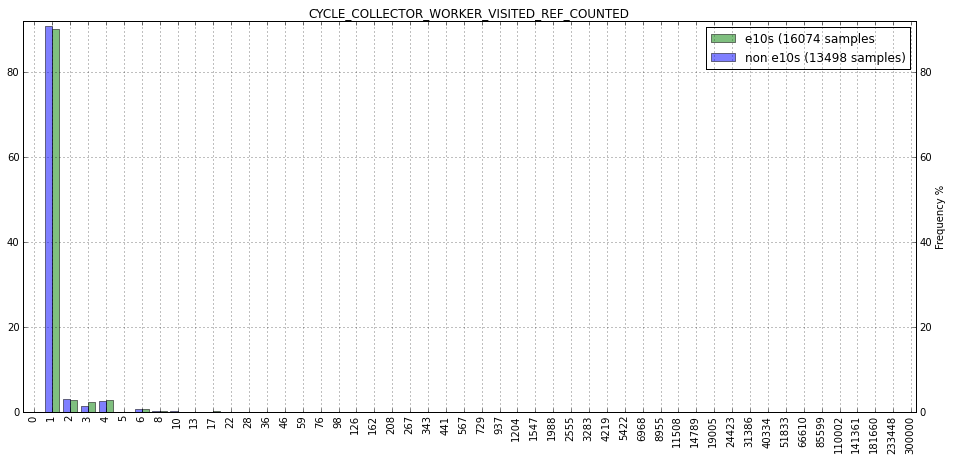

The chi2 distance for SSL_KEY_EXCHANGE_ALGORITHM_RESUMED is 0.00215714500628


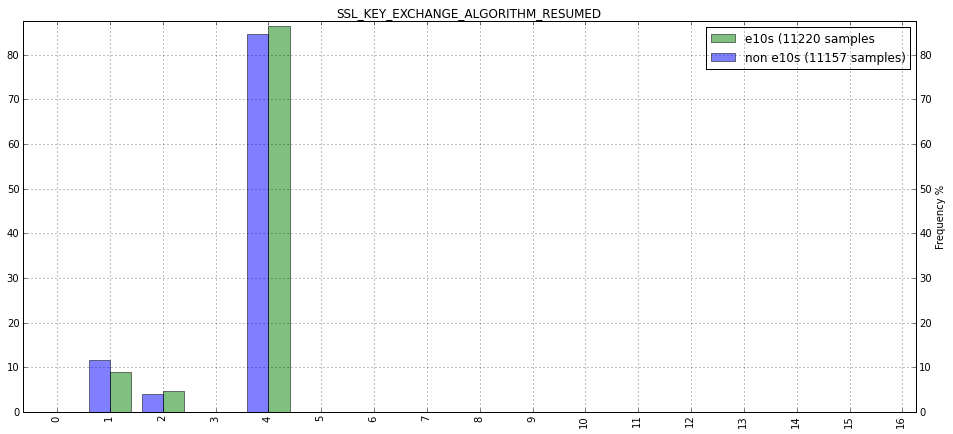

The chi2 distance for MOZ_SQLITE_WEBAPPS_SYNC_MS is 0.00215675509445


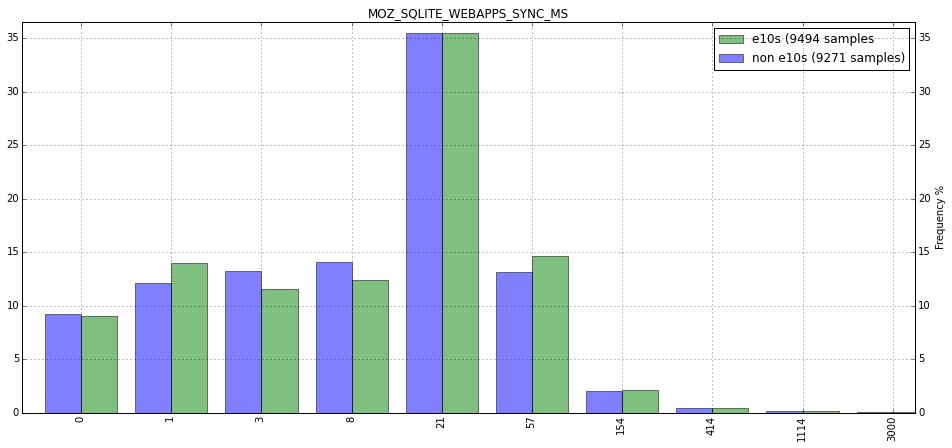

The chi2 distance for SEARCH_SERVICE_INIT_SYNC is 0.00209091489195


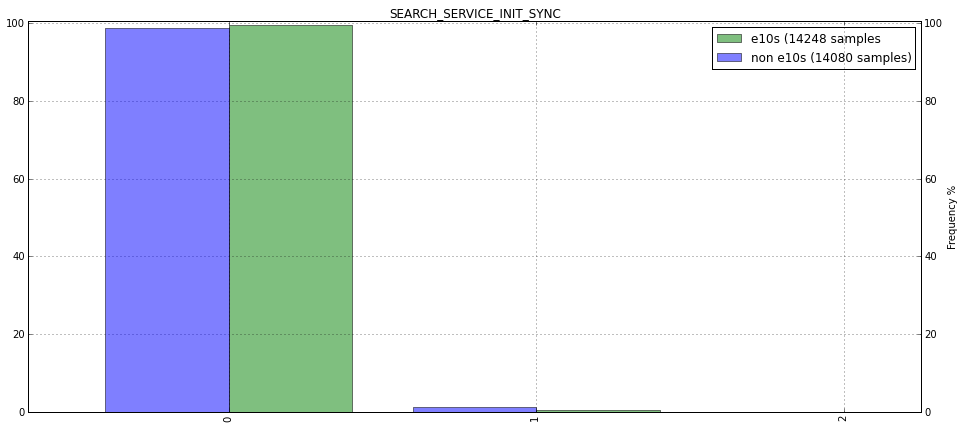

The chi2 distance for LOCALDOMSTORAGE_SHUTDOWN_DATABASE_MS is 0.0020731098793


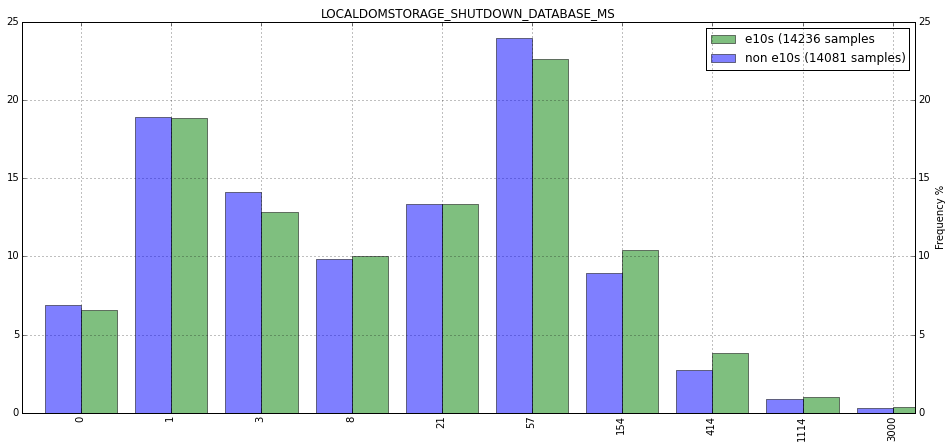

The chi2 distance for IMAGE_DECODE_TIME is 0.00199684609063


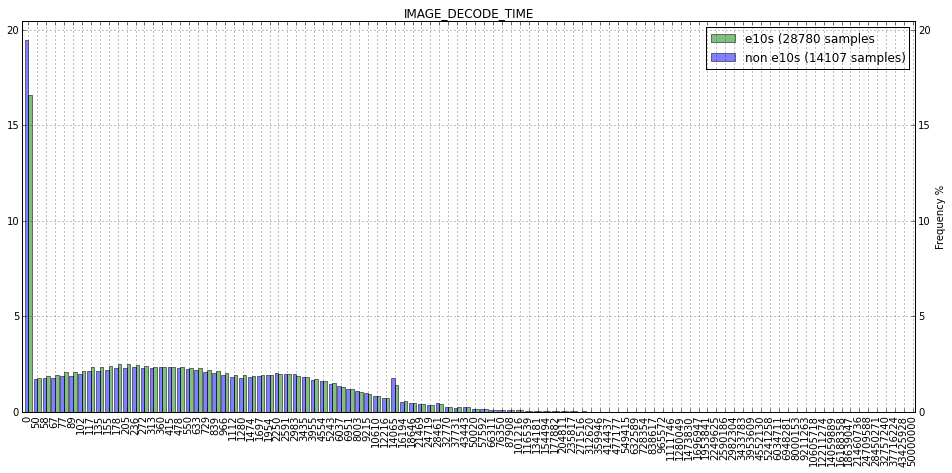

The chi2 distance for SIMPLE_MEASURES_TOTALTIME is 0.0019832705796


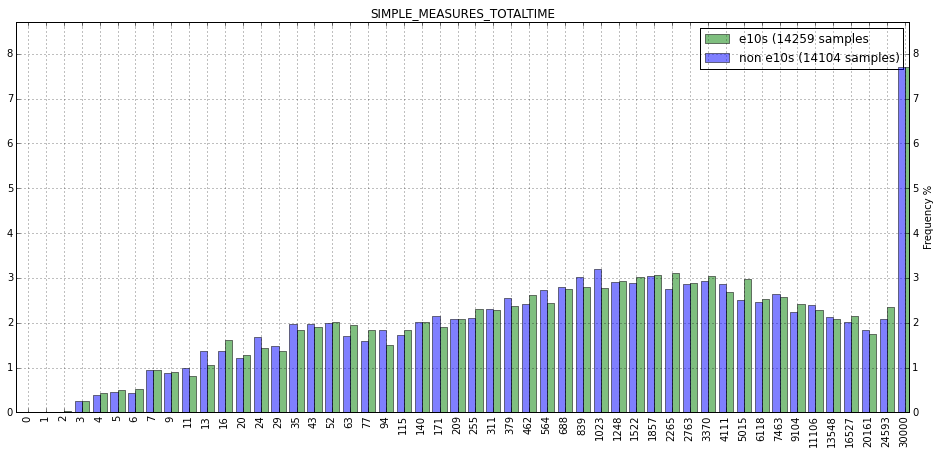

The chi2 distance for HTML_FOREGROUND_REFLOW_MS_2 is 0.0018923446908


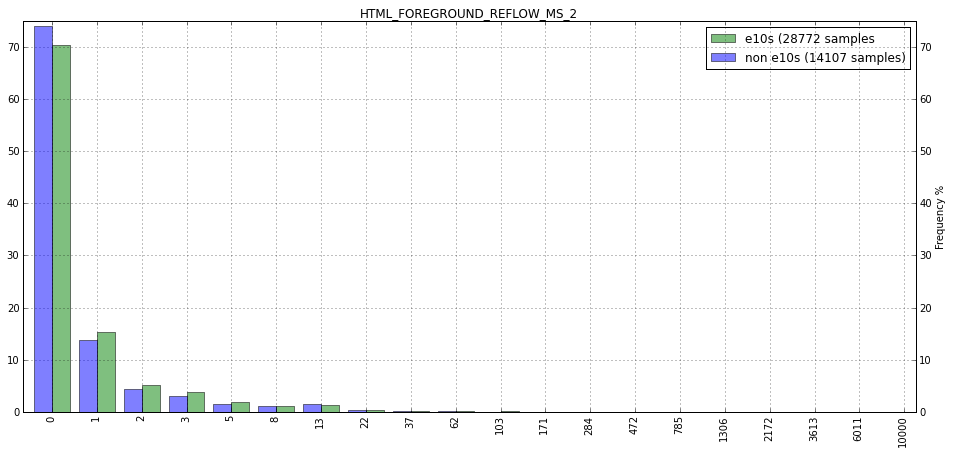

The chi2 distance for PLACES_AUTOCOMPLETE_6_FIRST_RESULTS_TIME_MS is 0.00186382605895


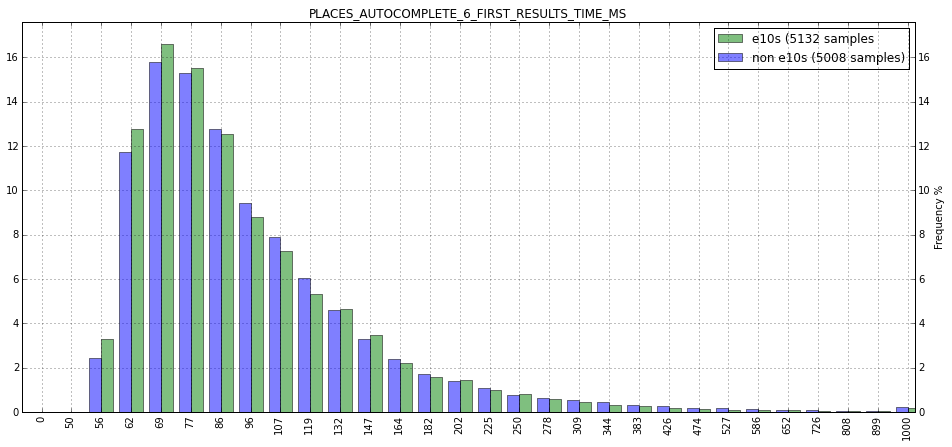

The chi2 distance for SIMPLE_MEASURES_AFTERPROFILELOCKED is 0.00185796071151


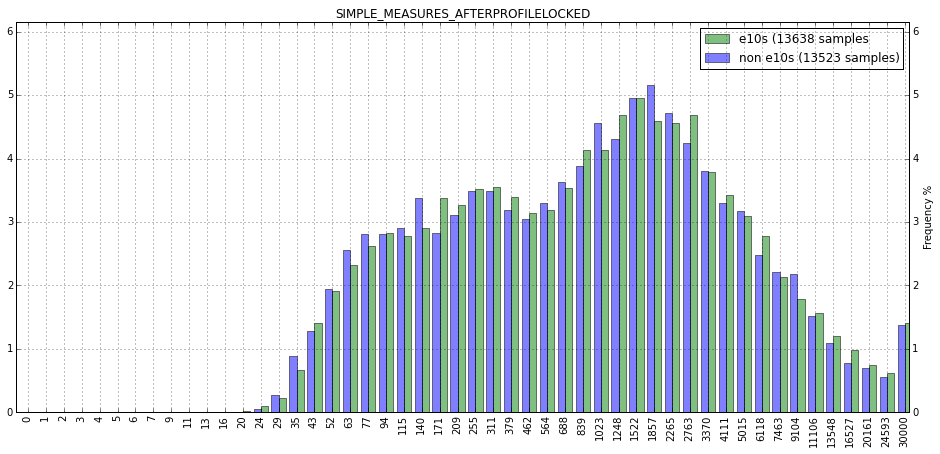

The chi2 distance for TELEMETRY_PENDING_PINGS_AGE is 0.00184789857633


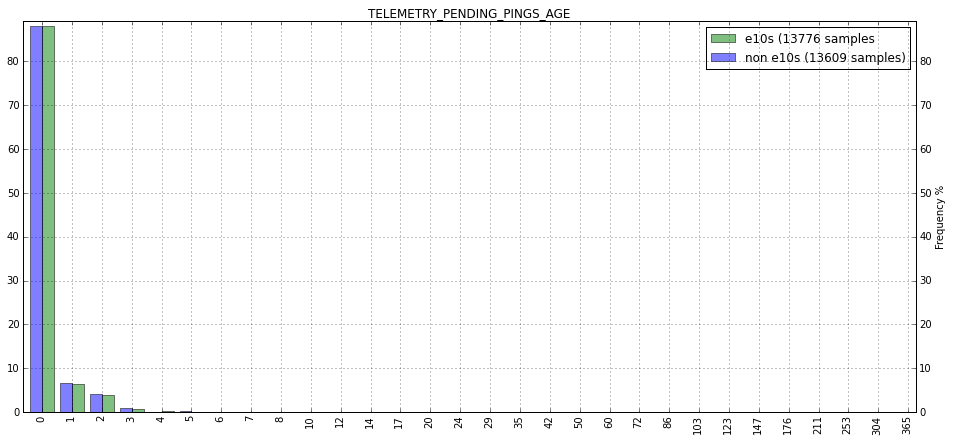

The chi2 distance for SIMPLE_MEASURES_SELECTPROFILE is 0.0017851641899


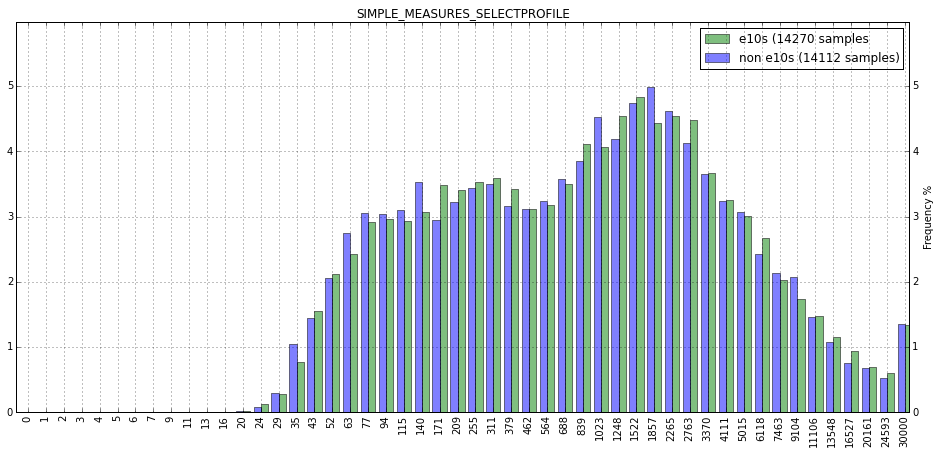

The chi2 distance for REFRESH_DRIVER_TICK is 0.00177441018103


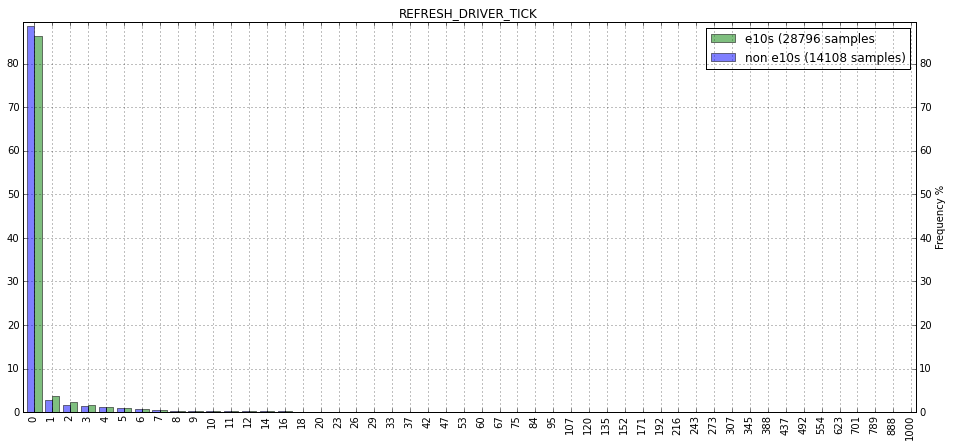

The chi2 distance for SIMPLE_MEASURES_START is 0.00176568751534


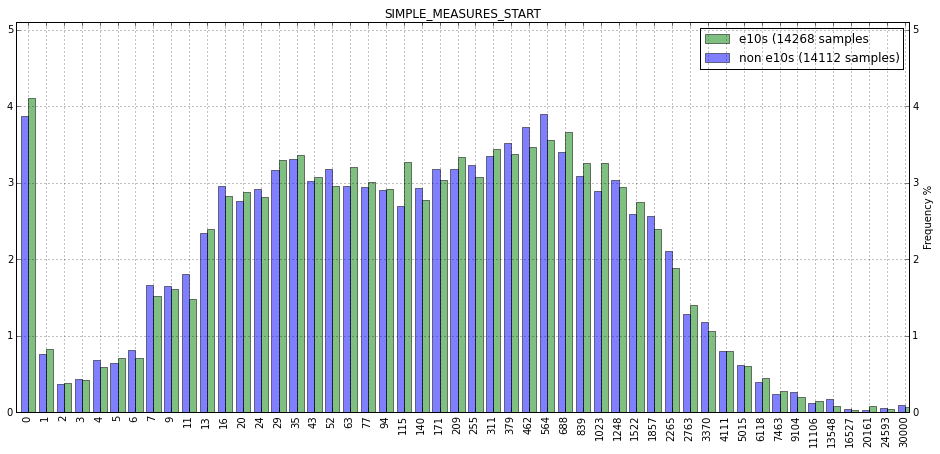

The chi2 distance for DWRITEFONT_DELAYEDINITFONTLIST_COUNT is 0.0017249714331


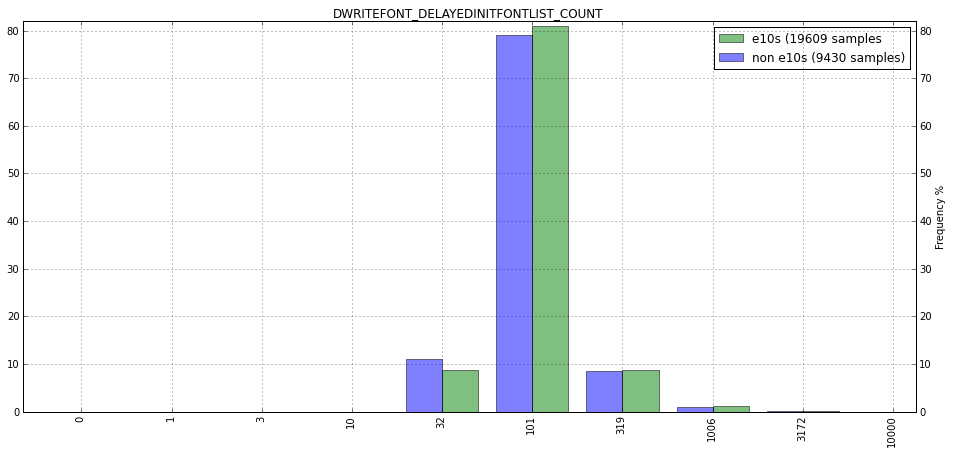

The chi2 distance for YOUTUBE_EMBED_SEEN is 0.00170856924271


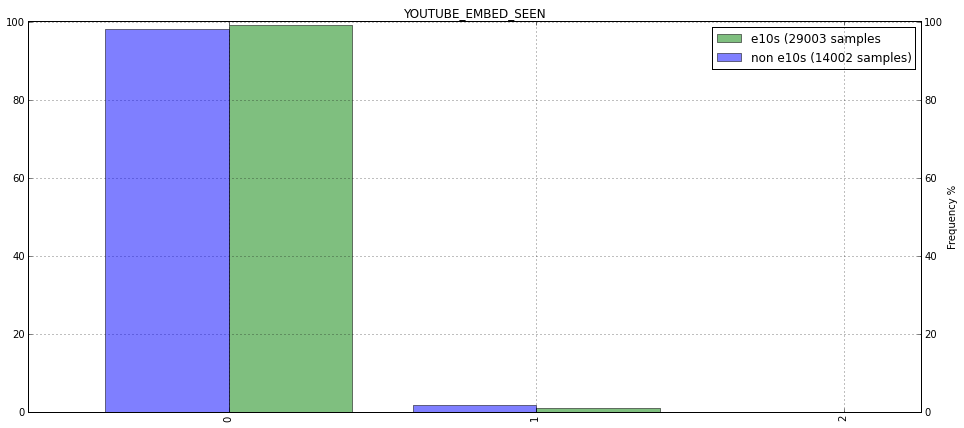

The chi2 distance for GC_IS_COMPARTMENTAL is 0.00170386888056


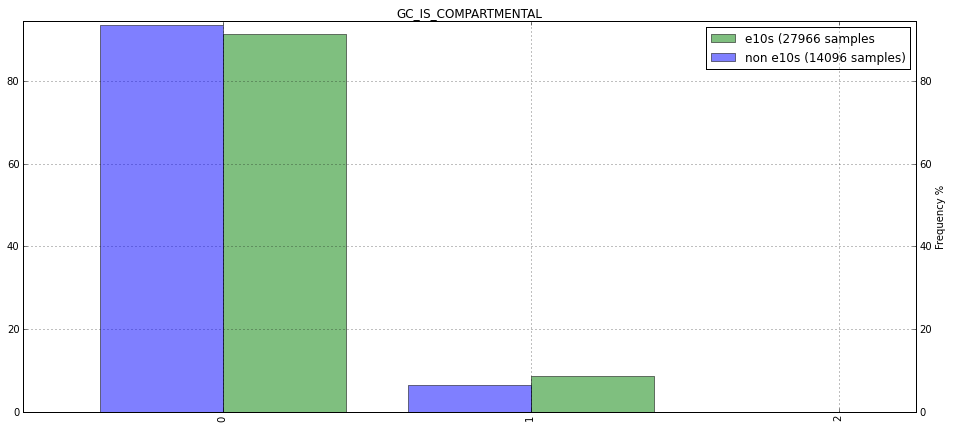

The chi2 distance for SIMPLE_MEASURES_SHUTDOWNDURATION is 0.00167905967256


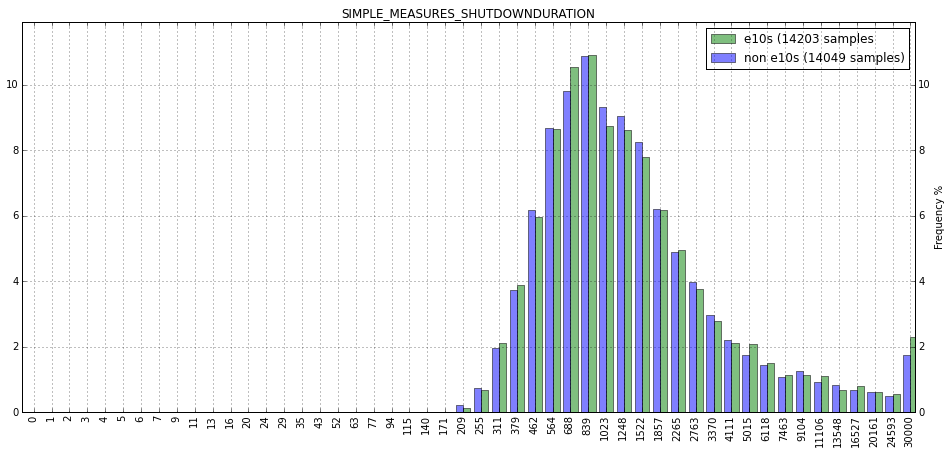

The chi2 distance for SIMPLE_MEASURES_STARTUPCRASHDETECTIONBEGIN is 0.00165531027909


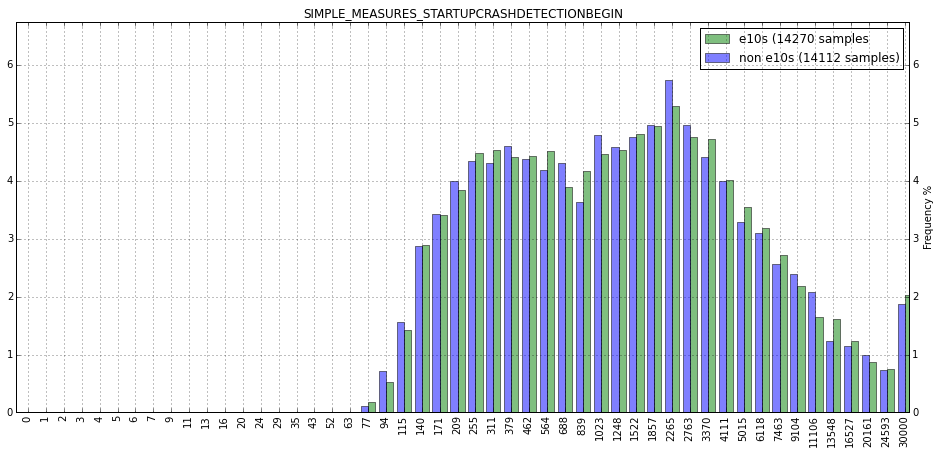

The chi2 distance for STS_POLL_BLOCK_TIME is 0.00160699258676


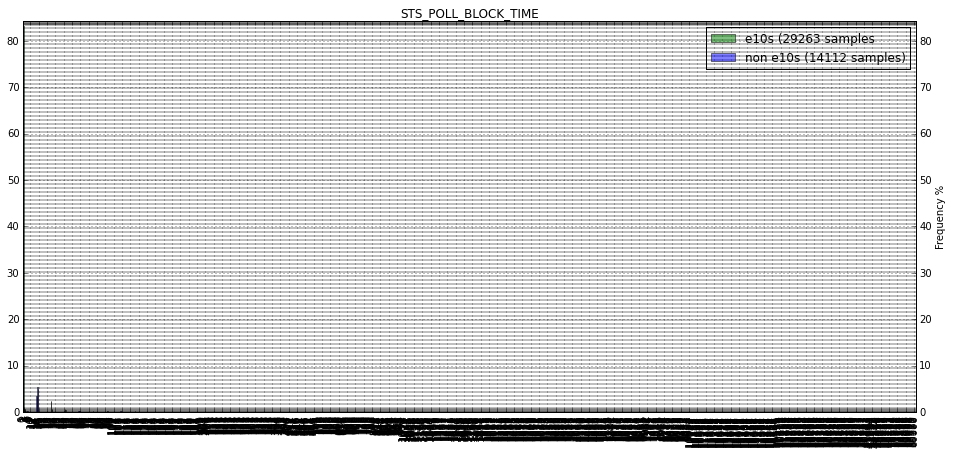

The chi2 distance for UPDATE_LAST_NOTIFY_INTERVAL_DAYS_EXTERNAL is 0.00160344908946


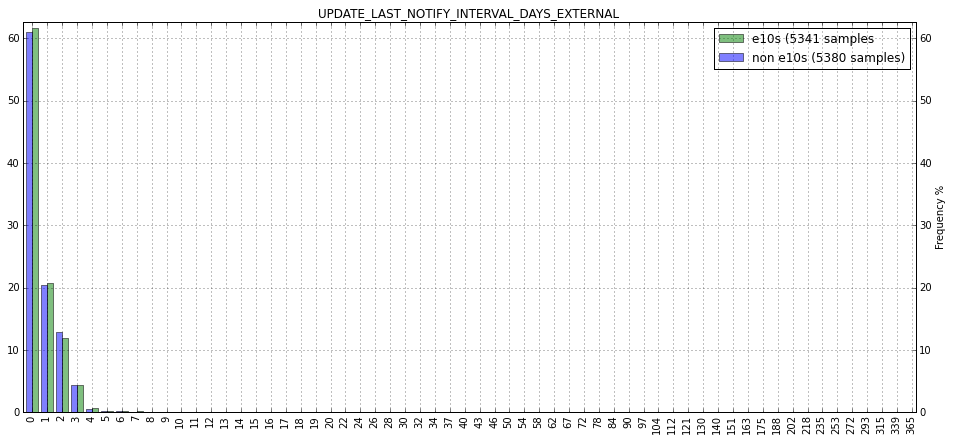

The chi2 distance for FX_SESSION_RESTORE_CONTENT_COLLECT_DATA_LONGEST_OP_MS is 0.00160248199684


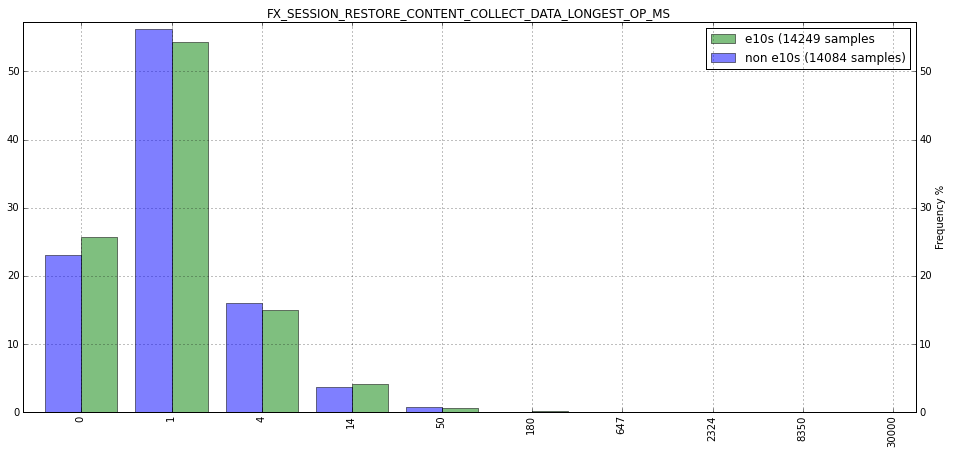

The chi2 distance for PRCONNECT_BLOCKING_TIME_NORMAL is 0.00160213017901


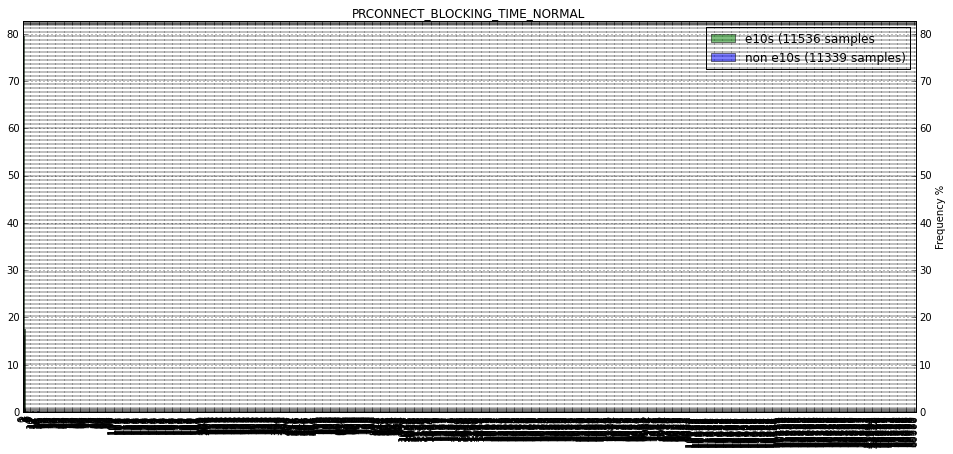

The chi2 distance for FLASH_PLUGIN_STATES is 0.00155613621084


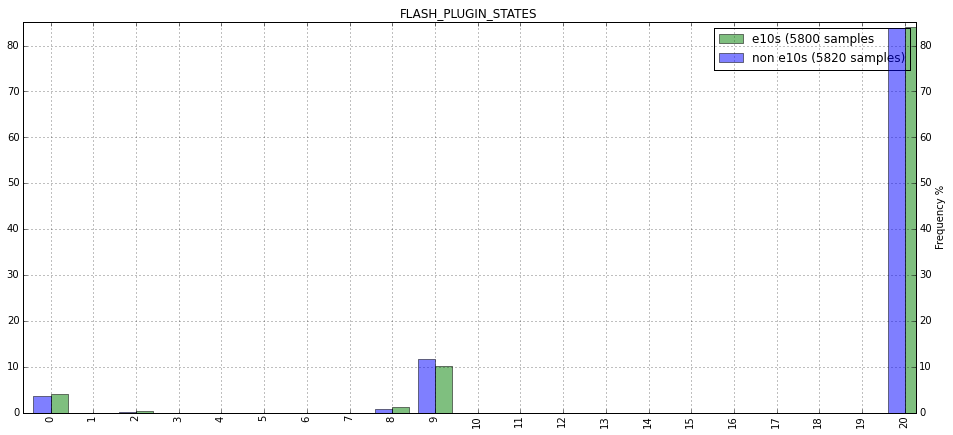

The chi2 distance for OSFILE_WRITEATOMIC_JANK_MS is 0.00153117048296


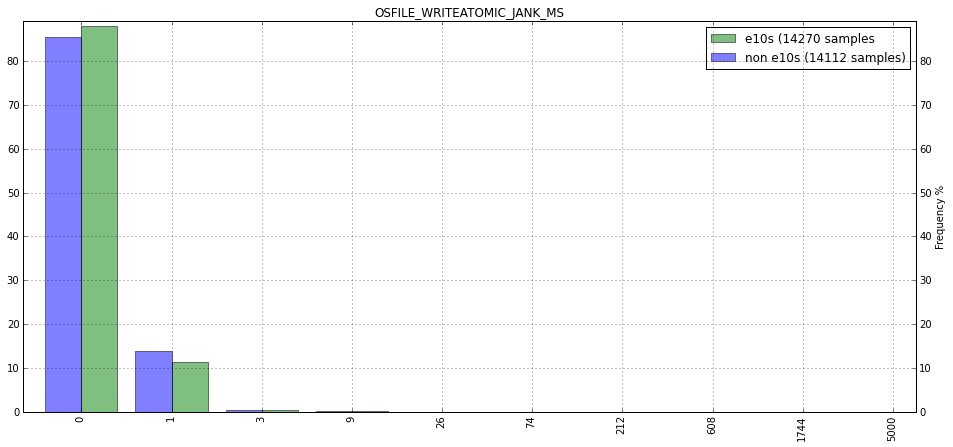

The chi2 distance for A11Y_ISIMPLEDOM_USAGE_FLAG is 0.00151878660221


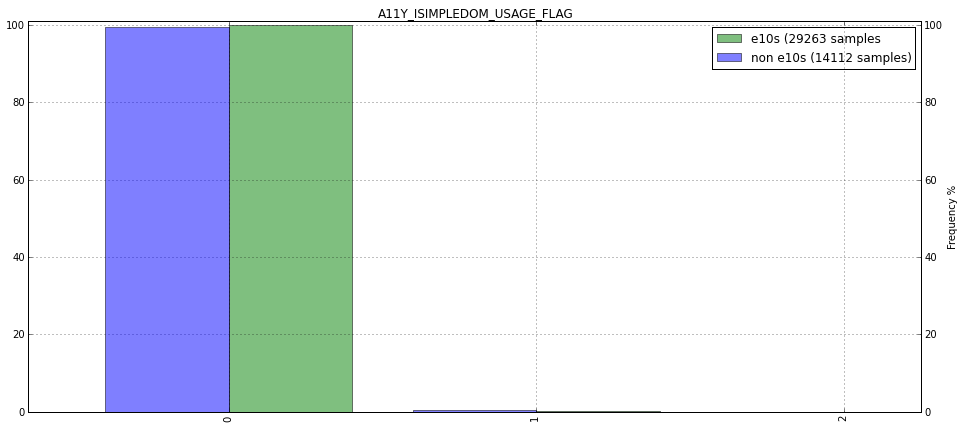

The chi2 distance for DECODER_INSTANTIATED_KOI8R is 0.00151197380569


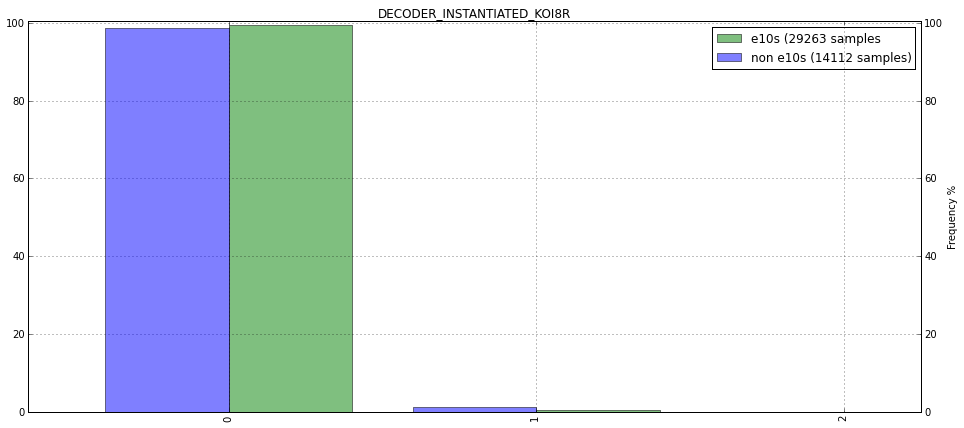

The chi2 distance for SSL_TIME_UNTIL_READY is 0.00150967734456


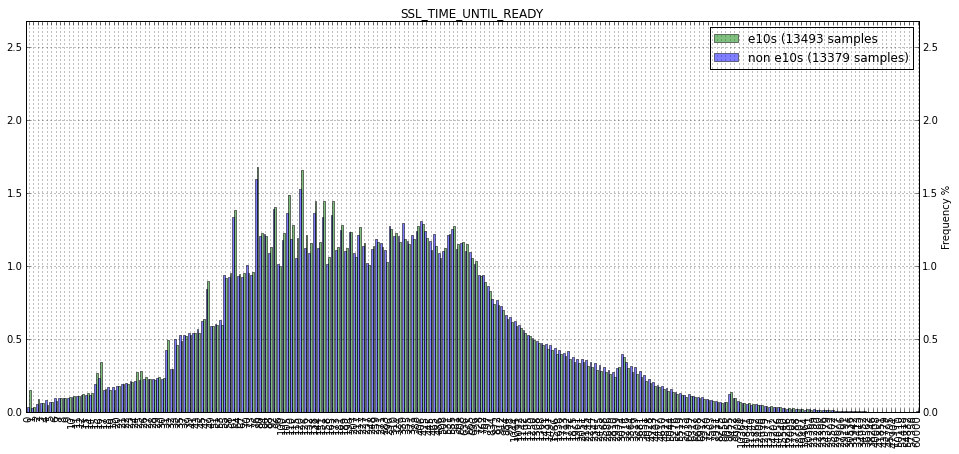

The chi2 distance for SSL_TIME_UNTIL_HANDSHAKE_FINISHED is 0.00149457781128


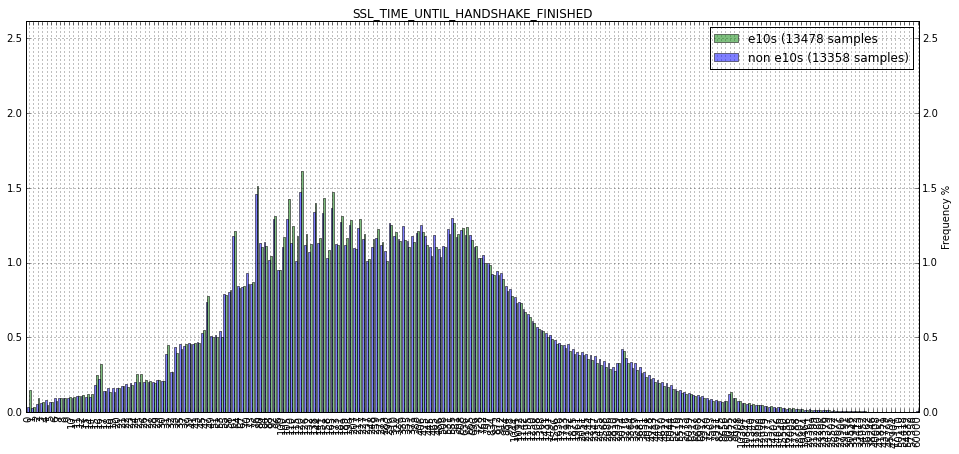

The chi2 distance for CERT_VALIDATION_SUCCESS_BY_CA is 0.0014925206163


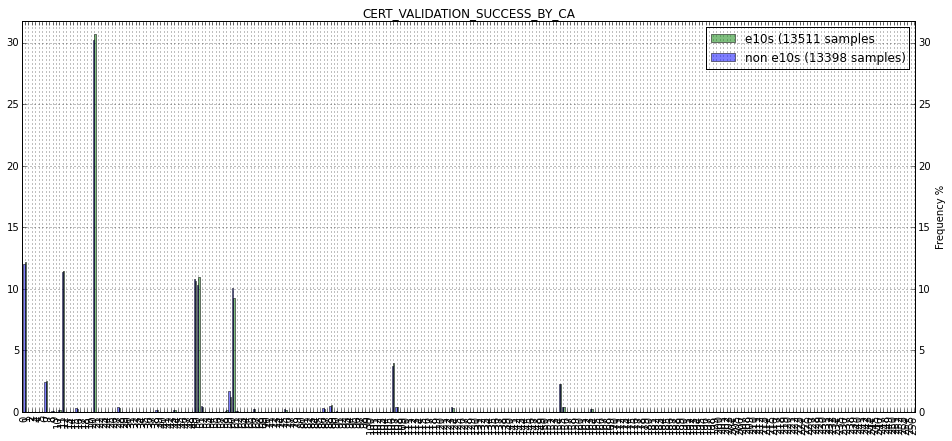

The chi2 distance for PWMGR_FORM_AUTOFILL_RESULT is 0.00148516602657


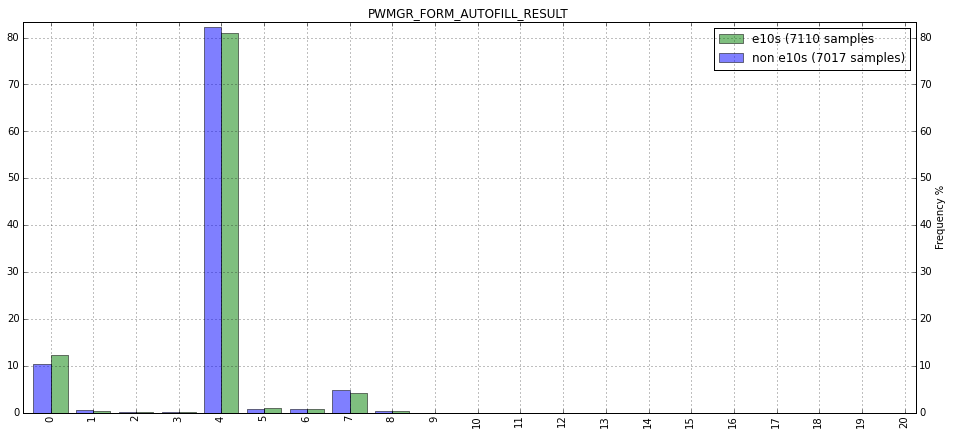

The chi2 distance for FX_SESSION_RESTORE_WRITE_FILE_MS is 0.00148449956557


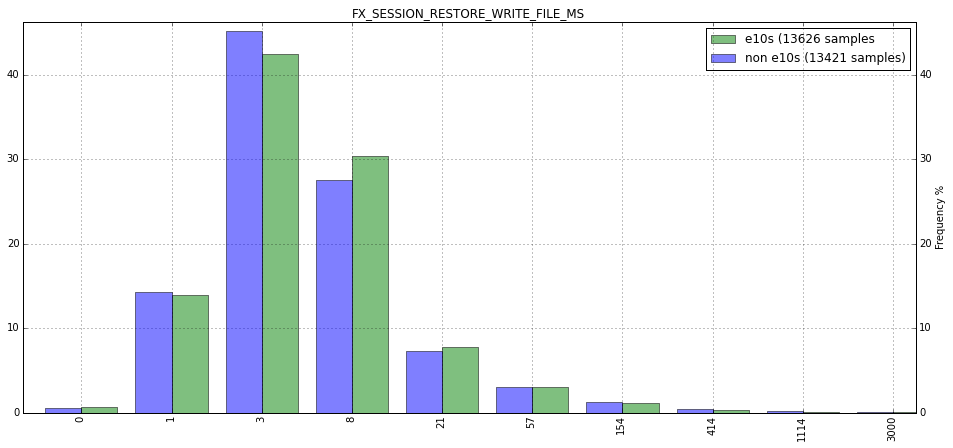

The chi2 distance for SIMPLE_MEASURES_AMI_STARTUP_BEGIN is 0.00148289438088


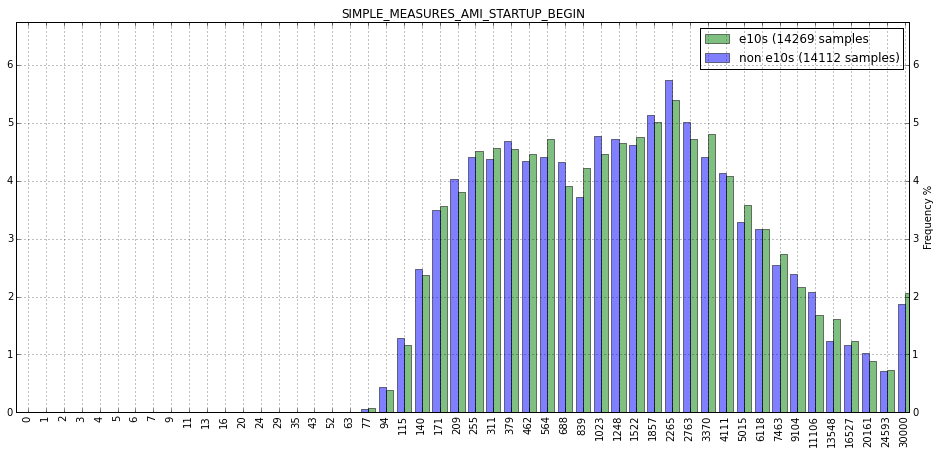

The chi2 distance for SIMPLE_MEASURES_XPI_STARTUP_BEGIN is 0.00143307319385


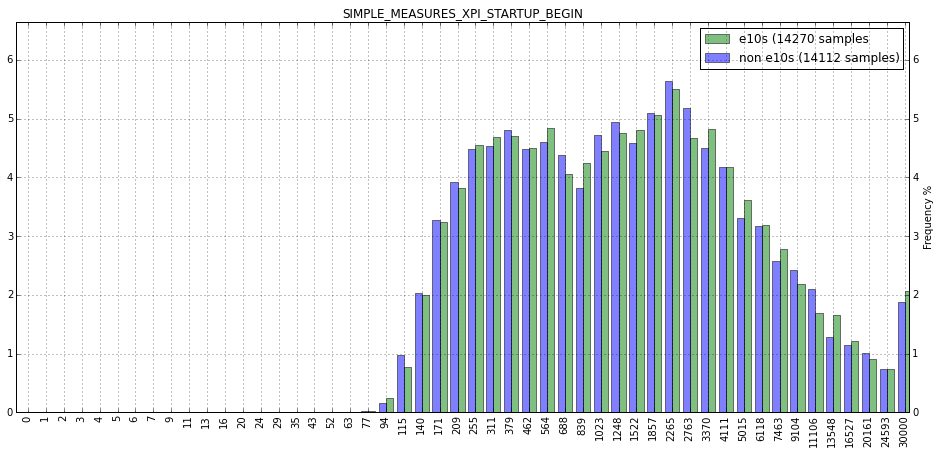

The chi2 distance for CYCLE_COLLECTOR_WORKER is 0.00142714981089


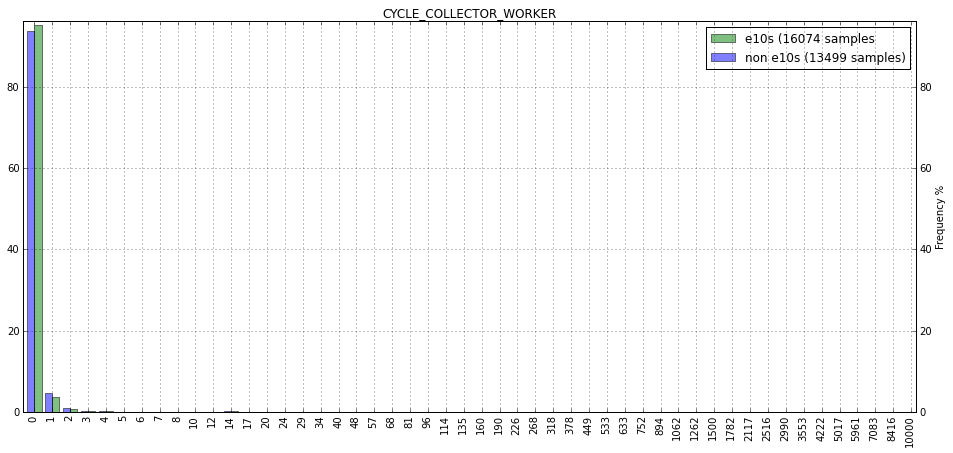

The chi2 distance for SSL_SYMMETRIC_CIPHER_RESUMED is 0.00138855145131


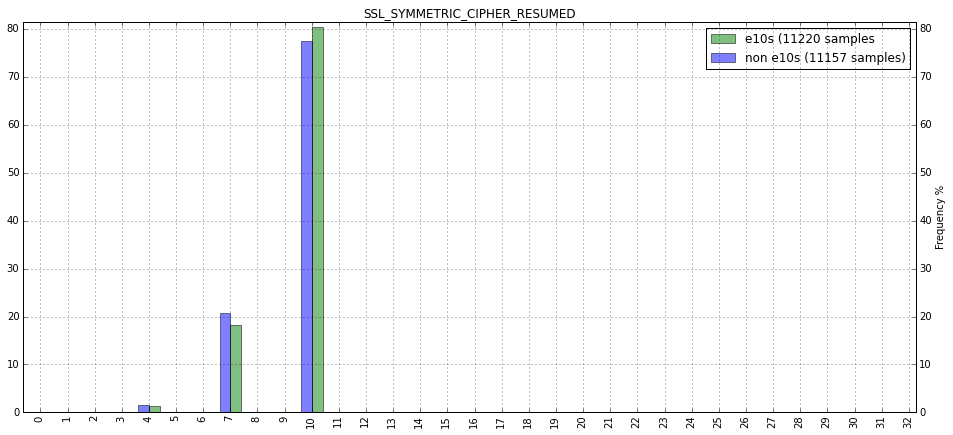

The chi2 distance for STARTUP_WORD_CACHE_HITS_CHROME is 0.00138646788577


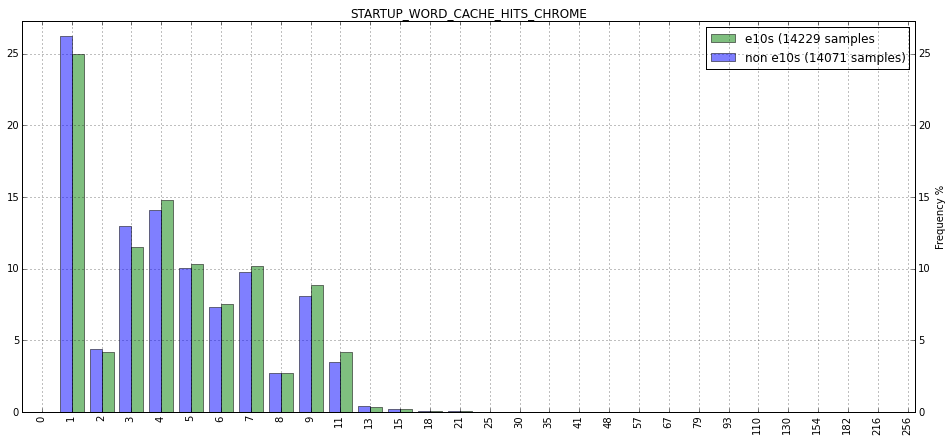

The chi2 distance for SSL_BYTES_BEFORE_CERT_CALLBACK is 0.00136171527159


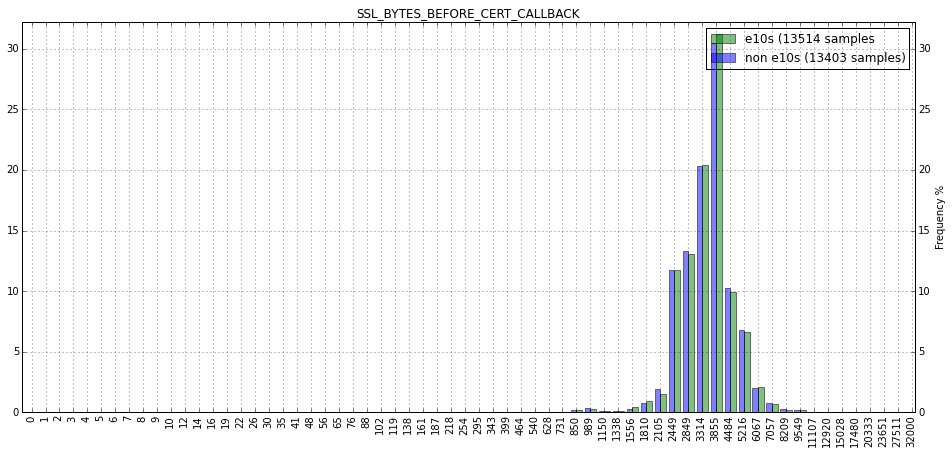

The chi2 distance for LOCALDOMSTORAGE_PRELOAD_PENDING_ON_FIRST_ACCESS is 0.00134572430244


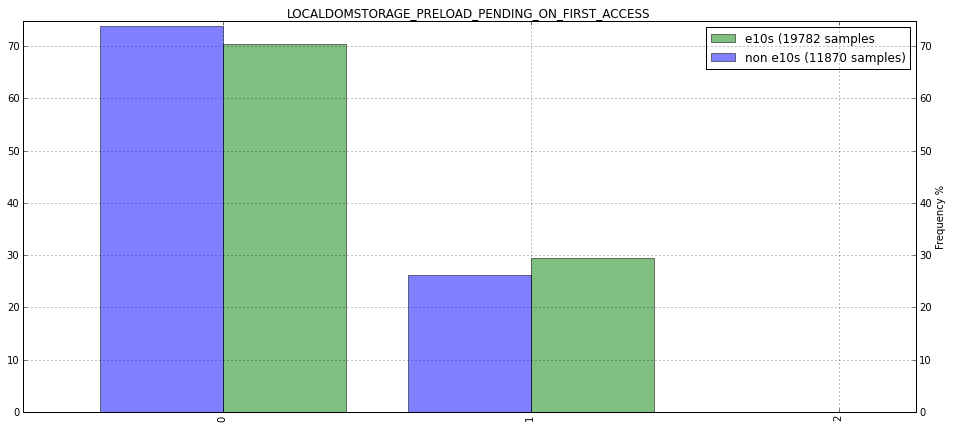

The chi2 distance for HTTP_TRANSACTION_IS_SSL is 0.00133229431821


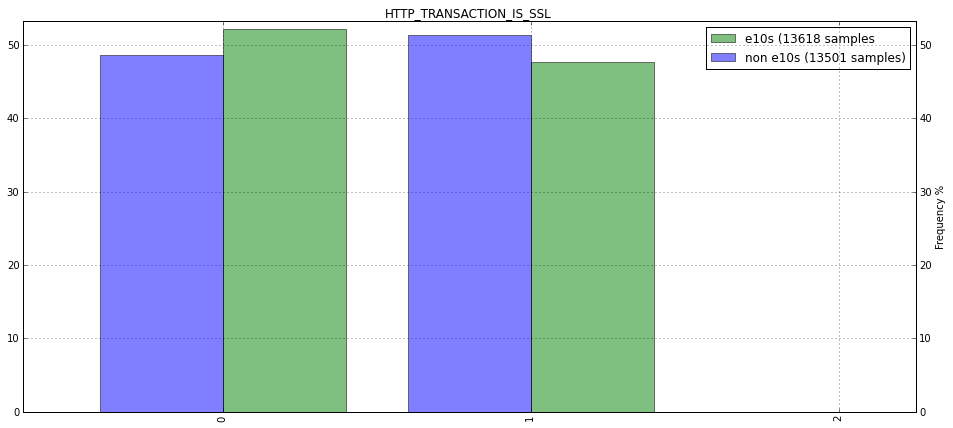

The chi2 distance for PREDICTOR_TOTAL_PRECONNECTS is 0.00132554311634


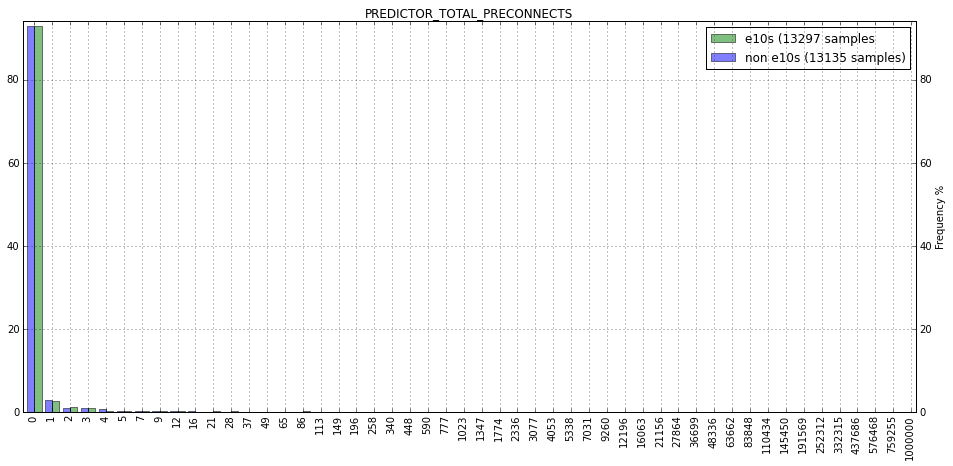

The chi2 distance for SIMPLE_MEASURES_UPTIME is 0.00131893413321


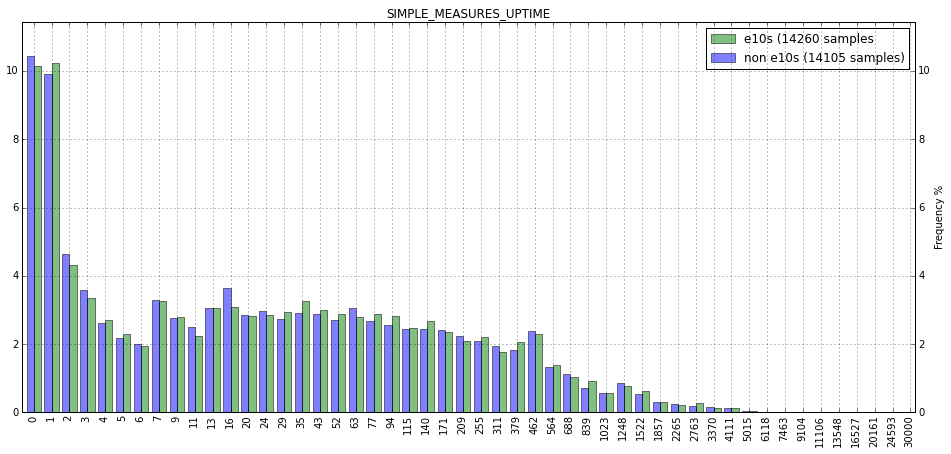

The chi2 distance for WORD_CACHE_MISSES_CHROME is 0.00128804757851


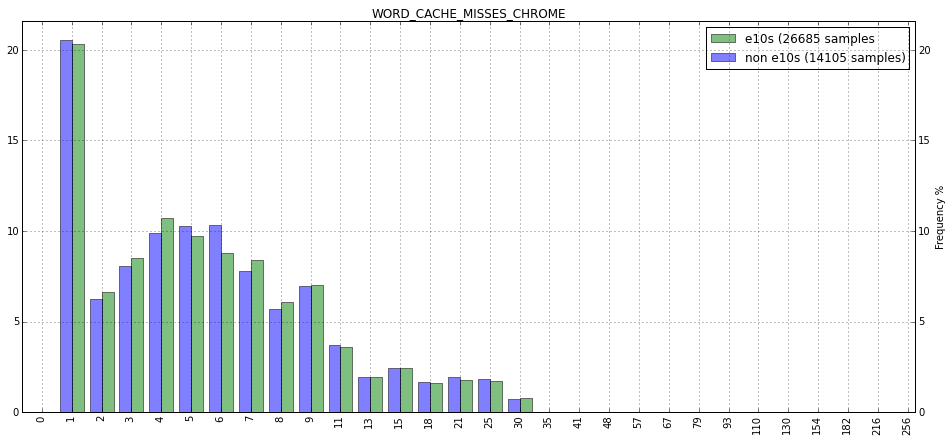

The chi2 distance for SIMPLE_MEASURES_PROFILEBEFORECHANGE is 0.0012629026809


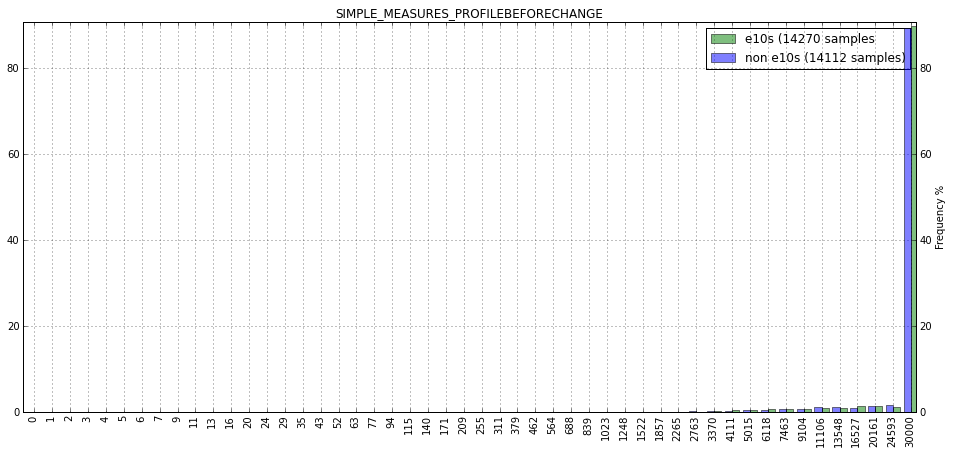

The chi2 distance for SIMPLE_MEASURES_ADDONMANAGER_XPIDB_PARSEDB_MS is 0.00124336386936


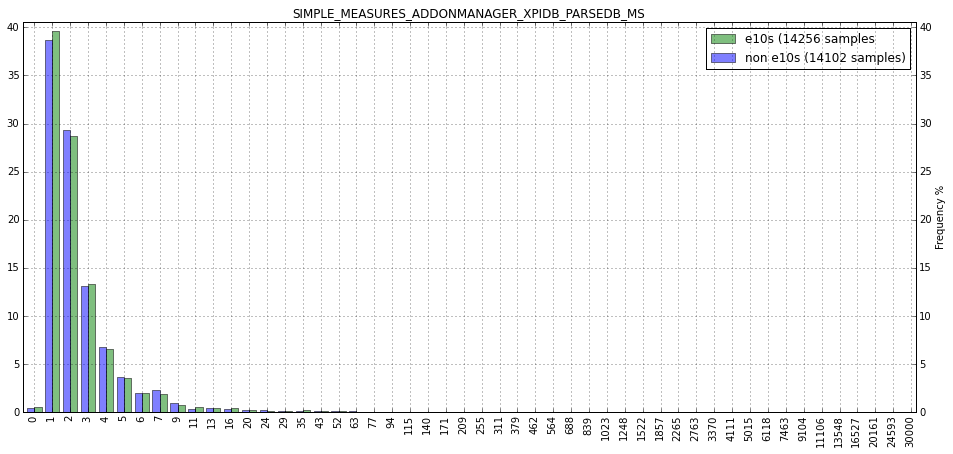

The chi2 distance for SPDY_SYN_SIZE is 0.00120021469887


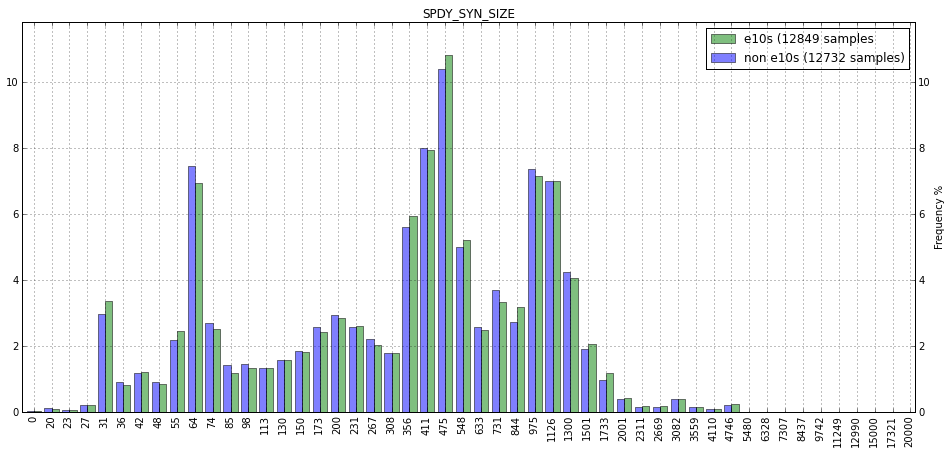

The chi2 distance for CERT_CHAIN_KEY_SIZE_STATUS is 0.00118936376026


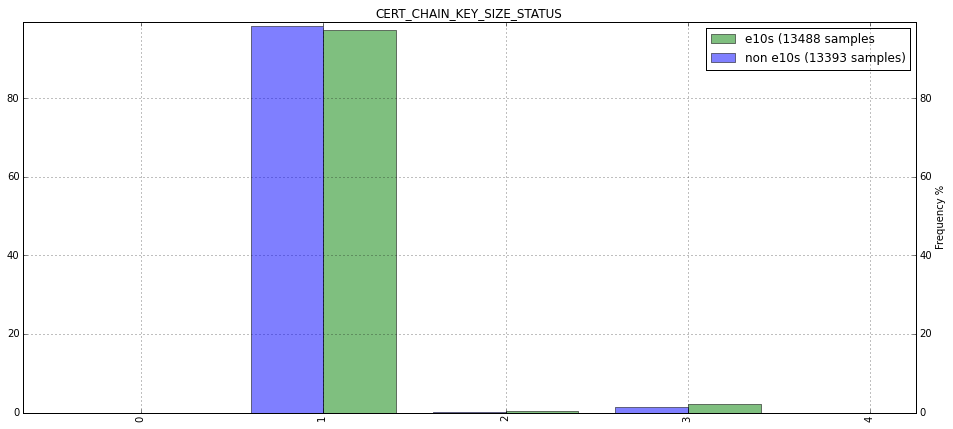

The chi2 distance for DEVTOOLS_TABS_PINNED_AVERAGE_LINEAR is 0.00115835815997


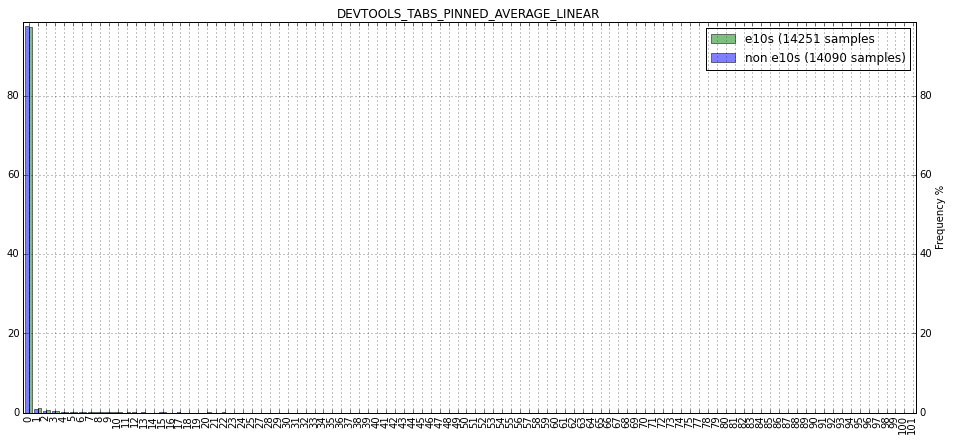

The chi2 distance for SIMPLE_MEASURES_SESSIONRESTOREINITIALIZED is 0.00115157523439


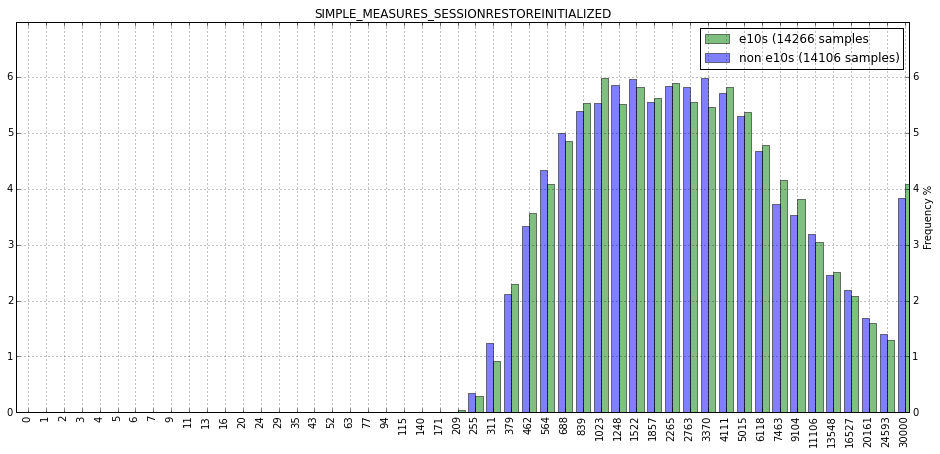

The chi2 distance for SIMPLE_MEASURES_ADDONMANAGER_XPIDB_DECODE_MS is 0.00114885963313


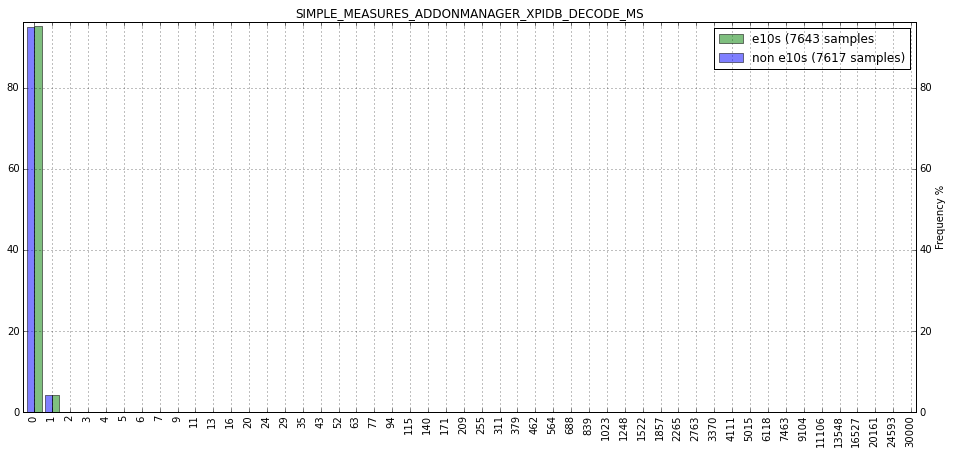

The chi2 distance for FX_SESSION_RESTORE_FILE_SIZE_BYTES is 0.00109769063411


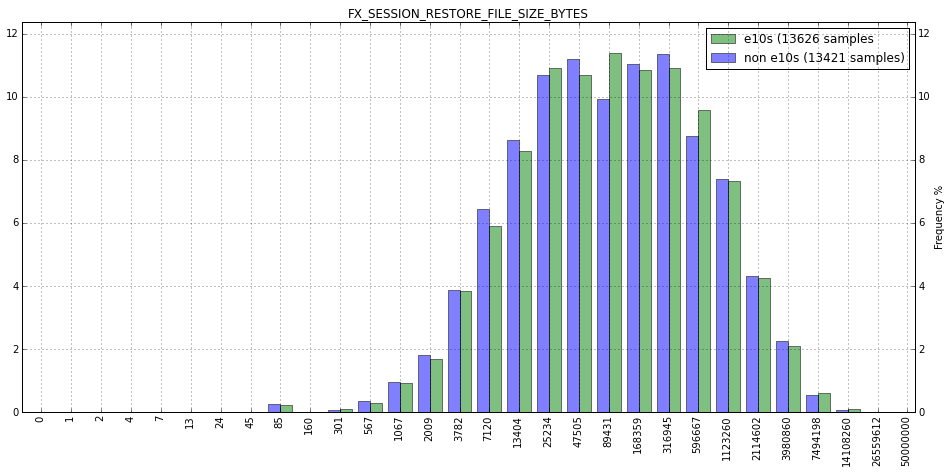

The chi2 distance for SIMPLE_MEASURES_FIRSTPAINT is 0.00109313521697


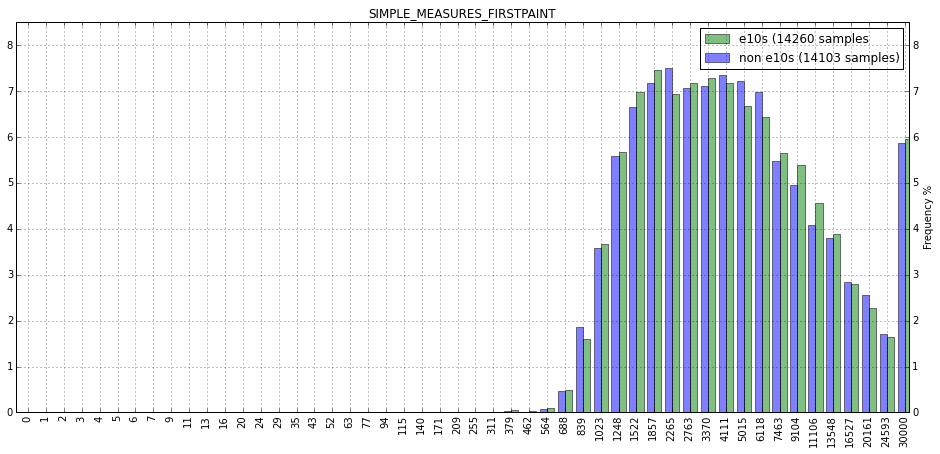

The chi2 distance for UPDATE_LAST_NOTIFY_INTERVAL_DAYS_NOTIFY is 0.00108671442979


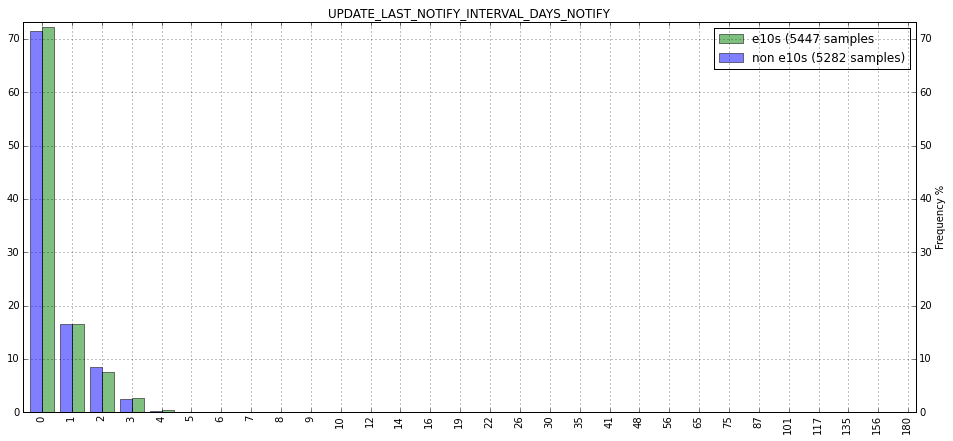

The chi2 distance for STARTUP_CRASH_DETECTED is 0.00105517084487


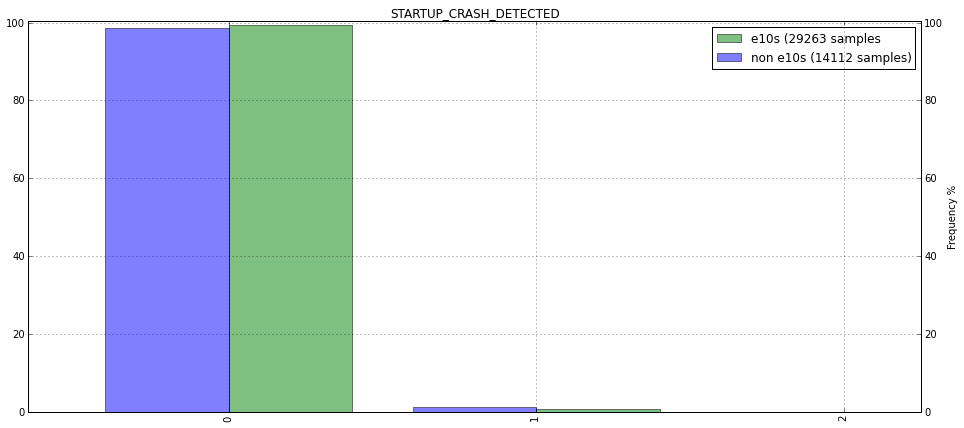

The chi2 distance for SIMPLE_MEASURES_CREATETOPLEVELWINDOW is 0.00103143855464


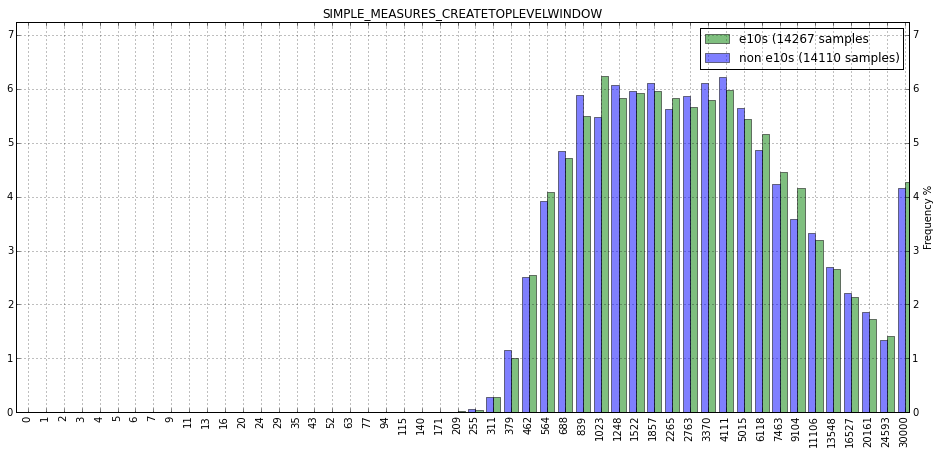

The chi2 distance for STS_POLL_AND_EVENTS_CYCLE is 0.00103024198451


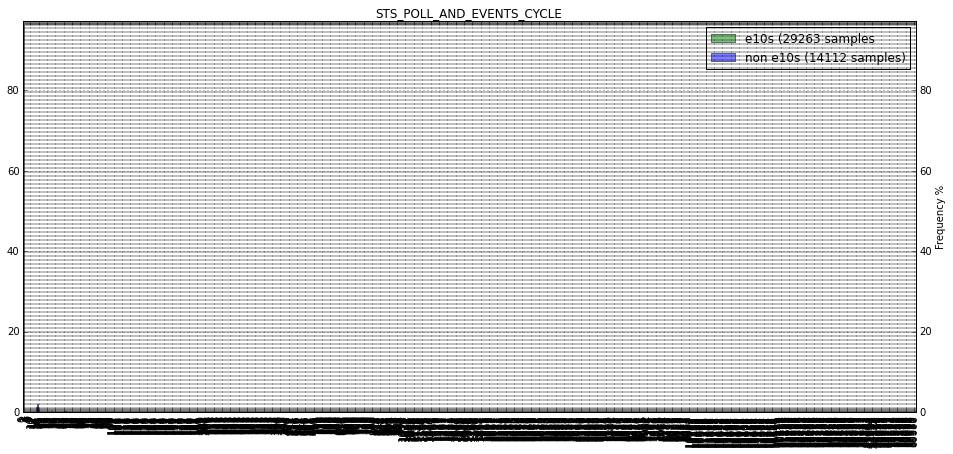

In [31]:
keys.sort(key=lambda key: chi2_distance(aggregates[0][key]["histogram"], aggregates[1][key]["histogram"]), reverse=True)

for key in keys:
    compare_histogram(key, aggregates[1][key], aggregates[0][key])    